# EN-AR Model Training

## Objective
- Train a bidirectional EN <-> AR encoder-decoder model from random initialization.
- Use the cleaned combined dataset exported by Notebook 01.


In [1]:
import os
os.environ["PATH"] = r"C:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.44.35207\bin\Hostx64\x64" + os.pathsep + os.environ.get("PATH", "")

In [1]:
# Setup: imports and training constants
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import torch

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

candidate_roots = [Path.cwd(), Path.cwd().parent]
PROJECT_ROOT = next((r for r in candidate_roots if (r / "artifacts").exists()), Path.cwd())
DATA_PATH = PROJECT_ROOT / "artifacts" / "eda" / "final_cleaned_combined_dataset.parquet"

@dataclass
class TrainConfig:
    max_seq_len: int = 128
    vocab_size: int = 32_000
    train_ratio: float = 0.90
    val_ratio: float = 0.05
    test_ratio: float = 0.05

config = TrainConfig()
print(f"Project root: {PROJECT_ROOT}")
print(f"Dataset path: {DATA_PATH}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(config)


Project root: c:\My Projects\en-ar-translation
Dataset path: c:\My Projects\en-ar-translation\artifacts\eda\final_cleaned_combined_dataset.parquet
CUDA available: True
TrainConfig(max_seq_len=128, vocab_size=32000, train_ratio=0.9, val_ratio=0.05, test_ratio=0.05)


In [2]:
# Micro-step 2: load cleaned dataset and validate schema
assert DATA_PATH.exists(), f"Cleaned dataset not found: {DATA_PATH}"
df = pd.read_parquet(DATA_PATH)

required_columns = ["en", "ar"]
missing = [c for c in required_columns if c not in df.columns]
assert not missing, f"Missing required columns: {missing}"

print(f"Loaded dataset: {DATA_PATH}")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")


Loaded dataset: c:\My Projects\en-ar-translation\artifacts\eda\final_cleaned_combined_dataset.parquet
Shape: (827576, 2)
Columns: ['en', 'ar']


In [3]:
# Micro-step 3: remove invalid/empty rows and report before/after
rows_before = len(df)

df = df.dropna(subset=["en", "ar"]).copy()
df["en"] = df["en"].astype(str).str.strip()
df["ar"] = df["ar"].astype(str).str.strip()
df = df[(df["en"] != "") & (df["ar"] != "")].reset_index(drop=True)

rows_after = len(df)
rows_removed = rows_before - rows_after
print(f"Rows before cleaning: {rows_before:,}")
print(f"Rows after cleaning: {rows_after:,}")
print(f"Rows removed: {rows_removed:,}")


Rows before cleaning: 827,576
Rows after cleaning: 827,546
Rows removed: 30


In [5]:
# Quick check: 10 random rows from current dataset
df.sample(n=10)[["en", "ar"]].reset_index(drop=True)

,en,ar
0,man with blue shirt standing in a gymnasium,رجل ذو قميص أزرق يقف في صالة رياضية
1,Hart did not run for public office again.,لم تبحث شركة Hart عن مقر عام لها مجددا.
2,uh present day linda ronstadt,في الوقت الحاضر (ليندا رونستد)
3,The current mayor is Leonard Reed.,ليونارد ريد هو عمدة البلدية الحالي.
4,"""It's for Annabelle.""",إنها لأنابيل.
5,thats not your problem,هذه ليست مشكلتك
6,leave me alone,كلا ! دعوني وشأني
7,a large silver filigree pendant on a white bac...,قلادة فضية كبيرة على خلفية بيضاء
8,a large brick building with a blue sign that r...,مبنى كبير من الطوب مع علامة زرقاء التي تقرأ'mo...
9,egyptian president muhammad morsi has started ...,بدا الرييس المصري محمد مرسي رسميا بالتغريد عبر...


In [4]:
# Micro-step 4: deterministic hash split (90/5/5) with leakage guard
assert abs((config.train_ratio + config.val_ratio + config.test_ratio) - 1.0) < 1e-9, "Split ratios must sum to 1.0"

pair_hash = pd.util.hash_pandas_object(df[["en", "ar"]], index=False).astype("uint64")
u = pair_hash / np.float64(2**64)

train_cut = config.train_ratio
val_cut = config.train_ratio + config.val_ratio
df["split"] = np.where(u < train_cut, "train", np.where(u < val_cut, "val", "test"))

leak_count = int((df.groupby(["en", "ar"])["split"].nunique() > 1).sum())
assert leak_count == 0, f"Leakage detected across splits for {leak_count} pairs"

split_counts = df["split"].value_counts().rename_axis("split").reset_index(name="rows")
split_counts["ratio"] = (split_counts["rows"] / len(df)).round(4)
split_counts


,split,rows,ratio
0,train,744926,0.9002
1,val,41445,0.0501
2,test,41175,0.0498


In [5]:
# Micro-step 5: build bidirectional rows with direction tokens
required_split_cols = ["en", "ar", "split"]
missing_split_cols = [c for c in required_split_cols if c not in df.columns]
assert not missing_split_cols, f"Missing columns before bidirectional build: {missing_split_cols}"

df_en_to_ar = pd.DataFrame({
    "source_text": "<2ar> " + df["en"],
    "target_text": df["ar"],
    "direction": "en_to_ar",
    "split": df["split"],
})

df_ar_to_en = pd.DataFrame({
    "source_text": "<2en> " + df["ar"],
    "target_text": df["en"],
    "direction": "ar_to_en",
    "split": df["split"],
})

df_bi = pd.concat([df_en_to_ar, df_ar_to_en], ignore_index=True)

print(f"Base rows: {len(df):,}")
print(f"Bidirectional rows: {len(df_bi):,}")

direction_split_counts = (
    df_bi.groupby(["split", "direction"]).size().reset_index(name="rows")
)
direction_split_counts


Base rows: 827,546
Bidirectional rows: 1,655,092


,split,direction,rows
0,test,ar_to_en,41175
1,test,en_to_ar,41175
2,train,ar_to_en,744926
3,train,en_to_ar,744926
4,val,ar_to_en,41445
5,val,en_to_ar,41445


In [6]:
# Micro-step 6: create train/val/test views from bidirectional dataset
required_bi_cols = ["source_text", "target_text", "direction", "split"]
missing_bi_cols = [c for c in required_bi_cols if c not in df_bi.columns]
assert not missing_bi_cols, f"Missing columns in df_bi: {missing_bi_cols}"

train_df = df_bi[df_bi["split"] == "train"].reset_index(drop=True)
val_df = df_bi[df_bi["split"] == "val"].reset_index(drop=True)
test_df = df_bi[df_bi["split"] == "test"].reset_index(drop=True)

assert len(train_df) + len(val_df) + len(test_df) == len(df_bi), "Split size mismatch"
assert len(train_df) > 0 and len(val_df) > 0 and len(test_df) > 0, "One split is empty"

print(f"train rows: {len(train_df):,}")
print(f"val rows: {len(val_df):,}")
print(f"test rows: {len(test_df):,}")


train rows: 1,489,852
val rows: 82,890
test rows: 82,350


In [7]:
# Micro-step 7: tokenizer setup (train split only)
try:
    from tokenizers import Tokenizer, decoders, models, pre_tokenizers, trainers
except ImportError as e:
    raise ImportError("`tokenizers` is required. Install with: pip install tokenizers") from e

TOKENIZER_DIR = PROJECT_ROOT / "artifacts" / "tokenizer"
TOKENIZER_DIR.mkdir(parents=True, exist_ok=True)
TOKENIZER_PATH = TOKENIZER_DIR / "en_ar_bpe_tokenizer.json"

SPECIAL_TOKENS = ["<pad>", "<s>", "</s>", "<unk>", "<2ar>", "<2en>"]

def train_corpus_iterator(df_in):
    for row in df_in.itertuples(index=False):
        yield row.source_text
        yield row.target_text

print(f"Tokenizer output path: {TOKENIZER_PATH}")
print(f"Special tokens: {SPECIAL_TOKENS}")
print("Tokenizer mode: ByteLevel BPE")
print(f"Train rows for tokenizer: {len(train_df):,}")
print(f"Approx lines seen by tokenizer iterator: {len(train_df) * 2:,}")


Tokenizer output path: c:\My Projects\en-ar-translation\artifacts\tokenizer\en_ar_bpe_tokenizer.json
Special tokens: ['<pad>', '<s>', '</s>', '<unk>', '<2ar>', '<2en>']
Tokenizer mode: ByteLevel BPE
Train rows for tokenizer: 1,489,852
Approx lines seen by tokenizer iterator: 2,979,704


In [8]:
# Micro-step 8: train and save shared ByteLevel BPE tokenizer
tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
tokenizer.decoder = decoders.ByteLevel()

trainer = trainers.BpeTrainer(
    vocab_size=config.vocab_size,
    special_tokens=SPECIAL_TOKENS,
    min_frequency=2,
    initial_alphabet=pre_tokenizers.ByteLevel.alphabet(),
)

tokenizer.train_from_iterator(train_corpus_iterator(train_df), trainer=trainer)
tokenizer.save(str(TOKENIZER_PATH))

vocab_size_trained = tokenizer.get_vocab_size()
print(f"Trained tokenizer vocab size: {vocab_size_trained:,}")
print(f"Saved tokenizer to: {TOKENIZER_PATH}")


Trained tokenizer vocab size: 32,000
Saved tokenizer to: c:\My Projects\en-ar-translation\artifacts\tokenizer\en_ar_bpe_tokenizer.json


In [11]:
# Micro-step 9: tokenizer audit (critical checks)
from collections import Counter

# Ensure tokenizer object is available (reload from disk if needed)
if "tokenizer" not in globals():
    tokenizer = Tokenizer.from_file(str(TOKENIZER_PATH))

# 1) Special-token integrity
special_token_ids = {tok: tokenizer.token_to_id(tok) for tok in SPECIAL_TOKENS}
missing_special = [tok for tok, tid in special_token_ids.items() if tid is None]
assert not missing_special, f"Missing special tokens in tokenizer vocab: {missing_special}"

id_2ar = special_token_ids["<2ar>"]
id_2en = special_token_ids["<2en>"]
probe_2ar = tokenizer.encode("<2ar> this is a test")
probe_2en = tokenizer.encode("<2en> english direction probe")
assert len(probe_2ar.ids) > 0 and probe_2ar.ids[0] == id_2ar, "<2ar> is not preserved as first token"
assert len(probe_2en.ids) > 0 and probe_2en.ids[0] == id_2en, "<2en> is not preserved as first token"

# 2) Sample-based token-length and truncation audit (real tokenizer lengths)
audit_sample_size = min(20000, len(df_bi))
audit_df = df_bi.sample(n=audit_sample_size, random_state=RANDOM_SEED) if len(df_bi) > audit_sample_size else df_bi

src_lengths = []
tgt_lengths = []
unk_counter = Counter()
unk_id = special_token_ids["<unk>"]

for row in audit_df.itertuples(index=False):
    src_ids = tokenizer.encode(row.source_text).ids
    tgt_ids = tokenizer.encode(row.target_text).ids
    src_lengths.append(len(src_ids))
    tgt_lengths.append(len(tgt_ids))
    unk_counter["src_unk_tokens"] += sum(1 for i in src_ids if i == unk_id)
    unk_counter["tgt_unk_tokens"] += sum(1 for i in tgt_ids if i == unk_id)

src_lengths = np.array(src_lengths, dtype=np.int32)
tgt_lengths = np.array(tgt_lengths, dtype=np.int32)

tokenizer_audit = pd.DataFrame({
    "metric": [
        "sample_rows",
        "trained_vocab_size",
        "src_len_p50", "src_len_p90", "src_len_p95", "src_len_p99",
        "tgt_len_p50", "tgt_len_p90", "tgt_len_p95", "tgt_len_p99",
        "src_trunc_ratio_gt_max_len",
        "tgt_trunc_ratio_gt_max_len",
        "either_trunc_ratio_gt_max_len",
        "src_unk_tokens",
        "tgt_unk_tokens",
    ],
    "value": [
        int(len(audit_df)),
        int(tokenizer.get_vocab_size()),
        int(np.percentile(src_lengths, 50)), int(np.percentile(src_lengths, 90)), int(np.percentile(src_lengths, 95)), int(np.percentile(src_lengths, 99)),
        int(np.percentile(tgt_lengths, 50)), int(np.percentile(tgt_lengths, 90)), int(np.percentile(tgt_lengths, 95)), int(np.percentile(tgt_lengths, 99)),
        float((src_lengths > config.max_seq_len).mean()),
        float((tgt_lengths > config.max_seq_len).mean()),
        float(((src_lengths > config.max_seq_len) | (tgt_lengths > config.max_seq_len)).mean()),
        int(unk_counter["src_unk_tokens"]),
        int(unk_counter["tgt_unk_tokens"]),
    ]
})

print("Special token IDs:", special_token_ids)
print("Direction token probes OK (<2ar>/<2en> preserved).")
tokenizer_audit


Special token IDs: {'<pad>': 0, '<s>': 1, '</s>': 2, '<unk>': 3, '<2ar>': 4, '<2en>': 5}
Direction token probes OK (<2ar>/<2en> preserved).


,metric,value
0,sample_rows,20000.0000
1,trained_vocab_size,32000.0000
2,src_len_p50,9.0000
3,src_len_p90,18.0000
4,src_len_p95,21.0000
5,src_len_p99,28.0000
6,tgt_len_p50,8.0000
7,tgt_len_p90,17.0000
8,tgt_len_p95,20.0000
9,tgt_len_p99,28.0000


In [9]:
# Micro-step 10: build and save Hugging Face compatible fast tokenizer
from transformers import PreTrainedTokenizerFast

HF_TOKENIZER_DIR = TOKENIZER_DIR / "hf_tokenizer"
HF_TOKENIZER_DIR.mkdir(parents=True, exist_ok=True)

hf_tokenizer = PreTrainedTokenizerFast(
    tokenizer_file=str(TOKENIZER_PATH),
    bos_token="<s>",
    eos_token="</s>",
    unk_token="<unk>",
    pad_token="<pad>",
    additional_special_tokens=["<2ar>", "<2en>"],
)

# Verify essential token ids exist
required_tokens = ["<pad>", "<s>", "</s>", "<unk>", "<2ar>", "<2en>"]
token_id_map = {tok: hf_tokenizer.convert_tokens_to_ids(tok) for tok in required_tokens}
missing_ids = [tok for tok, tid in token_id_map.items() if tid is None or tid < 0]
assert not missing_ids, f"Missing token ids in hf_tokenizer: {missing_ids}"

hf_tokenizer.save_pretrained(str(HF_TOKENIZER_DIR))

print(f"Saved HF tokenizer to: {HF_TOKENIZER_DIR}")
print("Token IDs:", token_id_map)
print(f"HF vocab size: {hf_tokenizer.vocab_size:,}")


Saved HF tokenizer to: c:\My Projects\en-ar-translation\artifacts\tokenizer\hf_tokenizer
Token IDs: {'<pad>': 0, '<s>': 1, '</s>': 2, '<unk>': 3, '<2ar>': 4, '<2en>': 5}
HF vocab size: 32,000


In [10]:
# Micro-step 11: tokenize train/val/test (truncation only, no static padding)
from datasets import Dataset

def tokenize_batch(batch):
    src = hf_tokenizer(
        batch["source_text"],
        truncation=True,
        max_length=config.max_seq_len,
        padding=False,
    )
    tgt = hf_tokenizer(
        batch["target_text"],
        truncation=True,
        max_length=config.max_seq_len,
        padding=False,
    )
    src["labels"] = tgt["input_ids"]
    return src

train_ds = Dataset.from_pandas(train_df[["source_text", "target_text", "direction", "split"]], preserve_index=False)
val_ds = Dataset.from_pandas(val_df[["source_text", "target_text", "direction", "split"]], preserve_index=False)
test_ds = Dataset.from_pandas(test_df[["source_text", "target_text", "direction", "split"]], preserve_index=False)

train_tok = train_ds.map(tokenize_batch, batched=True, desc="Tokenizing train")
val_tok = val_ds.map(tokenize_batch, batched=True, desc="Tokenizing val")
test_tok = test_ds.map(tokenize_batch, batched=True, desc="Tokenizing test")

print(f"Tokenized train rows: {len(train_tok):,}")
print(f"Tokenized val rows: {len(val_tok):,}")
print(f"Tokenized test rows: {len(test_tok):,}")
print(train_tok[0].keys())


Tokenizing train:   0%|          | 0/1489852 [00:00<?, ? examples/s]

Tokenizing val:   0%|          | 0/82890 [00:00<?, ? examples/s]

Tokenizing test:   0%|          | 0/82350 [00:00<?, ? examples/s]

Tokenized train rows: 1,489,852
Tokenized val rows: 82,890
Tokenized test rows: 82,350
dict_keys(['source_text', 'target_text', 'direction', 'split', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [11]:
# Micro-step 12: dynamic padding collator + one-batch sanity check
from transformers import DataCollatorForSeq2Seq

model_input_cols = ["input_ids", "attention_mask", "labels"]
train_tok_model = train_tok.remove_columns([c for c in train_tok.column_names if c not in model_input_cols])

data_collator = DataCollatorForSeq2Seq(
    tokenizer=hf_tokenizer,
    model=None,
    padding="longest",
    label_pad_token_id=-100,
)

batch_size_probe = min(32, len(train_tok_model))
probe_ds = train_tok_model.shuffle(seed=RANDOM_SEED).select(range(batch_size_probe))
probe_features = [probe_ds[i] for i in range(len(probe_ds))]
probe_batch = data_collator(probe_features)

print(f"Probe batch size: {batch_size_probe}")
print(f"input_ids shape: {tuple(probe_batch['input_ids'].shape)}")
print(f"attention_mask shape: {tuple(probe_batch['attention_mask'].shape)}")
print(f"labels shape: {tuple(probe_batch['labels'].shape)}")
print(f"Dynamic padded source length (batch max): {probe_batch['input_ids'].shape[1]}")
print(f"Dynamic padded target length (batch max): {probe_batch['labels'].shape[1]}")
print(f"Configured truncation cap: {config.max_seq_len}")


Probe batch size: 32
input_ids shape: (32, 74)
attention_mask shape: (32, 74)
labels shape: (32, 37)
Dynamic padded source length (batch max): 74
Dynamic padded target length (batch max): 37
Configured truncation cap: 128


In [15]:
# Micro-step 13: manual audit of random final tokenized examples
sample_n = min(5, len(train_tok))
audit_ds = train_tok.shuffle().select(range(sample_n))

audit_rows = []
for item in audit_ds:
    src_ids = item["input_ids"]
    lbl_ids = item["labels"]
    audit_rows.append({
        "direction": item.get("direction", ""),
        "source_text": item["source_text"],
        "target_text": item["target_text"],
        "source_len": len(src_ids),
        "target_len": len(lbl_ids),
        "source_ids": src_ids,
        "target_ids": lbl_ids,
        "decoded_source_from_ids": hf_tokenizer.decode(src_ids, skip_special_tokens=False),
        "decoded_target_from_ids": hf_tokenizer.decode(lbl_ids, skip_special_tokens=False),
    })

tokenized_audit_df = pd.DataFrame(audit_rows)
tokenized_audit_df


,direction,source_text,target_text,source_len,target_len,source_ids,target_ids,decoded_source_from_ids,decoded_target_from_ids
0,ar_to_en,<2en> فقد نفذ مني البروبان تقريبا,im nearly out of propane,7,6,"[5, 3071, 18650, 4714, 1520, 16742, 4348]","[431, 9763, 684, 333, 4298, 2385]",<2en> فقد نفذ مني البروبان تقريبا,im nearly out of propane
1,en_to_ar,<2ar> another glass for the lady,أتريدين كأسا آخر؟,6,4,"[4, 2200, 1849, 434, 295, 5523]","[27912, 17415, 1714, 411]",<2ar> another glass for the lady,أتريدين كأسا آخر؟
2,ar_to_en,<2en> أنت مضحك,mm youre funny,3,3,"[5, 895, 10872]","[3683, 1151, 5910]",<2en> أنت مضحك,mm youre funny
3,ar_to_en,<2en> رغم ذلك، فإن هذه المعتقدات لها ما يبررها...,"However, these beliefs are clearly justified.",17,10,"[5, 10193, 569, 360, 3970, 687, 332, 1144, 335...","[3799, 17, 1614, 18768, 88, 450, 13120, 798, 4...",<2en> رغم ذلك، فإن هذه المعتقدات لها ما يبررها...,"However, these beliefs are clearly justified."
4,ar_to_en,<2en> قراءة والمشاركة في مدونة الاصوات الصاعدة...,read and participate on the rising voices blog...,39,35,"[5, 10144, 1723, 12101, 325, 7438, 2178, 29307...","[4776, 355, 18161, 372, 295, 13727, 2129, 2799...",<2en> قراءة والمشاركة في مدونة الاصوات الصاعدة...,read and participate on the rising voices blog...


In [16]:
for item in audit_ds:
    print("=" * 60)
    print(f"Direction : {item.get('direction', '')}")
    print(f"Source    : {item['source_text']}")
    print(f"Target    : {item['target_text']}")
    print(f"Input IDs : {item['input_ids']}")
    print(f"Labels    : {item['labels']}")
    print(f"Attn Mask : {item['attention_mask']}")
    print(f"Decoded S : {hf_tokenizer.decode(item['input_ids'], skip_special_tokens=False)}")
    print(f"Decoded T : {hf_tokenizer.decode(item['labels'], skip_special_tokens=False)}")
print("=" * 60)

Direction : ar_to_en
Source    : <2en> فقد نفذ مني البروبان تقريبا
Target    : im nearly out of propane
Input IDs : [5, 3071, 18650, 4714, 1520, 16742, 4348]
Labels    : [431, 9763, 684, 333, 4298, 2385]
Attn Mask : [1, 1, 1, 1, 1, 1, 1]
Decoded S : <2en> فقد نفذ مني البروبان تقريبا
Decoded T : im nearly out of propane
Direction : en_to_ar
Source    : <2ar> another glass for the lady
Target    : أتريدين كأسا آخر؟
Input IDs : [4, 2200, 1849, 434, 295, 5523]
Labels    : [27912, 17415, 1714, 411]
Attn Mask : [1, 1, 1, 1, 1, 1]
Decoded S : <2ar> another glass for the lady
Decoded T : أتريدين كأسا آخر؟
Direction : ar_to_en
Source    : <2en> أنت مضحك
Target    : mm youre funny
Input IDs : [5, 895, 10872]
Labels    : [3683, 1151, 5910]
Attn Mask : [1, 1, 1]
Decoded S : <2en> أنت مضحك
Decoded T : mm youre funny
Direction : ar_to_en
Source    : <2en> رغم ذلك، فإن هذه المعتقدات لها ما يبررها بوضوح.
Target    : However, these beliefs are clearly justified.
Input IDs : [5, 10193, 569, 360, 3970, 6

In [12]:
# Micro-step 14: define and instantiate random-init BART model
from transformers import BartConfig, BartForConditionalGeneration

bart_config = BartConfig(
    vocab_size=hf_tokenizer.vocab_size,
    max_position_embeddings=config.max_seq_len + 2,
    d_model=512,
    encoder_layers=6,
    decoder_layers=6,
    encoder_attention_heads=8,
    decoder_attention_heads=8,
    encoder_ffn_dim=2048,
    decoder_ffn_dim=2048,
    dropout=0.1, # Main residual dropout (applied after attention & FFN blocks)
    attention_dropout=0.1, # Dropout applied to attention probabilities
    activation_dropout=0.0, # Dropout after FFN activation (kept 0 for stability)
    pad_token_id=hf_tokenizer.pad_token_id,
    bos_token_id=hf_tokenizer.bos_token_id,
    eos_token_id=hf_tokenizer.eos_token_id,
    decoder_start_token_id=hf_tokenizer.bos_token_id, # the decoder will start with <bos> to predict the first token
)

model = BartForConditionalGeneration(bart_config)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Initialized random BART model (no pretrained weights).")
print(f"Vocab size: {bart_config.vocab_size:,}")
print(f"d_model: {bart_config.d_model}, enc_layers: {bart_config.encoder_layers}, dec_layers: {bart_config.decoder_layers}")
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")


Initialized random BART model (no pretrained weights).
Vocab size: 32,000
d_model: 512, enc_layers: 6, dec_layers: 6
Total params: 60,659,712
Trainable params: 60,659,712


In [18]:
# Micro-step 15: one-batch forward-pass sanity check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.train()

probe_size = min(8, len(train_tok_model))
probe_ds = train_tok_model.shuffle(seed=RANDOM_SEED).select(range(probe_size))
probe_features = [probe_ds[i] for i in range(len(probe_ds))]
probe_batch = data_collator(probe_features)

batch_on_device = {k: v.to(device) for k, v in probe_batch.items()}
outputs = model(**batch_on_device)

loss_value = float(outputs.loss.detach().cpu().item())
assert np.isfinite(loss_value), f"Non-finite loss detected: {loss_value}"

print(f"Device: {device}")
print(f"Probe batch size: {probe_size}")
print(f"Loss: {loss_value:.6f}")
print(f"Logits shape: {tuple(outputs.logits.shape)}")
print(outputs.logits)


Device: cuda
Probe batch size: 8
Loss: 10.462287
Logits shape: (8, 17, 32000)
tensor([[[ 0.0000e+00,  4.7105e+00,  7.3093e-01,  ..., -1.7524e-01,
          -4.8019e-01, -2.6668e-01],
         [ 0.0000e+00,  8.7805e-04, -7.4898e-01,  ...,  1.4209e-01,
           7.2610e-02, -9.1130e-02],
         [ 0.0000e+00, -1.0881e-01,  3.3885e-01,  ..., -6.3099e-01,
          -1.9324e-01, -2.8855e-01],
         ...,
         [ 0.0000e+00, -1.6474e-01,  3.3509e-01,  ..., -8.8127e-02,
          -6.1816e-01, -4.6103e-01],
         [ 0.0000e+00,  1.9915e-01,  2.0464e-01,  ...,  2.3678e-01,
           2.9234e-01, -7.0112e-01],
         [ 0.0000e+00, -7.7394e-01, -3.0749e-01,  ..., -1.1064e-01,
          -6.7551e-01, -4.5202e-01]],

        [[ 0.0000e+00,  4.4847e+00,  1.6182e-01,  ...,  7.3620e-01,
          -7.9925e-01,  6.1794e-02],
         [ 0.0000e+00,  1.7318e-01, -5.4782e-01,  ...,  8.3050e-01,
           3.1044e-01, -4.5127e-02],
         [ 0.0000e+00,  3.1265e-01,  2.2879e-01,  ...,  3.6026e-01

In [19]:
# Micro-step 16: training hyperparameters + optimizer/scheduler setup
from transformers import get_cosine_with_min_lr_schedule_with_warmup

assert "model" in globals(), "Model must be initialized before optimizer setup"

learning_rate = 3e-4
weight_decay = 0.01
adam_betas = (0.9, 0.98)
adam_eps = 1e-8

max_steps = 32_000
warmup_ratio = 0.015
num_warmup_steps = int(max_steps * warmup_ratio)

# Cosine decay floor: keep LR at >=10% of initial LR
min_lr_rate = 0.10
min_lr = learning_rate * min_lr_rate

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    betas=adam_betas,
    eps=adam_eps,
    weight_decay=weight_decay,
)

lr_scheduler = get_cosine_with_min_lr_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=max_steps,
    min_lr_rate=min_lr_rate,
)

print(f"max learning_rate: {learning_rate}")
print(f"min_lr_rate ratio: {min_lr_rate:.2f}")
print(f"min_lr value: {min_lr}")
print(f"weight_decay: {weight_decay}")
print(f"adam_betas: {adam_betas}")
print(f"max_steps: {max_steps:,}")
print(f"num_warmup_steps: {num_warmup_steps:,}")


max learning_rate: 0.0003
min_lr_rate ratio: 0.10
min_lr value: 2.9999999999999997e-05
weight_decay: 0.01
adam_betas: (0.9, 0.98)
max_steps: 32,000
num_warmup_steps: 480


In [28]:
# Micro-step 17: runtime memory config (checkpointing OFF by default)
assert "model" in globals(), "Model must exist before runtime memory config"

# Start simple: no gradient checkpointing unless we face OOM
use_gradient_checkpointing = False
if use_gradient_checkpointing:
    model.gradient_checkpointing_enable()
else:
    model.gradient_checkpointing_disable()

# Mixed precision for 8GB VRAM training efficiency
use_fp16 = torch.cuda.is_available()
grad_scaler = torch.amp.GradScaler("cuda", enabled=use_fp16)

# Initial batch settings (can be tuned after smoke run)
per_device_train_batch_size = 24
gradient_accumulation_steps = 32
effective_batch_size = per_device_train_batch_size * gradient_accumulation_steps

# Optional acceleration on Ampere+ GPUs
if torch.cuda.is_available() and hasattr(torch.backends.cuda.matmul, "allow_tf32"):
    print("Enabling TF32 for matmul and cuDNN (Ampere+ GPUs)")
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

print(f"use_gradient_checkpointing: {use_gradient_checkpointing}")
print(f"use_fp16: {use_fp16}")
print(f"per_device_train_batch_size: {per_device_train_batch_size}")
print(f"gradient_accumulation_steps: {gradient_accumulation_steps}")
print(f"effective_batch_size (examples/update): {effective_batch_size}")


Enabling TF32 for matmul and cuDNN (Ampere+ GPUs)
use_gradient_checkpointing: False
use_fp16: True
per_device_train_batch_size: 24
gradient_accumulation_steps: 32
effective_batch_size (examples/update): 768


In [29]:
# Micro-step 18: dynamic training-volume analytics
assert "per_device_train_batch_size" in globals(), "Run runtime config cell first"
assert "gradient_accumulation_steps" in globals(), "Run runtime config cell first"
assert "max_steps" in globals(), "Run optimizer/scheduler cell first"
assert "train_df" in globals(), "Run split/bidirectional cells first"

examples_per_micro_batch = int(per_device_train_batch_size)
examples_per_optimizer_step = int(per_device_train_batch_size * gradient_accumulation_steps)
examples_seen_total = int(max_steps * examples_per_optimizer_step)
train_examples = int(len(train_df))
approx_epochs = (examples_seen_total / train_examples) if train_examples else 0.0

analytics_df = pd.DataFrame([
    {"metric": "examples_per_micro_batch", "value": examples_per_micro_batch},
    {"metric": "gradient_accumulation_steps", "value": int(gradient_accumulation_steps)},
    {"metric": "examples_per_optimizer_step", "value": examples_per_optimizer_step},
    {"metric": "max_steps", "value": int(max_steps)},
    {"metric": "examples_seen_total", "value": examples_seen_total},
    {"metric": "train_examples", "value": train_examples},
    {"metric": "approx_epochs_over_train_split", "value": round(approx_epochs, 4)},
    {"metric": "coverage_percent_of_train_split %", "value": round(approx_epochs * 100, 2)},
])

analytics_df = analytics_df.astype({"value": float})


print("Training-volume summary:")
analytics_df.style.format({"value": "{:,.0f}"})


Training-volume summary:


,metric,value
0,examples_per_micro_batch,24
1,gradient_accumulation_steps,32
2,examples_per_optimizer_step,768
3,max_steps,"32,000"
4,examples_seen_total,"24,576,000"
5,train_examples,"1,489,852"
6,approx_epochs_over_train_split,16
7,coverage_percent_of_train_split %,"1,650"


In [30]:
# Micro-step 19: quick training-time estimate for current max_steps
assert "max_steps" in globals(), "Run optimizer/scheduler setup cell first"

# Set this after a short timed run (seconds per optimizer step)
sec_per_step_estimate = 1.5

total_seconds = max_steps * sec_per_step_estimate
total_hours = total_seconds / 3600

print(f"max_steps: {max_steps:,}")
print(f"sec_per_step_estimate: {sec_per_step_estimate:.3f}")
print(f"estimated_total_seconds: {total_seconds:,.0f}")
print(f"estimated_total_hours: {total_hours:.2f}")

for s in [1.0, 1.5, 2.0, 2.5, 3.0]:
    h = (max_steps * s) / 3600
    print(f"if {s:.1f}s/step -> {h:.2f} hours")


max_steps: 32,000
sec_per_step_estimate: 1.500
estimated_total_seconds: 48,000
estimated_total_hours: 13.33
if 1.0s/step -> 8.89 hours
if 1.5s/step -> 13.33 hours
if 2.0s/step -> 17.78 hours
if 2.5s/step -> 22.22 hours
if 3.0s/step -> 26.67 hours


In [23]:
# Micro-step 19b: optional torch.compile acceleration
use_torch_compile = False #torch.cuda.is_available() and hasattr(torch, "compile")

if use_torch_compile:
    try:
        # `reduce-overhead` is a practical starting mode for training loops
        model = torch.compile(model, backend="eager", dynamic=True)
        print("torch.compile: enabled")
    except Exception as e:
        print(f"torch.compile: failed, continuing without compile. reason={e}")
else:
    print("torch.compile: skipped (CUDA or torch.compile unavailable)")


torch.compile: skipped (CUDA or torch.compile unavailable)


In [24]:
# # Micro-step 20: 50-step smoke training run
# import time
# from torch.utils.data import DataLoader

# smoke_steps = 50
# assert smoke_steps > 0, "smoke_steps must be positive"

# train_tok_model = train_tok.remove_columns([c for c in train_tok.column_names if c not in ["input_ids", "attention_mask", "labels"]])
# val_tok_model = val_tok.remove_columns([c for c in val_tok.column_names if c not in ["input_ids", "attention_mask", "labels"]])

# train_loader = DataLoader(
#     train_tok_model,
#     batch_size=per_device_train_batch_size,
#     shuffle=True,
#     collate_fn=data_collator,
#     drop_last=False,
#     num_workers=2,
#     pin_memory=True,
# )
# val_loader = DataLoader(
#     val_tok_model,
#     batch_size=per_device_train_batch_size,
#     shuffle=False,
#     collate_fn=data_collator,
#     drop_last=False,
#     num_workers=2,
#     pin_memory=True,
# )

# model.train()
# optimizer.zero_grad(set_to_none=True)
# start = time.time()
# running_loss = 0.0
# optimizer_steps_done = 0

# for micro_step, batch in enumerate(train_loader, start=1):
#     if optimizer_steps_done >= smoke_steps:
#         break

#     batch = {k: v.to(device) for k, v in batch.items()}

#     if use_fp16:
#         with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
#             out = model(**batch)
#             loss = out.loss / gradient_accumulation_steps
#         grad_scaler.scale(loss).backward()
#     else:
#         out = model(**batch)
#         loss = out.loss / gradient_accumulation_steps
#         loss.backward()

#     running_loss += float(out.loss.detach().cpu().item())

#     if micro_step % gradient_accumulation_steps == 0:
#         if use_fp16:
#             grad_scaler.step(optimizer)
#             grad_scaler.update()
#         else:
#             optimizer.step()
#         optimizer.zero_grad(set_to_none=True)
#         lr_scheduler.step()
#         optimizer_steps_done += 1

#         if optimizer_steps_done % 10 == 0 or optimizer_steps_done == 1:
#             avg_loss = running_loss / micro_step
#             current_lr = optimizer.param_groups[0]["lr"]
#             print(f"step={optimizer_steps_done:>3} avg_train_loss={avg_loss:.4f} lr={current_lr:.6g}")

# # Quick single-batch validation check
# model.eval()
# with torch.no_grad():
#     val_batch = next(iter(val_loader))
#     val_batch = {k: v.to(device) for k, v in val_batch.items()}
#     if use_fp16:
#         with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
#             val_out = model(**val_batch)
#     else:
#         val_out = model(**val_batch)

# elapsed = time.time() - start
# steps_per_sec = optimizer_steps_done / elapsed if elapsed > 0 else 0.0
# sec_per_step_estimate = 1.0 / steps_per_sec if steps_per_sec > 0 else float("inf")

# print("-" * 60)
# print(f"smoke optimizer steps completed: {optimizer_steps_done}")
# print(f"elapsed_sec: {elapsed:.2f}")
# print(f"steps_per_sec: {steps_per_sec:.4f}")
# print(f"sec_per_step_estimate: {sec_per_step_estimate:.4f}")
# print(f"val_loss_single_batch: {float(val_out.loss.detach().cpu().item()):.4f}")
# if torch.cuda.is_available():
#     peak_mem_gb = torch.cuda.max_memory_allocated(device) / (1024**3)
#     print(f"peak_cuda_memory_gb: {peak_mem_gb:.3f}")


In [18]:
# Micro-step 21a: helper functions for eval, metrics, and checkpointing
import math
from tqdm.auto import tqdm

def _load_text_metrics(enable_comet=False):
    try:
        import evaluate
    except ImportError as e:
        raise ImportError("`evaluate` is required for BLEU/chrF metrics. Install: pip install evaluate sacrebleu") from e

    _bleu_metric = evaluate.load("sacrebleu")
    _chrf_metric = evaluate.load("chrf")
    _comet_metric = None
    if enable_comet:
        try:
            _comet_metric = evaluate.load("comet")
        except Exception as e:
            print(f"[warn] COMET unavailable; continuing without COMET. Reason: {e}")
            _comet_metric = None
    return _bleu_metric, _chrf_metric, _comet_metric

def _eval_val_loss(_model, _val_loader, _device, _use_fp16, _max_batches=None):
    _model.eval()
    losses = []
    with torch.no_grad():
        for b_idx, batch in enumerate(_val_loader):
            if _max_batches is not None and b_idx >= _max_batches:
                break
            batch = {k: v.to(_device) for k, v in batch.items()}
            if _use_fp16:
                with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                    out = _model(**batch)
            else:
                out = _model(**batch)
            losses.append(float(out.loss.detach().cpu().item()))
    _model.train()
    return float(np.mean(losses)) if losses else float("nan")

def _loss_to_ppl(_loss):
    if _loss is None or not np.isfinite(_loss):
        return float("nan")
    # Cap exponent to avoid overflow while keeping PPL monotonic in loss.
    return float(math.exp(min(float(_loss), 20.0)))

def _eval_text_metrics(
    _model,
    _tokenizer,
    _eval_df,
    _device,
    _batch_size,
    _max_batches,
    _num_beams,
    _seed,
    _bleu_metric,
    _chrf_metric,
    _comet_metric=None,
):

    _model.eval()
    if _eval_df is None or len(_eval_df) == 0:
        _model.train()
        return {
            "num_samples": 0,
            "num_batches": 0,
            "bleu": float("nan"),
            "chrf": float("nan"),
            "comet": float("nan"),
            "bleu_en_to_ar": float("nan"),
            "bleu_ar_to_en": float("nan"),
            "chrf_en_to_ar": float("nan"),
            "chrf_ar_to_en": float("nan"),
        }

    if _max_batches is None:
        sample_df = _eval_df.reset_index(drop=True)
    else:
        max_samples = int(_max_batches * _batch_size)
        max_samples = min(max_samples, len(_eval_df))
        if max_samples <= 0:
            _model.train()
            return {
                "num_samples": 0,
                "num_batches": 0,
                "bleu": float("nan"),
                "chrf": float("nan"),
                "comet": float("nan"),
                "bleu_en_to_ar": float("nan"),
                "bleu_ar_to_en": float("nan"),
                "chrf_en_to_ar": float("nan"),
                "chrf_ar_to_en": float("nan"),
            }
        sample_df = _eval_df.sample(n=max_samples, random_state=int(_seed)).reset_index(drop=True)

    preds = []
    refs = []
    srcs = []
    dirs = []
    total_batches = math.ceil(len(sample_df) / _batch_size)
    with torch.no_grad():
        for start in tqdm(range(0, len(sample_df), _batch_size), total=total_batches, desc="Generating", unit="batch"):
            chunk = sample_df.iloc[start : start + _batch_size]
            src_batch = chunk["source_text"].astype(str).tolist()
            ref_batch = chunk["target_text"].astype(str).tolist()
            dir_batch = chunk["direction"].astype(str).tolist()

            enc = _tokenizer(
                src_batch,
                truncation=True,
                max_length=config.max_seq_len,
                padding=True,
                return_token_type_ids=False,
                return_tensors="pt",
            )
            enc.pop("token_type_ids", None)
            enc = {k: v.to(_device) for k, v in enc.items()}
            gen_ids = _model.generate(
                **enc,
                max_new_tokens=config.max_seq_len,
                num_beams=_num_beams,
                do_sample=False,
            )
            pred_batch = _tokenizer.batch_decode(gen_ids, skip_special_tokens=True)

            preds.extend([p.strip() for p in pred_batch])
            refs.extend([r.strip() for r in ref_batch])
            srcs.extend(src_batch)
            dirs.extend(dir_batch)

    _model.train()

    if len(preds) == 0:
        return {
            "num_samples": 0,
            "num_batches": 0,
            "bleu": float("nan"),
            "chrf": float("nan"),
            "comet": float("nan"),
            "bleu_en_to_ar": float("nan"),
            "bleu_ar_to_en": float("nan"),
            "chrf_en_to_ar": float("nan"),
            "chrf_ar_to_en": float("nan"),
        }

    def _score_subset(_preds, _refs):
        if len(_preds) == 0:
            return float("nan"), float("nan")
        _bleu = float(_bleu_metric.compute(predictions=_preds, references=[[r] for r in _refs])["score"])
        _chrf = float(_chrf_metric.compute(predictions=_preds, references=_refs)["score"])
        return _bleu, _chrf

    bleu_all, chrf_all = _score_subset(preds, refs)
    idx_en_to_ar = [i for i, d in enumerate(dirs) if d == "en_to_ar"]
    idx_ar_to_en = [i for i, d in enumerate(dirs) if d == "ar_to_en"]
    bleu_en_to_ar, chrf_en_to_ar = _score_subset([preds[i] for i in idx_en_to_ar], [refs[i] for i in idx_en_to_ar])
    bleu_ar_to_en, chrf_ar_to_en = _score_subset([preds[i] for i in idx_ar_to_en], [refs[i] for i in idx_ar_to_en])

    comet_score = float("nan")
    if _comet_metric is not None:
        try:
            print(f"[COMET] Starting COMET scoring on {len(preds):,} predictions...", flush=True)
            comet_out = _comet_metric.compute(predictions=preds, references=refs, sources=srcs)
            comet_score = float(comet_out.get("mean_score", comet_out.get("score", float("nan"))))
        except Exception as e:
            print(f"[warn] COMET scoring failed at runtime; continuing without COMET value. Reason: {e}")

    return {
        "num_samples": int(len(preds)),
        "num_batches": int(math.ceil(len(preds) / _batch_size)),
        "bleu": bleu_all,
        "chrf": chrf_all,
        "comet": comet_score,
        "bleu_en_to_ar": bleu_en_to_ar,
        "bleu_ar_to_en": bleu_ar_to_en,
        "chrf_en_to_ar": chrf_en_to_ar,
        "chrf_ar_to_en": chrf_ar_to_en,
    }

def _save_checkpoint(_model, _tokenizer, _optimizer, _scheduler, _scaler, _step, _val_loss, _target_dir):
    _target_dir.mkdir(parents=True, exist_ok=True)
    _model.save_pretrained(str(_target_dir))
    _tokenizer.save_pretrained(str(_target_dir / "tokenizer"))
    torch.save({
        "step": int(_step),
        "val_loss": float(_val_loss) if _val_loss is not None else None,
        "optimizer": _optimizer.state_dict(),
        "scheduler": _scheduler.state_dict(),
        "scaler": _scaler.state_dict() if _scaler is not None else None,
    }, _target_dir / "trainer_state.pt")


In [32]:
import json as pyjson
import shutil
import time
from datetime import datetime
from torch.utils.data import DataLoader

# -----------------------------
# Tunable run hyperparameters
# -----------------------------
log_every_steps = 40
eval_every_steps = 400
save_every_steps = 500
keep_last_n_checkpoints = 10
max_val_batches = 300  # set None to use full val loader
text_metric_num_beams = 1
max_text_metric_batches_log = 4   # lightweight text-metric pass at log intervals
max_text_metric_batches_eval = 32  # stronger text-metric pass at eval intervals
enable_comet = False
train_num_workers = 2
val_num_workers = 2
pin_memory = True

assert max_steps > 0, "max_steps must be > 0"
assert gradient_accumulation_steps > 0, "gradient_accumulation_steps must be > 0"

# Build train/val model-input datasets (dynamic padding via collator)
model_input_cols = ["input_ids", "attention_mask", "labels"]
train_tok_model = train_tok.remove_columns([c for c in train_tok.column_names if c not in model_input_cols])
val_tok_model = val_tok.remove_columns([c for c in val_tok.column_names if c not in model_input_cols])

train_loader = DataLoader(
    train_tok_model,
    batch_size=per_device_train_batch_size,
    shuffle=True,
    collate_fn=data_collator,
    num_workers=train_num_workers,
    pin_memory=pin_memory,
    persistent_workers=(train_num_workers > 0),
)
val_loader = DataLoader(
    val_tok_model,
    batch_size=per_device_train_batch_size,
    shuffle=True,
    collate_fn=data_collator,
    num_workers=val_num_workers,
    pin_memory=pin_memory,
    persistent_workers=(val_num_workers > 0),
)

In [26]:
# Run dirs and paths
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = PROJECT_ROOT / "artifacts" / "runs" / run_id
ckpt_root = PROJECT_ROOT / "checkpoints" / run_id
best_dir = ckpt_root / "best_model"
run_dir.mkdir(parents=True, exist_ok=True)
ckpt_root.mkdir(parents=True, exist_ok=True)
best_dir.mkdir(parents=True, exist_ok=True)
train_metrics_path = run_dir / "train_metrics.csv"
eval_metrics_path = run_dir / "eval_metrics.csv"
config_path = run_dir / "run_config.json"

run_config = {
    "run_id": run_id,
    "learning_rate": learning_rate,
    "min_lr_rate": min_lr_rate,
    "weight_decay": weight_decay,
    "adam_betas": list(adam_betas),
    "adam_eps": adam_eps,
    "max_steps": max_steps,
    "warmup_ratio": warmup_ratio,
    "num_warmup_steps": num_warmup_steps,
    "per_device_train_batch_size": per_device_train_batch_size,
    "gradient_accumulation_steps": gradient_accumulation_steps,
    "effective_batch_size": effective_batch_size,
    "use_fp16": bool(use_fp16),
    "use_gradient_checkpointing": bool(use_gradient_checkpointing),
    "log_every_steps": log_every_steps,
    "eval_every_steps": eval_every_steps,
    "save_every_steps": save_every_steps,
    "keep_last_n_checkpoints": keep_last_n_checkpoints,
    "max_val_batches": max_val_batches,
    "text_metric_num_beams": text_metric_num_beams,
    "max_text_metric_batches_log": max_text_metric_batches_log,
    "max_text_metric_batches_eval": max_text_metric_batches_eval,
    "enable_comet": bool(enable_comet),
}
config_path.write_text(pyjson.dumps(run_config, indent=2), encoding="utf-8")

print(f"run_id: {run_id}")
print(f"run_dir: {run_dir}")
print(f"ckpt_root: {ckpt_root}")

assert "_load_text_metrics" in globals(), "Run helper-functions cell (Micro-step 21a) first"
assert "_eval_val_loss" in globals(), "Run helper-functions cell (Micro-step 21a) first"
assert "_eval_text_metrics" in globals(), "Run helper-functions cell (Micro-step 21a) first"
assert "_save_checkpoint" in globals(), "Run helper-functions cell (Micro-step 21a) first"
bleu_metric, chrf_metric, comet_metric = _load_text_metrics(enable_comet=enable_comet)

run_id: 20260218_003516
run_dir: c:\My Projects\en-ar-translation\artifacts\runs\20260218_003516
ckpt_root: c:\My Projects\en-ar-translation\checkpoints\20260218_003516


In [33]:
# Token count per optimizer step (source + target), measured from real batches
import numpy as np
import pandas as pd

assert "train_loader" in globals(), "Run data loader cell first"
assert "gradient_accumulation_steps" in globals(), "Run config cell first"

num_steps_to_measure = 200  # change if you want

src_tokens_steps = []
tgt_tokens_steps = []
total_tokens_steps = []

acc_src = 0
acc_tgt = 0
micro = 0

for batch in train_loader:
    micro += 1

    # source tokens (non-pad)
    src_tokens = int(batch["attention_mask"].sum().item())

    # target tokens (non -100 label positions)
    tgt_tokens = int((batch["labels"] != -100).sum().item())

    acc_src += src_tokens
    acc_tgt += tgt_tokens

    if micro % gradient_accumulation_steps == 0:
        src_tokens_steps.append(acc_src)
        tgt_tokens_steps.append(acc_tgt)
        total_tokens_steps.append(acc_src + acc_tgt)
        acc_src, acc_tgt = 0, 0

        if len(total_tokens_steps) >= num_steps_to_measure:
            break

s = pd.Series(total_tokens_steps, name="total_tokens_per_optimizer_step")

print(f"Measured optimizer steps: {len(s)}")
print(
    f"Tokens/step (src+tgt): mean={s.mean():,.1f} | p50={s.quantile(0.5):,.0f} | "
    f"p90={s.quantile(0.9):,.0f} | min={s.min():,.0f} | max={s.max():,.0f}"
)
print(f"Source tokens/step mean: {np.mean(src_tokens_steps):,.1f}")
print(f"Target tokens/step mean: {np.mean(tgt_tokens_steps):,.1f}")

tokens_per_step_df = pd.DataFrame({
    "optimizer_step_idx": np.arange(1, len(s) + 1),
    "src_tokens": src_tokens_steps,
    "tgt_tokens": tgt_tokens_steps,
    "total_tokens": total_tokens_steps,
})
tokens_per_step_df.head(10)


Measured optimizer steps: 200
Tokens/step (src+tgt): mean=15,361.1 | p50=15,346 | p90=15,818 | min=14,436 | max=16,454
Source tokens/step mean: 8,010.9
Target tokens/step mean: 7,350.2


,optimizer_step_idx,src_tokens,tgt_tokens,total_tokens
0,1,8321,7642,15963
1,2,8315,7682,15997
2,3,7889,7285,15174
3,4,7987,7318,15305
4,5,8116,7502,15618
5,6,8169,7491,15660
6,7,8379,7697,16076
7,8,8140,7391,15531
8,9,7657,6902,14559
9,10,8175,7338,15513


In [28]:
# Training state
model.train()
optimizer.zero_grad(set_to_none=True)
train_metrics_log = []
eval_metrics_log = []
best_val_loss = float("inf")
optimizer_steps_done = 0
micro_step = 0
start_time = time.time()
interval_start = start_time
interval_raw_loss_sum = 0.0
interval_micro_steps = 0
interval_opt_steps = 0
saved_ckpts = []

while optimizer_steps_done < max_steps:
    for batch in train_loader:
        if optimizer_steps_done >= max_steps:
            break

        micro_step += 1
        batch = {k: v.to(device) for k, v in batch.items()}

        if use_fp16:
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                out = model(**batch)
                scaled_loss = out.loss / gradient_accumulation_steps
            grad_scaler.scale(scaled_loss).backward()
        else:
            out = model(**batch)
            scaled_loss = out.loss / gradient_accumulation_steps
            scaled_loss.backward()

        raw_loss = float(out.loss.detach().cpu().item())
        interval_raw_loss_sum += raw_loss
        interval_micro_steps += 1

        # One optimizer update happens after N micro-batches (gradient accumulation).
        if micro_step % gradient_accumulation_steps == 0:
            if use_fp16:
                grad_scaler.unscale_(optimizer)
            grad_norm = float(torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0).detach().cpu().item())

            if use_fp16:
                grad_scaler.step(optimizer)
                grad_scaler.update()
            else:
                optimizer.step()

            optimizer.zero_grad(set_to_none=True)
            lr_scheduler.step()
            optimizer_steps_done += 1
            interval_opt_steps += 1

            current_lr = float(optimizer.param_groups[0]["lr"])
            examples_seen = int(optimizer_steps_done * per_device_train_batch_size * gradient_accumulation_steps)
            approx_epochs = examples_seen / len(train_df) if len(train_df) else float("nan")

            # Interval logging is based on optimizer steps (not micro-steps).
            if optimizer_steps_done % log_every_steps == 0 or optimizer_steps_done == 1:
                interval_elapsed = time.time() - interval_start
                avg_interval_loss = interval_raw_loss_sum / max(1, interval_micro_steps)
                train_ppl = _loss_to_ppl(avg_interval_loss)
                steps_per_sec = interval_opt_steps / interval_elapsed if interval_elapsed > 0 else 0.0
                sec_per_step = 1.0 / steps_per_sec if steps_per_sec > 0 else float("inf")

                mem_alloc_gb = None
                mem_peak_gb = None
                if torch.cuda.is_available():
                    mem_alloc_gb = torch.cuda.memory_allocated(device) / (1024**3)
                    mem_peak_gb = torch.cuda.max_memory_allocated(device) / (1024**3)

                print("=" * 88)
                print(f"step {optimizer_steps_done:>6}/{max_steps} | avg_loss={avg_interval_loss:.4f} | train_ppl={train_ppl:.4f} | lr={current_lr:.6g} | grad_norm={grad_norm:.4f}")
                print(f"interval_sec={interval_elapsed:.2f} | steps/sec={steps_per_sec:.4f} | sec/step={sec_per_step:.4f}")
                print(f"examples_seen={examples_seen:,} | approx_epochs={approx_epochs:.4f}")
                print(f"batch_shapes input={tuple(batch['input_ids'].shape)} labels={tuple(batch['labels'].shape)}")
                if mem_alloc_gb is not None:
                    print(f"cuda_mem_alloc_gb={mem_alloc_gb:.3f} | cuda_mem_peak_gb={mem_peak_gb:.3f}")

                text_log_t0 = time.time()
                text_metrics_log = _eval_text_metrics(
                    model,
                    hf_tokenizer,
                    val_df,
                    device,
                    per_device_train_batch_size,
                    max_text_metric_batches_log,
                    text_metric_num_beams,
                    _seed=RANDOM_SEED + optimizer_steps_done,
                    _bleu_metric=bleu_metric,
                    _chrf_metric=chrf_metric,
                    _comet_metric=comet_metric,
                )
                text_log_sec = time.time() - text_log_t0
                print(
                    f"[text@log] samples={text_metrics_log['num_samples']} | bleu={text_metrics_log['bleu']:.3f} "
                    f"| chrf={text_metrics_log['chrf']:.3f} | comet={text_metrics_log['comet']:.3f} "
                    f"| text_eval_sec={text_log_sec:.2f}"
                )

                train_metrics_log.append({
                    "step": int(optimizer_steps_done),
                    "avg_interval_loss": float(avg_interval_loss),
                    "train_ppl": float(train_ppl),
                    "lr": current_lr,
                    "grad_norm": grad_norm,
                    "interval_sec": float(interval_elapsed),
                    "steps_per_sec": float(steps_per_sec),
                    "sec_per_step": float(sec_per_step),
                    "examples_seen": int(examples_seen),
                    "approx_epochs": float(approx_epochs),
                    "batch_input_len": int(batch["input_ids"].shape[1]),
                    "batch_label_len": int(batch["labels"].shape[1]),
                    "cuda_mem_alloc_gb": float(mem_alloc_gb) if mem_alloc_gb is not None else None,
                    "cuda_mem_peak_gb": float(mem_peak_gb) if mem_peak_gb is not None else None,
                    "text_eval_sec": float(text_log_sec),
                    "text_samples": int(text_metrics_log["num_samples"]),
                    "text_batches": int(text_metrics_log["num_batches"]),
                    "bleu": float(text_metrics_log["bleu"]),
                    "chrf": float(text_metrics_log["chrf"]),
                    "comet": float(text_metrics_log["comet"]),
                    "bleu_en_to_ar": float(text_metrics_log["bleu_en_to_ar"]),
                    "bleu_ar_to_en": float(text_metrics_log["bleu_ar_to_en"]),
                    "chrf_en_to_ar": float(text_metrics_log["chrf_en_to_ar"]),
                    "chrf_ar_to_en": float(text_metrics_log["chrf_ar_to_en"]),
                })
                pd.DataFrame(train_metrics_log).to_csv(train_metrics_path, index=False)

                interval_start = time.time()
                interval_raw_loss_sum = 0.0
                interval_micro_steps = 0
                interval_opt_steps = 0

            # Run validation periodically and always at the final step.
            should_eval = (optimizer_steps_done % eval_every_steps == 0) or (optimizer_steps_done == max_steps)
            if should_eval:
                val_loss = _eval_val_loss(model, val_loader, device, use_fp16, _max_batches=max_val_batches)
                val_ppl = _loss_to_ppl(val_loss)
                text_eval_t0 = time.time()
                text_metrics_eval = _eval_text_metrics(
                    model,
                    hf_tokenizer,
                    val_df,
                    device,
                    per_device_train_batch_size,
                    max_text_metric_batches_eval,
                    text_metric_num_beams,
                    _seed=RANDOM_SEED + 10_000 + optimizer_steps_done,
                    _bleu_metric=bleu_metric,
                    _chrf_metric=chrf_metric,
                    _comet_metric=comet_metric,
                )
                text_eval_sec = time.time() - text_eval_t0
                print(
                    f"[eval] step={optimizer_steps_done} val_loss={val_loss:.4f} | val_ppl={val_ppl:.4f} | "
                    f"bleu={text_metrics_eval['bleu']:.3f} | chrf={text_metrics_eval['chrf']:.3f} | "
                    f"comet={text_metrics_eval['comet']:.3f} | text_eval_sec={text_eval_sec:.2f}"
                )
                eval_metrics_log.append({
                    "step": int(optimizer_steps_done),
                    "val_loss": float(val_loss),
                    "val_ppl": float(val_ppl),
                    "lr": current_lr,
                    "text_eval_sec": float(text_eval_sec),
                    "text_samples": int(text_metrics_eval["num_samples"]),
                    "text_batches": int(text_metrics_eval["num_batches"]),
                    "bleu": float(text_metrics_eval["bleu"]),
                    "chrf": float(text_metrics_eval["chrf"]),
                    "comet": float(text_metrics_eval["comet"]),
                    "bleu_en_to_ar": float(text_metrics_eval["bleu_en_to_ar"]),
                    "bleu_ar_to_en": float(text_metrics_eval["bleu_ar_to_en"]),
                    "chrf_en_to_ar": float(text_metrics_eval["chrf_en_to_ar"]),
                    "chrf_ar_to_en": float(text_metrics_eval["chrf_ar_to_en"]),
                })
                pd.DataFrame(eval_metrics_log).to_csv(eval_metrics_path, index=False)

                if np.isfinite(val_loss) and val_loss < best_val_loss:
                    best_val_loss = float(val_loss)
                    _save_checkpoint(model, hf_tokenizer, optimizer, lr_scheduler, grad_scaler, optimizer_steps_done, val_loss, best_dir)
                    print(f"[best] new best val_loss={best_val_loss:.4f} saved to {best_dir}")

            # Save periodic checkpoints independently from validation schedule.
            should_save = (optimizer_steps_done % save_every_steps == 0) or (optimizer_steps_done == max_steps)
            if should_save:
                ckpt_dir = ckpt_root / f"step_{optimizer_steps_done:06d}"
                _save_checkpoint(model, hf_tokenizer, optimizer, lr_scheduler, grad_scaler, optimizer_steps_done, None, ckpt_dir)
                saved_ckpts.append(ckpt_dir)
                print(f"[ckpt] saved: {ckpt_dir}")

                # Optional retention policy to limit disk usage.
                if keep_last_n_checkpoints is not None and keep_last_n_checkpoints > 0:
                    while len(saved_ckpts) > keep_last_n_checkpoints:
                        old = saved_ckpts.pop(0)
                        if old.exists():
                            shutil.rmtree(old)
                            print(f"[ckpt] removed old checkpoint: {old}")

total_elapsed = time.time() - start_time
print("=" * 88)
print(f"Training finished at step {optimizer_steps_done}/{max_steps}")
print(f"Total elapsed sec: {total_elapsed:.2f}")
print(f"Best val loss: {best_val_loss if np.isfinite(best_val_loss) else None}")
print(f"Train metrics CSV: {train_metrics_path}")
print(f"Eval metrics CSV: {eval_metrics_path}")
print(f"Best model dir: {best_dir}")

step      1/32000 | avg_loss=10.4623 | train_ppl=34970.1665 | lr=6.25e-07 | grad_norm=1.3755
interval_sec=32.61 | steps/sec=0.0307 | sec/step=32.6076
examples_seen=128 | approx_epochs=0.0001
batch_shapes input=(16, 18) labels=(16, 13)
cuda_mem_alloc_gb=0.822 | cuda_mem_peak_gb=1.575
[text@log] samples=64 | bleu=0.000 | chrf=0.000 | comet=nan | text_eval_sec=6.15
step     40/32000 | avg_loss=10.2586 | train_ppl=28528.2377 | lr=2.5e-05 | grad_norm=1.3175
interval_sec=22.50 | steps/sec=1.7332 | sec/step=0.5770
examples_seen=5,120 | approx_epochs=0.0034
batch_shapes input=(16, 22) labels=(16, 17)
cuda_mem_alloc_gb=0.830 | cuda_mem_peak_gb=2.531
[text@log] samples=64 | bleu=0.016 | chrf=0.127 | comet=nan | text_eval_sec=5.40
step     80/32000 | avg_loss=9.6433 | train_ppl=15417.5080 | lr=5e-05 | grad_norm=1.2453
interval_sec=21.21 | steps/sec=1.8855 | sec/step=0.5304
examples_seen=10,240 | approx_epochs=0.0069
batch_shapes input=(16, 20) labels=(16, 18)
cuda_mem_alloc_gb=0.832 | cuda_mem_pe

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=4000 val_loss=4.0798 | val_ppl=59.1310 | bleu=0.880 | chrf=16.845 | comet=nan | text_eval_sec=35.47
[best] new best val_loss=4.0798 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
[ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_004000
step   4040/32000 | avg_loss=4.1549 | train_ppl=63.7424 | lr=0.000291591 | grad_norm=2.2045
interval_sec=63.76 | steps/sec=0.6273 | sec/step=1.5940
examples_seen=517,120 | approx_epochs=0.3471
batch_shapes input=(16, 20) labels=(16, 18)
cuda_mem_alloc_gb=0.832 | cuda_mem_peak_gb=2.747
[text@log] samples=64 | bleu=1.032 | chrf=17.357 | comet=nan | text_eval_sec=4.71
step   4080/32000 | avg_loss=4.1539 | train_ppl=63.6796 | lr=0.000291403 | grad_norm=2.0379
interval_sec=19.10 | steps/sec=2.0939 | sec/step=0.4776
examples_seen=522,240 | approx_epochs=0.3505
batch_shapes input=(16, 24) labels=(16, 23)
cuda_mem_alloc_gb=0.842 | cuda_mem_peak_gb=2.747
[text@log] samples=64 | bleu=1.204

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=6400 val_loss=3.4819 | val_ppl=32.5215 | bleu=0.997 | chrf=19.538 | comet=nan | text_eval_sec=30.38
[best] new best val_loss=3.4819 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step   6440/32000 | avg_loss=3.6105 | train_ppl=36.9849 | lr=0.000276873 | grad_norm=2.3452
interval_sec=55.28 | steps/sec=0.7236 | sec/step=1.3819
examples_seen=824,320 | approx_epochs=0.5533
batch_shapes input=(16, 26) labels=(16, 28)
cuda_mem_alloc_gb=0.851 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.079 | chrf=19.264 | comet=nan | text_eval_sec=4.65
step   6480/32000 | avg_loss=3.6400 | train_ppl=38.0924 | lr=0.000276571 | grad_norm=2.7213
interval_sec=17.00 | steps/sec=2.3525 | sec/step=0.4251
examples_seen=829,440 | approx_epochs=0.5567
batch_shapes input=(16, 16) labels=(16, 19)
cuda_mem_alloc_gb=0.834 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.007 | chrf=17.205 | comet=nan | text_eval_sec=3.89
[ckpt] saved: c:\My Projects\en-ar-tran

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=6800 val_loss=3.4598 | val_ppl=31.8092 | bleu=1.080 | chrf=20.494 | comet=nan | text_eval_sec=30.65
[best] new best val_loss=3.4598 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step   6840/32000 | avg_loss=3.5918 | train_ppl=36.2981 | lr=0.000273773 | grad_norm=2.5576
interval_sec=54.49 | steps/sec=0.7340 | sec/step=1.3623
examples_seen=875,520 | approx_epochs=0.5877
batch_shapes input=(16, 23) labels=(16, 18)
cuda_mem_alloc_gb=0.832 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.178 | chrf=16.173 | comet=nan | text_eval_sec=3.98
step   6880/32000 | avg_loss=3.5788 | train_ppl=35.8313 | lr=0.000273453 | grad_norm=2.4082
interval_sec=16.91 | steps/sec=2.3652 | sec/step=0.4228
examples_seen=880,640 | approx_epochs=0.5911
batch_shapes input=(16, 22) labels=(16, 20)
cuda_mem_alloc_gb=0.836 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.621 | chrf=18.419 | comet=nan | text_eval_sec=3.90
step   6920/32000 | avg_loss=3.5321 | t

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=7200 val_loss=3.3746 | val_ppl=29.2113 | bleu=1.264 | chrf=17.932 | comet=nan | text_eval_sec=28.05
[best] new best val_loss=3.3746 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step   7240/32000 | avg_loss=3.5119 | train_ppl=33.5129 | lr=0.000270499 | grad_norm=2.4592
interval_sec=51.16 | steps/sec=0.7819 | sec/step=1.2790
examples_seen=926,720 | approx_epochs=0.6220
batch_shapes input=(16, 19) labels=(16, 18)
cuda_mem_alloc_gb=0.832 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=0.920 | chrf=15.724 | comet=nan | text_eval_sec=3.58
step   7280/32000 | avg_loss=3.5790 | train_ppl=35.8360 | lr=0.000270163 | grad_norm=2.3967
interval_sec=15.81 | steps/sec=2.5299 | sec/step=0.3953
examples_seen=931,840 | approx_epochs=0.6255
batch_shapes input=(16, 17) labels=(16, 17)
cuda_mem_alloc_gb=0.830 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.113 | chrf=19.758 | comet=nan | text_eval_sec=3.47
step   7320/32000 | avg_loss=3.5289 | t

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=8000 val_loss=3.2669 | val_ppl=26.2297 | bleu=1.210 | chrf=18.587 | comet=nan | text_eval_sec=28.24
[best] new best val_loss=3.2669 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
[ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_008000
[ckpt] removed old checkpoint: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_003000
step   8040/32000 | avg_loss=3.4251 | train_ppl=30.7263 | lr=0.000263455 | grad_norm=2.7830
interval_sec=51.03 | steps/sec=0.7839 | sec/step=1.2757
examples_seen=1,029,120 | approx_epochs=0.6908
batch_shapes input=(16, 16) labels=(16, 17)
cuda_mem_alloc_gb=0.830 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.184 | chrf=18.773 | comet=nan | text_eval_sec=4.06
step   8080/32000 | avg_loss=3.4027 | train_ppl=30.0443 | lr=0.000263086 | grad_norm=2.5622
interval_sec=15.64 | steps/sec=2.5571 | sec/step=0.3911
examples_seen=1,034,240 | approx_epochs=0.6942
batch_shapes input=

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=8800 val_loss=3.1866 | val_ppl=24.2063 | bleu=1.109 | chrf=18.103 | comet=nan | text_eval_sec=31.20
[best] new best val_loss=3.1866 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step   8840/32000 | avg_loss=3.3139 | train_ppl=27.4913 | lr=0.000255785 | grad_norm=2.8252
interval_sec=53.45 | steps/sec=0.7483 | sec/step=1.3363
examples_seen=1,131,520 | approx_epochs=0.7595
batch_shapes input=(16, 16) labels=(16, 16)
cuda_mem_alloc_gb=0.828 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.692 | chrf=19.900 | comet=nan | text_eval_sec=3.58
step   8880/32000 | avg_loss=3.2911 | train_ppl=26.8719 | lr=0.000255386 | grad_norm=2.8848
interval_sec=17.46 | steps/sec=2.2904 | sec/step=0.4366
examples_seen=1,136,640 | approx_epochs=0.7629
batch_shapes input=(16, 24) labels=(16, 27)
cuda_mem_alloc_gb=0.849 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.242 | chrf=19.860 | comet=nan | text_eval_sec=3.53
step   8920/32000 | avg_loss=3.3332

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=10000 val_loss=3.1009 | val_ppl=22.2178 | bleu=1.191 | chrf=21.008 | comet=nan | text_eval_sec=28.27
[best] new best val_loss=3.1009 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
[ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_010000
[ckpt] removed old checkpoint: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_005000
step  10040/32000 | avg_loss=3.2215 | train_ppl=25.0649 | lr=0.000243215 | grad_norm=2.7979
interval_sec=50.73 | steps/sec=0.7886 | sec/step=1.2681
examples_seen=1,285,120 | approx_epochs=0.8626
batch_shapes input=(16, 19) labels=(16, 16)
cuda_mem_alloc_gb=0.828 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=0.962 | chrf=18.231 | comet=nan | text_eval_sec=4.36
step  10080/32000 | avg_loss=3.2327 | train_ppl=25.3493 | lr=0.000242775 | grad_norm=2.7579
interval_sec=15.59 | steps/sec=2.5661 | sec/step=0.3897
examples_seen=1,290,240 | approx_epochs=0.8660
batch_shapes input

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=11200 val_loss=2.9453 | val_ppl=19.0161 | bleu=1.356 | chrf=19.155 | comet=nan | text_eval_sec=28.41
[best] new best val_loss=2.9453 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step  11240/32000 | avg_loss=3.1374 | train_ppl=23.0445 | lr=0.000229527 | grad_norm=2.8500
interval_sec=51.05 | steps/sec=0.7836 | sec/step=1.2762
examples_seen=1,438,720 | approx_epochs=0.9657
batch_shapes input=(16, 20) labels=(16, 18)
cuda_mem_alloc_gb=0.832 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.404 | chrf=21.068 | comet=nan | text_eval_sec=6.67
step  11280/32000 | avg_loss=3.1062 | train_ppl=22.3349 | lr=0.000229054 | grad_norm=2.6984
interval_sec=15.81 | steps/sec=2.5300 | sec/step=0.3953
examples_seen=1,443,840 | approx_epochs=0.9691
batch_shapes input=(16, 25) labels=(16, 22)
cuda_mem_alloc_gb=0.840 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.525 | chrf=15.679 | comet=nan | text_eval_sec=3.58
step  11320/32000 | avg_loss=3.178

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=12800 val_loss=2.8298 | val_ppl=16.9420 | bleu=1.493 | chrf=20.668 | comet=nan | text_eval_sec=28.22
[best] new best val_loss=2.8298 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step  12840/32000 | avg_loss=2.9427 | train_ppl=18.9671 | lr=0.000209878 | grad_norm=3.0015
interval_sec=50.15 | steps/sec=0.7977 | sec/step=1.2536
examples_seen=1,643,520 | approx_epochs=1.1031
batch_shapes input=(16, 17) labels=(16, 19)
cuda_mem_alloc_gb=0.834 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.505 | chrf=19.086 | comet=nan | text_eval_sec=3.63
step  12880/32000 | avg_loss=2.9261 | train_ppl=18.6539 | lr=0.00020937 | grad_norm=2.7052
interval_sec=15.47 | steps/sec=2.5852 | sec/step=0.3868
examples_seen=1,648,640 | approx_epochs=1.1066
batch_shapes input=(16, 57) labels=(16, 48)
cuda_mem_alloc_gb=0.890 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.414 | chrf=20.288 | comet=nan | text_eval_sec=3.55
step  12920/32000 | avg_loss=2.8522

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=13200 val_loss=2.8093 | val_ppl=16.5984 | bleu=1.358 | chrf=20.363 | comet=nan | text_eval_sec=27.87
[best] new best val_loss=2.8093 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step  13240/32000 | avg_loss=2.9142 | train_ppl=18.4332 | lr=0.000204767 | grad_norm=2.8485
interval_sec=49.82 | steps/sec=0.8028 | sec/step=1.2456
examples_seen=1,694,720 | approx_epochs=1.1375
batch_shapes input=(16, 17) labels=(16, 18)
cuda_mem_alloc_gb=0.832 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.253 | chrf=20.326 | comet=nan | text_eval_sec=3.48
step  13280/32000 | avg_loss=2.8971 | train_ppl=18.1207 | lr=0.000204253 | grad_norm=2.9654
interval_sec=15.53 | steps/sec=2.5758 | sec/step=0.3882
examples_seen=1,699,840 | approx_epochs=1.1409
batch_shapes input=(16, 32) labels=(16, 31)
cuda_mem_alloc_gb=0.857 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.703 | chrf=20.182 | comet=nan | text_eval_sec=3.49
step  13320/32000 | avg_loss=2.891

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=13600 val_loss=2.7868 | val_ppl=16.2294 | bleu=1.454 | chrf=20.065 | comet=nan | text_eval_sec=27.91
[best] new best val_loss=2.7868 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step  13640/32000 | avg_loss=2.8530 | train_ppl=17.3394 | lr=0.000199594 | grad_norm=2.6866
interval_sec=50.36 | steps/sec=0.7943 | sec/step=1.2589
examples_seen=1,745,920 | approx_epochs=1.1719
batch_shapes input=(16, 21) labels=(16, 25)
cuda_mem_alloc_gb=0.845 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.566 | chrf=20.031 | comet=nan | text_eval_sec=3.52
step  13680/32000 | avg_loss=2.8772 | train_ppl=17.7650 | lr=0.000199073 | grad_norm=3.0965
interval_sec=15.73 | steps/sec=2.5424 | sec/step=0.3933
examples_seen=1,751,040 | approx_epochs=1.1753
batch_shapes input=(16, 29) labels=(16, 26)
cuda_mem_alloc_gb=0.848 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.408 | chrf=22.160 | comet=nan | text_eval_sec=3.60
step  13720/32000 | avg_loss=2.856

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=15200 val_loss=2.7643 | val_ppl=15.8673 | bleu=1.374 | chrf=20.816 | comet=nan | text_eval_sec=27.96
step  15240/32000 | avg_loss=2.7391 | train_ppl=15.4728 | lr=0.000178433 | grad_norm=2.8433
interval_sec=49.12 | steps/sec=0.8144 | sec/step=1.2280
examples_seen=1,950,720 | approx_epochs=1.3093
batch_shapes input=(16, 24) labels=(16, 23)
cuda_mem_alloc_gb=0.842 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.520 | chrf=20.798 | comet=nan | text_eval_sec=3.57
step  15280/32000 | avg_loss=2.7902 | train_ppl=16.2845 | lr=0.000177898 | grad_norm=3.2090
interval_sec=15.91 | steps/sec=2.5136 | sec/step=0.3978
examples_seen=1,955,840 | approx_epochs=1.3128
batch_shapes input=(16, 47) labels=(16, 62)
cuda_mem_alloc_gb=0.917 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.573 | chrf=20.361 | comet=nan | text_eval_sec=3.63
step  15320/32000 | avg_loss=2.8321 | train_ppl=16.9805 | lr=0.000177362 | grad_norm=2.8500
interval_sec=15.77 | steps/sec=2.5370 | sec/step=0.3942

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=15600 val_loss=2.7484 | val_ppl=15.6182 | bleu=1.523 | chrf=20.869 | comet=nan | text_eval_sec=28.93
[best] new best val_loss=2.7484 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step  15640/32000 | avg_loss=2.7884 | train_ppl=16.2547 | lr=0.000173068 | grad_norm=2.8745
interval_sec=51.18 | steps/sec=0.7815 | sec/step=1.2796
examples_seen=2,001,920 | approx_epochs=1.3437
batch_shapes input=(16, 24) labels=(16, 24)
cuda_mem_alloc_gb=0.844 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.558 | chrf=22.900 | comet=nan | text_eval_sec=4.19
step  15680/32000 | avg_loss=2.8087 | train_ppl=16.5879 | lr=0.000172531 | grad_norm=3.2225
interval_sec=15.64 | steps/sec=2.5580 | sec/step=0.3909
examples_seen=2,007,040 | approx_epochs=1.3471
batch_shapes input=(16, 25) labels=(16, 23)
cuda_mem_alloc_gb=0.842 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.720 | chrf=19.558 | comet=nan | text_eval_sec=3.51
step  15720/32000 | avg_loss=2.797

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=16000 val_loss=2.7153 | val_ppl=15.1099 | bleu=1.435 | chrf=20.195 | comet=nan | text_eval_sec=27.84
[best] new best val_loss=2.7153 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
[ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_016000
[ckpt] removed old checkpoint: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_011000
step  16040/32000 | avg_loss=2.8047 | train_ppl=16.5225 | lr=0.000167691 | grad_norm=2.8629
interval_sec=55.34 | steps/sec=0.7228 | sec/step=1.3835
examples_seen=2,053,120 | approx_epochs=1.3781
batch_shapes input=(16, 16) labels=(16, 19)
cuda_mem_alloc_gb=0.834 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.242 | chrf=19.195 | comet=nan | text_eval_sec=4.01
step  16080/32000 | avg_loss=2.8181 | train_ppl=16.7444 | lr=0.000167153 | grad_norm=2.8221
interval_sec=15.62 | steps/sec=2.5607 | sec/step=0.3905
examples_seen=2,058,240 | approx_epochs=1.3815
batch_shapes input

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=16800 val_loss=2.6017 | val_ppl=13.4866 | bleu=1.360 | chrf=21.295 | comet=nan | text_eval_sec=28.04
[best] new best val_loss=2.6017 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step  16840/32000 | avg_loss=2.7406 | train_ppl=15.4956 | lr=0.000156932 | grad_norm=2.7290
interval_sec=50.08 | steps/sec=0.7987 | sec/step=1.2521
examples_seen=2,155,520 | approx_epochs=1.4468
batch_shapes input=(16, 48) labels=(16, 55)
cuda_mem_alloc_gb=0.903 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.209 | chrf=19.907 | comet=nan | text_eval_sec=3.55
step  16880/32000 | avg_loss=2.7684 | train_ppl=15.9335 | lr=0.000156394 | grad_norm=2.8264
interval_sec=15.67 | steps/sec=2.5524 | sec/step=0.3918
examples_seen=2,160,640 | approx_epochs=1.4502
batch_shapes input=(16, 15) labels=(16, 16)
cuda_mem_alloc_gb=0.828 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.401 | chrf=19.340 | comet=nan | text_eval_sec=3.58
step  16920/32000 | avg_loss=2.732

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=17200 val_loss=2.6245 | val_ppl=13.7978 | bleu=1.463 | chrf=21.974 | comet=nan | text_eval_sec=28.58
step  17240/32000 | avg_loss=2.7256 | train_ppl=15.2659 | lr=0.000151567 | grad_norm=3.1551
interval_sec=49.93 | steps/sec=0.8012 | sec/step=1.2481
examples_seen=2,206,720 | approx_epochs=1.4812
batch_shapes input=(16, 17) labels=(16, 21)
cuda_mem_alloc_gb=0.838 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.623 | chrf=21.758 | comet=nan | text_eval_sec=5.49
step  17280/32000 | avg_loss=2.7458 | train_ppl=15.5765 | lr=0.000151031 | grad_norm=2.8913
interval_sec=16.13 | steps/sec=2.4794 | sec/step=0.4033
examples_seen=2,211,840 | approx_epochs=1.4846
batch_shapes input=(16, 37) labels=(16, 30)
cuda_mem_alloc_gb=0.855 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.733 | chrf=23.541 | comet=nan | text_eval_sec=3.58
step  17320/32000 | avg_loss=2.6956 | train_ppl=14.8151 | lr=0.000150496 | grad_norm=2.9335
interval_sec=15.60 | steps/sec=2.5643 | sec/step=0.3900

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=18000 val_loss=2.6144 | val_ppl=13.6591 | bleu=1.528 | chrf=22.191 | comet=nan | text_eval_sec=28.21
[ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_018000
[ckpt] removed old checkpoint: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_013000
step  18040/32000 | avg_loss=2.7171 | train_ppl=15.1369 | lr=0.00014091 | grad_norm=3.1198
interval_sec=50.37 | steps/sec=0.7942 | sec/step=1.2592
examples_seen=2,309,120 | approx_epochs=1.5499
batch_shapes input=(16, 18) labels=(16, 20)
cuda_mem_alloc_gb=0.836 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=2.099 | chrf=22.731 | comet=nan | text_eval_sec=3.61
step  18080/32000 | avg_loss=2.7175 | train_ppl=15.1427 | lr=0.000140381 | grad_norm=2.9469
interval_sec=15.67 | steps/sec=2.5522 | sec/step=0.3918
examples_seen=2,314,240 | approx_epochs=1.5533
batch_shapes input=(16, 23) labels=(16, 17)
cuda_mem_alloc_gb=0.830 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.285 | ch

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=19200 val_loss=2.5477 | val_ppl=12.7781 | bleu=1.442 | chrf=20.833 | comet=nan | text_eval_sec=28.08
[best] new best val_loss=2.5477 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step  19240/32000 | avg_loss=2.6320 | train_ppl=13.9015 | lr=0.000125233 | grad_norm=2.9164
interval_sec=49.85 | steps/sec=0.8023 | sec/step=1.2464
examples_seen=2,462,720 | approx_epochs=1.6530
batch_shapes input=(16, 14) labels=(16, 12)
cuda_mem_alloc_gb=0.820 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.677 | chrf=19.517 | comet=nan | text_eval_sec=3.57
step  19280/32000 | avg_loss=2.6413 | train_ppl=14.0312 | lr=0.000124719 | grad_norm=2.9892
interval_sec=15.54 | steps/sec=2.5734 | sec/step=0.3886
examples_seen=2,467,840 | approx_epochs=1.6564
batch_shapes input=(16, 21) labels=(16, 23)
cuda_mem_alloc_gb=0.842 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.771 | chrf=20.007 | comet=nan | text_eval_sec=3.52
step  19320/32000 | avg_loss=2.626

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=19600 val_loss=2.5137 | val_ppl=12.3503 | bleu=1.577 | chrf=21.282 | comet=nan | text_eval_sec=28.26
[best] new best val_loss=2.5137 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step  19640/32000 | avg_loss=2.6399 | train_ppl=14.0122 | lr=0.000120122 | grad_norm=2.8710
interval_sec=50.12 | steps/sec=0.7981 | sec/step=1.2530
examples_seen=2,513,920 | approx_epochs=1.6874
batch_shapes input=(16, 41) labels=(16, 36)
cuda_mem_alloc_gb=0.867 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.955 | chrf=21.983 | comet=nan | text_eval_sec=3.56
step  19680/32000 | avg_loss=2.6404 | train_ppl=14.0182 | lr=0.000119615 | grad_norm=3.0595
interval_sec=15.67 | steps/sec=2.5520 | sec/step=0.3918
examples_seen=2,519,040 | approx_epochs=1.6908
batch_shapes input=(16, 23) labels=(16, 25)
cuda_mem_alloc_gb=0.845 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.241 | chrf=19.770 | comet=nan | text_eval_sec=3.61
step  19720/32000 | avg_loss=2.582

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=20000 val_loss=2.5447 | val_ppl=12.7398 | bleu=1.468 | chrf=20.452 | comet=nan | text_eval_sec=28.06
[ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_020000
[ckpt] removed old checkpoint: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_015000
step  20040/32000 | avg_loss=2.6185 | train_ppl=13.7158 | lr=0.000115083 | grad_norm=2.9795
interval_sec=50.03 | steps/sec=0.7995 | sec/step=1.2507
examples_seen=2,565,120 | approx_epochs=1.7217
batch_shapes input=(16, 75) labels=(16, 71)
cuda_mem_alloc_gb=0.935 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.541 | chrf=17.574 | comet=nan | text_eval_sec=3.64
step  20080/32000 | avg_loss=2.6023 | train_ppl=13.4944 | lr=0.000114583 | grad_norm=2.8929
interval_sec=15.58 | steps/sec=2.5668 | sec/step=0.3896
examples_seen=2,570,240 | approx_epochs=1.7252
batch_shapes input=(16, 24) labels=(16, 20)
cuda_mem_alloc_gb=0.836 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.053 | c

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=20800 val_loss=2.4947 | val_ppl=12.1182 | bleu=1.512 | chrf=22.196 | comet=nan | text_eval_sec=28.02
[best] new best val_loss=2.4947 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step  20840/32000 | avg_loss=2.5746 | train_ppl=13.1260 | lr=0.000105251 | grad_norm=3.0169
interval_sec=49.65 | steps/sec=0.8057 | sec/step=1.2412
examples_seen=2,667,520 | approx_epochs=1.7905
batch_shapes input=(16, 60) labels=(16, 72)
cuda_mem_alloc_gb=0.936 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.501 | chrf=22.632 | comet=nan | text_eval_sec=3.58
step  20880/32000 | avg_loss=2.5811 | train_ppl=13.2113 | lr=0.000104769 | grad_norm=2.8647
interval_sec=15.85 | steps/sec=2.5244 | sec/step=0.3961
examples_seen=2,672,640 | approx_epochs=1.7939
batch_shapes input=(16, 19) labels=(16, 16)
cuda_mem_alloc_gb=0.828 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.312 | chrf=19.451 | comet=nan | text_eval_sec=3.60
step  20920/32000 | avg_loss=2.584

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=21200 val_loss=2.4574 | val_ppl=11.6743 | bleu=1.475 | chrf=22.246 | comet=nan | text_eval_sec=28.22
[best] new best val_loss=2.4574 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step  21240/32000 | avg_loss=2.5624 | train_ppl=12.9672 | lr=0.000100473 | grad_norm=3.2244
interval_sec=49.96 | steps/sec=0.8007 | sec/step=1.2489
examples_seen=2,718,720 | approx_epochs=1.8248
batch_shapes input=(16, 16) labels=(16, 17)
cuda_mem_alloc_gb=0.830 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.469 | chrf=18.954 | comet=nan | text_eval_sec=3.60
step  21280/32000 | avg_loss=2.6005 | train_ppl=13.4707 | lr=0.000100001 | grad_norm=2.8983
interval_sec=15.64 | steps/sec=2.5571 | sec/step=0.3911
examples_seen=2,723,840 | approx_epochs=1.8283
batch_shapes input=(16, 21) labels=(16, 19)
cuda_mem_alloc_gb=0.834 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=2.016 | chrf=24.508 | comet=nan | text_eval_sec=3.62
step  21320/32000 | avg_loss=2.547

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=21600 val_loss=2.4368 | val_ppl=11.4360 | bleu=1.530 | chrf=20.644 | comet=nan | text_eval_sec=28.27
[best] new best val_loss=2.4368 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step  21640/32000 | avg_loss=2.5849 | train_ppl=13.2614 | lr=9.57982e-05 | grad_norm=3.0260
interval_sec=50.15 | steps/sec=0.7976 | sec/step=1.2537
examples_seen=2,769,920 | approx_epochs=1.8592
batch_shapes input=(16, 17) labels=(16, 16)
cuda_mem_alloc_gb=0.828 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.238 | chrf=17.901 | comet=nan | text_eval_sec=3.59
step  21680/32000 | avg_loss=2.5519 | train_ppl=12.8320 | lr=9.53366e-05 | grad_norm=2.8881
interval_sec=15.72 | steps/sec=2.5445 | sec/step=0.3930
examples_seen=2,775,040 | approx_epochs=1.8626
batch_shapes input=(16, 22) labels=(16, 17)
cuda_mem_alloc_gb=0.830 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.918 | chrf=21.097 | comet=nan | text_eval_sec=3.65
step  21720/32000 | avg_loss=2.586

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=22000 val_loss=2.4111 | val_ppl=11.1459 | bleu=1.376 | chrf=22.139 | comet=nan | text_eval_sec=28.16
[best] new best val_loss=2.4111 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
[ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_022000
[ckpt] removed old checkpoint: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_017000
step  22040/32000 | avg_loss=2.5459 | train_ppl=12.7546 | lr=9.12332e-05 | grad_norm=3.0379
interval_sec=55.50 | steps/sec=0.7207 | sec/step=1.3875
examples_seen=2,821,120 | approx_epochs=1.8936
batch_shapes input=(16, 23) labels=(16, 22)
cuda_mem_alloc_gb=0.840 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.628 | chrf=20.479 | comet=nan | text_eval_sec=5.73
step  22080/32000 | avg_loss=2.5641 | train_ppl=12.9892 | lr=9.0783e-05 | grad_norm=2.9749
interval_sec=15.67 | steps/sec=2.5526 | sec/step=0.3918
examples_seen=2,826,240 | approx_epochs=1.8970
batch_shapes input=

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=22400 val_loss=2.4039 | val_ppl=11.0663 | bleu=1.678 | chrf=21.663 | comet=nan | text_eval_sec=28.26
[best] new best val_loss=2.4039 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step  22440/32000 | avg_loss=2.4828 | train_ppl=11.9752 | lr=8.67853e-05 | grad_norm=2.8613
interval_sec=50.16 | steps/sec=0.7975 | sec/step=1.2539
examples_seen=2,872,320 | approx_epochs=1.9279
batch_shapes input=(16, 21) labels=(16, 22)
cuda_mem_alloc_gb=0.840 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.253 | chrf=22.360 | comet=nan | text_eval_sec=3.63
step  22480/32000 | avg_loss=2.5445 | train_ppl=12.7369 | lr=8.63473e-05 | grad_norm=3.0722
interval_sec=15.67 | steps/sec=2.5521 | sec/step=0.3918
examples_seen=2,877,440 | approx_epochs=1.9314
batch_shapes input=(16, 19) labels=(16, 23)
cuda_mem_alloc_gb=0.841 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.981 | chrf=22.277 | comet=nan | text_eval_sec=3.62
[ckpt] saved: c:\My Projects\en-ar

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=22800 val_loss=2.4063 | val_ppl=11.0926 | bleu=1.656 | chrf=21.604 | comet=nan | text_eval_sec=27.98
step  22840/32000 | avg_loss=2.5532 | train_ppl=12.8482 | lr=8.24618e-05 | grad_norm=3.2765
interval_sec=49.23 | steps/sec=0.8125 | sec/step=1.2308
examples_seen=2,923,520 | approx_epochs=1.9623
batch_shapes input=(16, 15) labels=(16, 14)
cuda_mem_alloc_gb=0.824 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.527 | chrf=18.339 | comet=nan | text_eval_sec=3.58
step  22880/32000 | avg_loss=2.5392 | train_ppl=12.6692 | lr=8.20366e-05 | grad_norm=3.0768
interval_sec=15.72 | steps/sec=2.5445 | sec/step=0.3930
examples_seen=2,928,640 | approx_epochs=1.9657
batch_shapes input=(16, 19) labels=(16, 21)
cuda_mem_alloc_gb=0.838 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.359 | chrf=20.298 | comet=nan | text_eval_sec=3.58
step  22920/32000 | avg_loss=2.5228 | train_ppl=12.4635 | lr=8.16127e-05 | grad_norm=2.9928
interval_sec=15.72 | steps/sec=2.5440 | sec/step=0.3931

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=23200 val_loss=2.3892 | val_ppl=10.9045 | bleu=1.562 | chrf=20.285 | comet=nan | text_eval_sec=28.01
[best] new best val_loss=2.3892 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step  23240/32000 | avg_loss=2.5234 | train_ppl=12.4708 | lr=7.82695e-05 | grad_norm=3.1301
interval_sec=49.84 | steps/sec=0.8025 | sec/step=1.2461
examples_seen=2,974,720 | approx_epochs=1.9967
batch_shapes input=(16, 22) labels=(16, 13)
cuda_mem_alloc_gb=0.822 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.672 | chrf=20.995 | comet=nan | text_eval_sec=3.81
step  23280/32000 | avg_loss=2.5039 | train_ppl=12.2296 | lr=7.78577e-05 | grad_norm=2.7718
interval_sec=15.64 | steps/sec=2.5582 | sec/step=0.3909
examples_seen=2,979,840 | approx_epochs=2.0001
batch_shapes input=(16, 19) labels=(16, 22)
cuda_mem_alloc_gb=0.840 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.202 | chrf=18.042 | comet=nan | text_eval_sec=3.62
step  23320/32000 | avg_loss=2.304

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=23600 val_loss=2.3467 | val_ppl=10.4511 | bleu=1.712 | chrf=22.258 | comet=nan | text_eval_sec=27.97
[best] new best val_loss=2.3467 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step  23640/32000 | avg_loss=2.2964 | train_ppl=9.9387 | lr=7.4215e-05 | grad_norm=2.9590
interval_sec=49.84 | steps/sec=0.8025 | sec/step=1.2461
examples_seen=3,025,920 | approx_epochs=2.0310
batch_shapes input=(16, 26) labels=(16, 22)
cuda_mem_alloc_gb=0.840 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.812 | chrf=22.520 | comet=nan | text_eval_sec=3.65
step  23680/32000 | avg_loss=2.3529 | train_ppl=10.5163 | lr=7.38174e-05 | grad_norm=2.7582
interval_sec=15.67 | steps/sec=2.5534 | sec/step=0.3916
examples_seen=3,031,040 | approx_epochs=2.0345
batch_shapes input=(16, 18) labels=(16, 17)
cuda_mem_alloc_gb=0.830 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.526 | chrf=21.972 | comet=nan | text_eval_sec=3.61
step  23720/32000 | avg_loss=2.3135 

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=24000 val_loss=2.3777 | val_ppl=10.7802 | bleu=1.656 | chrf=23.877 | comet=nan | text_eval_sec=27.95
[ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_024000
[ckpt] removed old checkpoint: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_019000
step  24040/32000 | avg_loss=2.3564 | train_ppl=10.5525 | lr=7.03048e-05 | grad_norm=2.7478
interval_sec=52.37 | steps/sec=0.7638 | sec/step=1.3093
examples_seen=3,077,120 | approx_epochs=2.0654
batch_shapes input=(16, 14) labels=(16, 16)
cuda_mem_alloc_gb=0.828 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.212 | chrf=20.849 | comet=nan | text_eval_sec=3.66
step  24080/32000 | avg_loss=2.2971 | train_ppl=9.9454 | lr=6.99219e-05 | grad_norm=3.0899
interval_sec=15.69 | steps/sec=2.5499 | sec/step=0.3922
examples_seen=3,082,240 | approx_epochs=2.0688
batch_shapes input=(16, 15) labels=(16, 19)
cuda_mem_alloc_gb=0.834 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=2.084 | ch

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=24400 val_loss=2.4058 | val_ppl=11.0877 | bleu=1.735 | chrf=21.748 | comet=nan | text_eval_sec=28.07
step  24440/32000 | avg_loss=2.3533 | train_ppl=10.5205 | lr=6.6545e-05 | grad_norm=2.9774
interval_sec=49.27 | steps/sec=0.8119 | sec/step=1.2317
examples_seen=3,128,320 | approx_epochs=2.0998
batch_shapes input=(16, 21) labels=(16, 19)
cuda_mem_alloc_gb=0.834 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.844 | chrf=22.653 | comet=nan | text_eval_sec=3.54
step  24480/32000 | avg_loss=2.3514 | train_ppl=10.4999 | lr=6.61776e-05 | grad_norm=3.3226
interval_sec=15.72 | steps/sec=2.5439 | sec/step=0.3931
examples_seen=3,133,440 | approx_epochs=2.1032
batch_shapes input=(16, 20) labels=(16, 21)
cuda_mem_alloc_gb=0.838 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.797 | chrf=23.035 | comet=nan | text_eval_sec=3.67
[ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_024500
[ckpt] removed old checkpoint: c:\My Projects\en-ar-translati

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=24800 val_loss=2.3231 | val_ppl=10.2070 | bleu=1.595 | chrf=22.697 | comet=nan | text_eval_sec=28.56
[best] new best val_loss=2.3231 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step  24840/32000 | avg_loss=2.3451 | train_ppl=10.4342 | lr=6.29418e-05 | grad_norm=3.2101
interval_sec=50.70 | steps/sec=0.7889 | sec/step=1.2676
examples_seen=3,179,520 | approx_epochs=2.1341
batch_shapes input=(16, 18) labels=(16, 15)
cuda_mem_alloc_gb=0.826 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.642 | chrf=23.001 | comet=nan | text_eval_sec=3.53
step  24880/32000 | avg_loss=2.3153 | train_ppl=10.1281 | lr=6.25903e-05 | grad_norm=2.9690
interval_sec=15.72 | steps/sec=2.5446 | sec/step=0.3930
examples_seen=3,184,640 | approx_epochs=2.1376
batch_shapes input=(16, 21) labels=(16, 19)
cuda_mem_alloc_gb=0.834 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.321 | chrf=21.929 | comet=nan | text_eval_sec=3.71
step  24920/32000 | avg_loss=2.331

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=25200 val_loss=2.3543 | val_ppl=10.5307 | bleu=1.506 | chrf=20.881 | comet=nan | text_eval_sec=28.89
step  25240/32000 | avg_loss=2.3258 | train_ppl=10.2353 | lr=5.95007e-05 | grad_norm=3.1674
interval_sec=50.22 | steps/sec=0.7966 | sec/step=1.2554
examples_seen=3,230,720 | approx_epochs=2.1685
batch_shapes input=(16, 27) labels=(16, 24)
cuda_mem_alloc_gb=0.844 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.363 | chrf=20.721 | comet=nan | text_eval_sec=3.78
step  25280/32000 | avg_loss=2.3041 | train_ppl=10.0154 | lr=5.91657e-05 | grad_norm=3.0013
interval_sec=15.97 | steps/sec=2.5043 | sec/step=0.3993
examples_seen=3,235,840 | approx_epochs=2.1719
batch_shapes input=(16, 22) labels=(16, 22)
cuda_mem_alloc_gb=0.840 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.762 | chrf=23.572 | comet=nan | text_eval_sec=3.67
step  25320/32000 | avg_loss=2.3668 | train_ppl=10.6634 | lr=5.88324e-05 | grad_norm=3.4385
interval_sec=15.65 | steps/sec=2.5554 | sec/step=0.3913

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=25600 val_loss=2.3689 | val_ppl=10.6858 | bleu=1.790 | chrf=22.621 | comet=nan | text_eval_sec=27.80
step  25640/32000 | avg_loss=2.3653 | train_ppl=10.6472 | lr=5.62273e-05 | grad_norm=3.3048
interval_sec=48.81 | steps/sec=0.8196 | sec/step=1.2202
examples_seen=3,281,920 | approx_epochs=2.2028
batch_shapes input=(16, 21) labels=(16, 22)
cuda_mem_alloc_gb=0.840 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.334 | chrf=19.600 | comet=nan | text_eval_sec=3.52
step  25680/32000 | avg_loss=2.3660 | train_ppl=10.6543 | lr=5.59094e-05 | grad_norm=2.9556
interval_sec=15.63 | steps/sec=2.5593 | sec/step=0.3907
examples_seen=3,287,040 | approx_epochs=2.2063
batch_shapes input=(16, 21) labels=(16, 20)
cuda_mem_alloc_gb=0.836 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.197 | chrf=19.690 | comet=nan | text_eval_sec=3.57
step  25720/32000 | avg_loss=2.3044 | train_ppl=10.0181 | lr=5.55932e-05 | grad_norm=2.9269
interval_sec=15.68 | steps/sec=2.5514 | sec/step=0.3919

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=26000 val_loss=2.3498 | val_ppl=10.4830 | bleu=1.654 | chrf=23.793 | comet=nan | text_eval_sec=28.13
[ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_026000
[ckpt] removed old checkpoint: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_021000
step  26040/32000 | avg_loss=2.2896 | train_ppl=9.8712 | lr=5.31268e-05 | grad_norm=2.9299
interval_sec=50.16 | steps/sec=0.7975 | sec/step=1.2539
examples_seen=3,333,120 | approx_epochs=2.2372
batch_shapes input=(16, 23) labels=(16, 24)
cuda_mem_alloc_gb=0.844 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.973 | chrf=21.861 | comet=nan | text_eval_sec=3.54
step  26080/32000 | avg_loss=2.2855 | train_ppl=9.8301 | lr=5.28264e-05 | grad_norm=3.1200
interval_sec=15.66 | steps/sec=2.5547 | sec/step=0.3914
examples_seen=3,338,240 | approx_epochs=2.2407
batch_shapes input=(16, 21) labels=(16, 17)
cuda_mem_alloc_gb=0.830 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.275 | chr

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=26400 val_loss=2.3495 | val_ppl=10.4799 | bleu=1.570 | chrf=21.052 | comet=nan | text_eval_sec=28.19
step  26440/32000 | avg_loss=2.2470 | train_ppl=9.4594 | lr=5.0204e-05 | grad_norm=2.9227
interval_sec=49.23 | steps/sec=0.8125 | sec/step=1.2307
examples_seen=3,384,320 | approx_epochs=2.2716
batch_shapes input=(16, 26) labels=(16, 16)
cuda_mem_alloc_gb=0.828 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=2.097 | chrf=27.137 | comet=nan | text_eval_sec=3.59
step  26480/32000 | avg_loss=2.3231 | train_ppl=10.2073 | lr=4.99217e-05 | grad_norm=3.0860
interval_sec=15.59 | steps/sec=2.5660 | sec/step=0.3897
examples_seen=3,389,440 | approx_epochs=2.2750
batch_shapes input=(16, 18) labels=(16, 18)
cuda_mem_alloc_gb=0.832 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.625 | chrf=22.436 | comet=nan | text_eval_sec=3.63
[ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_026500
[ckpt] removed old checkpoint: c:\My Projects\en-ar-translatio

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=27200 val_loss=2.2932 | val_ppl=9.9069 | bleu=1.579 | chrf=20.917 | comet=nan | text_eval_sec=28.54
[best] new best val_loss=2.2932 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step  27240/32000 | avg_loss=2.2675 | train_ppl=9.6552 | lr=4.49102e-05 | grad_norm=3.1957
interval_sec=51.21 | steps/sec=0.7811 | sec/step=1.2803
examples_seen=3,486,720 | approx_epochs=2.3403
batch_shapes input=(16, 22) labels=(16, 20)
cuda_mem_alloc_gb=0.836 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.538 | chrf=24.149 | comet=nan | text_eval_sec=3.55
step  27280/32000 | avg_loss=2.3110 | train_ppl=10.0841 | lr=4.46653e-05 | grad_norm=3.2587
interval_sec=16.01 | steps/sec=2.4985 | sec/step=0.4002
examples_seen=3,491,840 | approx_epochs=2.3437
batch_shapes input=(16, 19) labels=(16, 20)
cuda_mem_alloc_gb=0.836 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.317 | chrf=20.902 | comet=nan | text_eval_sec=3.63
step  27320/32000 | avg_loss=2.2582 

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=27600 val_loss=2.3381 | val_ppl=10.3616 | bleu=1.746 | chrf=20.960 | comet=nan | text_eval_sec=27.93
step  27640/32000 | avg_loss=2.2702 | train_ppl=9.6817 | lr=4.25475e-05 | grad_norm=3.1738
interval_sec=48.91 | steps/sec=0.8178 | sec/step=1.2229
examples_seen=3,537,920 | approx_epochs=2.3747
batch_shapes input=(16, 23) labels=(16, 29)
cuda_mem_alloc_gb=0.853 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.068 | chrf=18.503 | comet=nan | text_eval_sec=3.56
step  27680/32000 | avg_loss=2.3038 | train_ppl=10.0117 | lr=4.23219e-05 | grad_norm=3.2166
interval_sec=15.66 | steps/sec=2.5538 | sec/step=0.3916
examples_seen=3,543,040 | approx_epochs=2.3781
batch_shapes input=(16, 20) labels=(16, 23)
cuda_mem_alloc_gb=0.842 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.382 | chrf=19.397 | comet=nan | text_eval_sec=3.55
step  27720/32000 | avg_loss=2.2544 | train_ppl=9.5293 | lr=4.20983e-05 | grad_norm=3.0462
interval_sec=15.47 | steps/sec=2.5850 | sec/step=0.3869
e

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=28000 val_loss=2.3219 | val_ppl=10.1952 | bleu=1.528 | chrf=20.966 | comet=nan | text_eval_sec=28.05
[ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_028000
[ckpt] removed old checkpoint: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_023000
step  28040/32000 | avg_loss=2.2347 | train_ppl=9.3437 | lr=4.03795e-05 | grad_norm=3.0151
interval_sec=49.97 | steps/sec=0.8005 | sec/step=1.2493
examples_seen=3,589,120 | approx_epochs=2.4090
batch_shapes input=(16, 16) labels=(16, 15)
cuda_mem_alloc_gb=0.826 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.803 | chrf=22.568 | comet=nan | text_eval_sec=3.60
step  28080/32000 | avg_loss=2.2773 | train_ppl=9.7507 | lr=4.01735e-05 | grad_norm=3.0165
interval_sec=15.59 | steps/sec=2.5663 | sec/step=0.3897
examples_seen=3,594,240 | approx_epochs=2.4125
batch_shapes input=(16, 19) labels=(16, 18)
cuda_mem_alloc_gb=0.832 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.246 | chr

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=28400 val_loss=2.3035 | val_ppl=10.0087 | bleu=1.664 | chrf=21.057 | comet=nan | text_eval_sec=28.04
step  28440/32000 | avg_loss=2.2620 | train_ppl=9.6021 | lr=3.84095e-05 | grad_norm=3.1614
interval_sec=49.05 | steps/sec=0.8156 | sec/step=1.2262
examples_seen=3,640,320 | approx_epochs=2.4434
batch_shapes input=(16, 23) labels=(16, 23)
cuda_mem_alloc_gb=0.842 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.813 | chrf=22.619 | comet=nan | text_eval_sec=3.57
step  28480/32000 | avg_loss=2.2755 | train_ppl=9.7326 | lr=3.82235e-05 | grad_norm=2.9375
interval_sec=15.68 | steps/sec=2.5516 | sec/step=0.3919
examples_seen=3,645,440 | approx_epochs=2.4468
batch_shapes input=(16, 49) labels=(16, 54)
cuda_mem_alloc_gb=0.902 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.496 | chrf=22.503 | comet=nan | text_eval_sec=3.53
[ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_028500
[ckpt] removed old checkpoint: c:\My Projects\en-ar-translatio

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=28800 val_loss=2.2825 | val_ppl=9.8010 | bleu=1.715 | chrf=21.967 | comet=nan | text_eval_sec=28.18
[best] new best val_loss=2.2825 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step  28840/32000 | avg_loss=2.2655 | train_ppl=9.6358 | lr=3.66407e-05 | grad_norm=2.8339
interval_sec=50.12 | steps/sec=0.7980 | sec/step=1.2531
examples_seen=3,691,520 | approx_epochs=2.4778
batch_shapes input=(16, 90) labels=(16, 74)
cuda_mem_alloc_gb=0.941 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=2.231 | chrf=25.123 | comet=nan | text_eval_sec=3.57
step  28880/32000 | avg_loss=2.3101 | train_ppl=10.0750 | lr=3.6475e-05 | grad_norm=2.8301
interval_sec=15.63 | steps/sec=2.5588 | sec/step=0.3908
examples_seen=3,696,640 | approx_epochs=2.4812
batch_shapes input=(16, 28) labels=(16, 21)
cuda_mem_alloc_gb=0.838 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.346 | chrf=22.293 | comet=nan | text_eval_sec=3.56
step  28920/32000 | avg_loss=2.2786 |

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=29200 val_loss=2.2382 | val_ppl=9.3769 | bleu=1.731 | chrf=22.494 | comet=nan | text_eval_sec=28.78
[best] new best val_loss=2.2382 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
step  29240/32000 | avg_loss=2.2482 | train_ppl=9.4711 | lr=3.50759e-05 | grad_norm=2.9873
interval_sec=50.90 | steps/sec=0.7858 | sec/step=1.2725
examples_seen=3,742,720 | approx_epochs=2.5121
batch_shapes input=(16, 33) labels=(16, 39)
cuda_mem_alloc_gb=0.873 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.490 | chrf=20.481 | comet=nan | text_eval_sec=3.58
step  29280/32000 | avg_loss=2.2539 | train_ppl=9.5251 | lr=3.49307e-05 | grad_norm=3.1096
interval_sec=15.85 | steps/sec=2.5242 | sec/step=0.3962
examples_seen=3,747,840 | approx_epochs=2.5156
batch_shapes input=(16, 47) labels=(16, 48)
cuda_mem_alloc_gb=0.890 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.060 | chrf=18.453 | comet=nan | text_eval_sec=3.55
step  29320/32000 | avg_loss=2.2477 |

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=29600 val_loss=2.2855 | val_ppl=9.8307 | bleu=1.717 | chrf=22.153 | comet=nan | text_eval_sec=28.35
step  29640/32000 | avg_loss=2.2801 | train_ppl=9.7779 | lr=3.37175e-05 | grad_norm=3.3854
interval_sec=49.65 | steps/sec=0.8056 | sec/step=1.2414
examples_seen=3,793,920 | approx_epochs=2.5465
batch_shapes input=(16, 28) labels=(16, 31)
cuda_mem_alloc_gb=0.857 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.457 | chrf=20.193 | comet=nan | text_eval_sec=3.84
step  29680/32000 | avg_loss=2.2711 | train_ppl=9.6902 | lr=3.35931e-05 | grad_norm=3.2272
interval_sec=16.04 | steps/sec=2.4940 | sec/step=0.4010
examples_seen=3,799,040 | approx_epochs=2.5499
batch_shapes input=(16, 25) labels=(16, 24)
cuda_mem_alloc_gb=0.844 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.549 | chrf=21.205 | comet=nan | text_eval_sec=3.61
step  29720/32000 | avg_loss=2.2395 | train_ppl=9.3884 | lr=3.34708e-05 | grad_norm=2.9697
interval_sec=15.67 | steps/sec=2.5526 | sec/step=0.3918
exa

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=30000 val_loss=2.2831 | val_ppl=9.8075 | bleu=1.681 | chrf=22.360 | comet=nan | text_eval_sec=28.04
[ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_030000
[ckpt] removed old checkpoint: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_025000
step  30040/32000 | avg_loss=2.2421 | train_ppl=9.4128 | lr=3.25678e-05 | grad_norm=2.9627
interval_sec=49.76 | steps/sec=0.8039 | sec/step=1.2439
examples_seen=3,845,120 | approx_epochs=2.5809
batch_shapes input=(16, 56) labels=(16, 64)
cuda_mem_alloc_gb=0.921 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.648 | chrf=21.189 | comet=nan | text_eval_sec=3.62
step  30080/32000 | avg_loss=2.2900 | train_ppl=9.8749 | lr=3.24644e-05 | grad_norm=3.1481
interval_sec=15.69 | steps/sec=2.5489 | sec/step=0.3923
examples_seen=3,850,240 | approx_epochs=2.5843
batch_shapes input=(16, 21) labels=(16, 27)
cuda_mem_alloc_gb=0.849 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.901 | chrf

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=30400 val_loss=2.2828 | val_ppl=9.8037 | bleu=1.725 | chrf=23.403 | comet=nan | text_eval_sec=28.22
step  30440/32000 | avg_loss=2.2502 | train_ppl=9.4895 | lr=3.16286e-05 | grad_norm=2.9956
interval_sec=49.33 | steps/sec=0.8109 | sec/step=1.2332
examples_seen=3,896,320 | approx_epochs=2.6152
batch_shapes input=(16, 20) labels=(16, 20)
cuda_mem_alloc_gb=0.836 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=2.251 | chrf=23.808 | comet=nan | text_eval_sec=3.62
step  30480/32000 | avg_loss=2.2990 | train_ppl=9.9644 | lr=3.15463e-05 | grad_norm=3.1165
interval_sec=15.85 | steps/sec=2.5232 | sec/step=0.3963
examples_seen=3,901,440 | approx_epochs=2.6187
batch_shapes input=(16, 21) labels=(16, 23)
cuda_mem_alloc_gb=0.842 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.964 | chrf=24.197 | comet=nan | text_eval_sec=3.56
[ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_030500
[ckpt] removed old checkpoint: c:\My Projects\en-ar-translation

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=30800 val_loss=2.2744 | val_ppl=9.7221 | bleu=1.716 | chrf=23.496 | comet=nan | text_eval_sec=28.28
step  30840/32000 | avg_loss=2.2264 | train_ppl=9.2663 | lr=3.09013e-05 | grad_norm=3.1392
interval_sec=49.43 | steps/sec=0.8093 | sec/step=1.2357
examples_seen=3,947,520 | approx_epochs=2.6496
batch_shapes input=(16, 28) labels=(16, 22)
cuda_mem_alloc_gb=0.840 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.366 | chrf=19.333 | comet=nan | text_eval_sec=3.64
step  30880/32000 | avg_loss=2.2764 | train_ppl=9.7411 | lr=3.08403e-05 | grad_norm=2.9009
interval_sec=16.07 | steps/sec=2.4898 | sec/step=0.4016
examples_seen=3,952,640 | approx_epochs=2.6530
batch_shapes input=(16, 24) labels=(16, 23)
cuda_mem_alloc_gb=0.842 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.009 | chrf=19.310 | comet=nan | text_eval_sec=3.55
step  30920/32000 | avg_loss=2.2514 | train_ppl=9.5008 | lr=3.07814e-05 | grad_norm=2.8375
interval_sec=15.90 | steps/sec=2.5164 | sec/step=0.3974
exa

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=31200 val_loss=2.2841 | val_ppl=9.8172 | bleu=1.644 | chrf=22.100 | comet=nan | text_eval_sec=28.73
step  31240/32000 | avg_loss=2.2659 | train_ppl=9.6396 | lr=3.03871e-05 | grad_norm=3.1359
interval_sec=49.94 | steps/sec=0.8010 | sec/step=1.2484
examples_seen=3,998,720 | approx_epochs=2.6840
batch_shapes input=(16, 18) labels=(16, 21)
cuda_mem_alloc_gb=0.838 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.293 | chrf=22.397 | comet=nan | text_eval_sec=3.70
step  31280/32000 | avg_loss=2.2468 | train_ppl=9.4575 | lr=3.03475e-05 | grad_norm=3.0402
interval_sec=15.90 | steps/sec=2.5164 | sec/step=0.3974
examples_seen=4,003,840 | approx_epochs=2.6874
batch_shapes input=(16, 15) labels=(16, 13)
cuda_mem_alloc_gb=0.822 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.025 | chrf=20.692 | comet=nan | text_eval_sec=3.59
step  31320/32000 | avg_loss=2.1998 | train_ppl=9.0229 | lr=3.03099e-05 | grad_norm=2.9317
interval_sec=15.78 | steps/sec=2.5344 | sec/step=0.3946
exa

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=31600 val_loss=2.2744 | val_ppl=9.7222 | bleu=1.567 | chrf=23.015 | comet=nan | text_eval_sec=28.66
step  31640/32000 | avg_loss=2.2783 | train_ppl=9.7603 | lr=3.00869e-05 | grad_norm=3.2365
interval_sec=50.03 | steps/sec=0.7996 | sec/step=1.2507
examples_seen=4,049,920 | approx_epochs=2.7183
batch_shapes input=(16, 22) labels=(16, 17)
cuda_mem_alloc_gb=0.830 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.114 | chrf=22.381 | comet=nan | text_eval_sec=3.55
step  31680/32000 | avg_loss=2.2295 | train_ppl=9.2949 | lr=3.00687e-05 | grad_norm=3.2213
interval_sec=15.61 | steps/sec=2.5629 | sec/step=0.3902
examples_seen=4,055,040 | approx_epochs=2.7218
batch_shapes input=(16, 22) labels=(16, 24)
cuda_mem_alloc_gb=0.843 | cuda_mem_peak_gb=2.754
[text@log] samples=64 | bleu=1.578 | chrf=24.901 | comet=nan | text_eval_sec=3.61
step  31720/32000 | avg_loss=2.2698 | train_ppl=9.6777 | lr=3.00526e-05 | grad_norm=3.1235
interval_sec=15.82 | steps/sec=2.5290 | sec/step=0.3954
exa

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[eval] step=32000 val_loss=2.2853 | val_ppl=9.8289 | bleu=1.468 | chrf=21.602 | comet=nan | text_eval_sec=29.02
[ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_032000
[ckpt] removed old checkpoint: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_027000
Training finished at step 32000/32000
Total elapsed sec: 19240.52
Best val loss: 2.2382458706696826
Train metrics CSV: c:\My Projects\en-ar-translation\artifacts\runs\20260218_003516\train_metrics.csv
Eval metrics CSV: c:\My Projects\en-ar-translation\artifacts\runs\20260218_003516\eval_metrics.csv
Best model dir: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model


In [34]:
# Micro-step 23a: resume setup from checkpoint (append mode)
import json as pyjson
import time
from datetime import datetime

# -------- User-editable resume knobs --------
resume_run_id = "20260218_003516"
resume_checkpoint_name = "best_model"  # e.g. "best_model" or "step_032000"
resume_max_steps = 48_000             # absolute optimizer-step target (not extra steps)
resume_log_every_steps = 40
resume_eval_every_steps = 400
resume_save_every_steps = 500
resume_max_val_batches = 300
resume_keep_last_n_checkpoints = None  # None => do not delete old checkpoints
resume_text_metric_num_beams = 1
resume_max_text_metric_batches_log = 8
resume_max_text_metric_batches_eval = 32
resume_enable_comet = False

# -------- Preconditions --------
required = [
    "PROJECT_ROOT", "device", "config", "train_loader", "val_loader", "train_df", "val_df",
    "learning_rate", "weight_decay", "adam_betas", "adam_eps", "warmup_ratio",
    "use_fp16", "gradient_accumulation_steps", "per_device_train_batch_size",
    "_save_checkpoint", "_eval_val_loss", "_eval_text_metrics", "_loss_to_ppl", "_load_text_metrics",
    "hf_tokenizer", "model", "get_cosine_with_min_lr_schedule_with_warmup",
]
missing = [k for k in required if k not in globals()]
assert not missing, f"Missing prerequisites in notebook state: {missing}"

resume_run_dir = PROJECT_ROOT / "artifacts" / "runs" / resume_run_id
resume_ckpt_root = PROJECT_ROOT / "checkpoints" / resume_run_id
resume_best_dir = resume_ckpt_root / "best_model"
resume_ckpt_dir = resume_ckpt_root / resume_checkpoint_name

assert resume_run_dir.exists(), f"Run artifacts dir not found: {resume_run_dir}"
assert resume_ckpt_root.exists(), f"Checkpoint root not found: {resume_ckpt_root}"
assert resume_ckpt_dir.exists(), f"Checkpoint dir not found: {resume_ckpt_dir}"

resume_train_metrics_path = resume_run_dir / "train_metrics.csv"
resume_eval_metrics_path = resume_run_dir / "eval_metrics.csv"

# Load model weights from chosen checkpoint
resume_model = type(model).from_pretrained(str(resume_ckpt_dir)).to(device)

# Rebuild optimizer/scheduler objects then load state from trainer_state.pt
resume_optimizer = torch.optim.AdamW(
    resume_model.parameters(),
    lr=9e-5,
    betas=adam_betas,
    eps=adam_eps,
    weight_decay=weight_decay,
)

resume_lr_scheduler = get_cosine_with_min_lr_schedule_with_warmup(
    optimizer=resume_optimizer,
    num_warmup_steps=0,
    num_training_steps=resume_max_steps,
    min_lr_rate=min_lr_rate,
)

if use_fp16:
    resume_grad_scaler = torch.amp.GradScaler("cuda", enabled=use_fp16)
else:
    resume_grad_scaler = None

resume_state_path = resume_ckpt_dir / "trainer_state.pt"
assert resume_state_path.exists(), f"trainer_state.pt not found: {resume_state_path}"
resume_state = torch.load(resume_state_path, map_location="cpu")

if resume_state.get("optimizer") is not None:
    resume_optimizer.load_state_dict(resume_state["optimizer"])
if resume_state.get("scheduler") is not None:
    resume_lr_scheduler.load_state_dict(resume_state["scheduler"])
if resume_grad_scaler is not None and resume_state.get("scaler") is not None:
    resume_grad_scaler.load_state_dict(resume_state["scaler"])

resume_start_step = int(resume_state.get("step", 0))
resume_best_val_loss = float(resume_state["val_loss"]) if resume_state.get("val_loss") is not None else float("inf")
assert resume_max_steps > resume_start_step, (
    f"resume_max_steps ({resume_max_steps}) must be > checkpoint step ({resume_start_step})"
)

# Load metric objects for in-training text eval
resume_bleu_metric, resume_chrf_metric, resume_comet_metric = _load_text_metrics(enable_comet=resume_enable_comet)

# Load existing logs so new rows append instead of starting fresh
if resume_train_metrics_path.exists():
    resume_train_metrics_log = pd.read_csv(resume_train_metrics_path).to_dict("records")
else:
    resume_train_metrics_log = []

if resume_eval_metrics_path.exists():
    resume_eval_metrics_log = pd.read_csv(resume_eval_metrics_path).to_dict("records")
else:
    resume_eval_metrics_log = []

resume_cfg = {
    "timestamp": datetime.now().isoformat(),
    "resume_run_id": resume_run_id,
    "resume_checkpoint_name": resume_checkpoint_name,
    "resume_start_step": resume_start_step,
    "resume_max_steps": resume_max_steps,
    "resume_log_every_steps": resume_log_every_steps,
    "resume_eval_every_steps": resume_eval_every_steps,
    "resume_save_every_steps": resume_save_every_steps,
    "resume_max_val_batches": resume_max_val_batches,
    "resume_keep_last_n_checkpoints": resume_keep_last_n_checkpoints,
    "resume_text_metric_num_beams": resume_text_metric_num_beams,
    "resume_max_text_metric_batches_log": resume_max_text_metric_batches_log,
    "resume_max_text_metric_batches_eval": resume_max_text_metric_batches_eval,
    "resume_enable_comet": bool(resume_enable_comet),
    "per_device_train_batch_size": int(per_device_train_batch_size),
    "gradient_accumulation_steps": int(gradient_accumulation_steps),
    "effective_batch_size": int(per_device_train_batch_size * gradient_accumulation_steps),
}
resume_cfg_path = resume_run_dir / f"resume_config_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json"
resume_cfg_path.write_text(pyjson.dumps(resume_cfg, indent=2), encoding="utf-8")

print(f"Resume checkpoint: {resume_ckpt_dir}")
print(f"Start step: {resume_start_step}")
print(f"Target max step: {resume_max_steps}")
print(f"Existing train log rows: {len(resume_train_metrics_log)}")
print(f"Existing eval log rows: {len(resume_eval_metrics_log)}")
print(f"Resume config saved: {resume_cfg_path}")


Resume checkpoint: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
Start step: 30800
Target max step: 48000
Existing train log rows: 802
Existing eval log rows: 80
Resume config saved: c:\My Projects\en-ar-translation\artifacts\runs\20260218_003516\resume_config_20260218_190141.json


In [35]:
# Micro-step 23b: continue training (append metrics/checkpoints)
assert "resume_model" in globals(), "Run Micro-step 23a first"

def _upsert_and_save_csv(_records, _row, _path):
    _records.append(_row)
    df = pd.DataFrame(_records)
    if "step" in df.columns:
        df = df.sort_values("step").drop_duplicates(subset=["step"], keep="last")
    df.to_csv(_path, index=False)
    return df.to_dict("records")

resume_model.train()
resume_optimizer.zero_grad(set_to_none=True)

resume_optimizer_steps_done = int(resume_start_step)
resume_micro_step = 0
resume_wall_start = time.time()
resume_interval_start = resume_wall_start
resume_interval_raw_loss_sum = 0.0
resume_interval_micro_steps = 0
resume_interval_opt_steps = 0
resume_saved_ckpts = []

while resume_optimizer_steps_done < resume_max_steps:
    for batch in train_loader:
        if resume_optimizer_steps_done >= resume_max_steps:
            break

        resume_micro_step += 1
        batch = {k: v.to(device) for k, v in batch.items()}

        if use_fp16:
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                out = resume_model(**batch)
                scaled_loss = out.loss / gradient_accumulation_steps
            resume_grad_scaler.scale(scaled_loss).backward()
        else:
            out = resume_model(**batch)
            scaled_loss = out.loss / gradient_accumulation_steps
            scaled_loss.backward()

        raw_loss = float(out.loss.detach().cpu().item())
        resume_interval_raw_loss_sum += raw_loss
        resume_interval_micro_steps += 1

        if resume_micro_step % gradient_accumulation_steps == 0:
            if use_fp16:
                resume_grad_scaler.unscale_(resume_optimizer)
            grad_norm = float(torch.nn.utils.clip_grad_norm_(resume_model.parameters(), max_norm=1.0).detach().cpu().item())

            if use_fp16:
                resume_grad_scaler.step(resume_optimizer)
                resume_grad_scaler.update()
            else:
                resume_optimizer.step()

            resume_optimizer.zero_grad(set_to_none=True)
            resume_lr_scheduler.step()
            resume_optimizer_steps_done += 1
            resume_interval_opt_steps += 1

            current_lr = float(resume_optimizer.param_groups[0]["lr"])
            examples_seen = int(resume_optimizer_steps_done * per_device_train_batch_size * gradient_accumulation_steps)
            approx_epochs = examples_seen / len(train_df) if len(train_df) else float("nan")

            should_log = (resume_optimizer_steps_done % resume_log_every_steps == 0) or (resume_optimizer_steps_done == resume_start_step + 1)
            if should_log:
                interval_elapsed = time.time() - resume_interval_start
                avg_interval_loss = resume_interval_raw_loss_sum / max(1, resume_interval_micro_steps)
                train_ppl = _loss_to_ppl(avg_interval_loss)
                steps_per_sec = resume_interval_opt_steps / interval_elapsed if interval_elapsed > 0 else 0.0
                sec_per_step = 1.0 / steps_per_sec if steps_per_sec > 0 else float("inf")

                mem_alloc_gb = None
                mem_peak_gb = None
                if torch.cuda.is_available():
                    mem_alloc_gb = torch.cuda.memory_allocated(device) / (1024**3)
                    mem_peak_gb = torch.cuda.max_memory_allocated(device) / (1024**3)

                text_log_t0 = time.time()
                text_metrics_log = _eval_text_metrics(
                    resume_model,
                    hf_tokenizer,
                    val_df,
                    device,
                    per_device_train_batch_size,
                    resume_max_text_metric_batches_log,
                    resume_text_metric_num_beams,
                    _seed=RANDOM_SEED + resume_optimizer_steps_done,
                    _bleu_metric=resume_bleu_metric,
                    _chrf_metric=resume_chrf_metric,
                    _comet_metric=resume_comet_metric,
                )
                text_log_sec = time.time() - text_log_t0

                print("=" * 100)
                print(f"resume step {resume_optimizer_steps_done:>6}/{resume_max_steps} | avg_loss={avg_interval_loss:.4f} | train_ppl={train_ppl:.4f} | lr={current_lr:.6g} | grad_norm={grad_norm:.4f}")
                print(f"interval_sec={interval_elapsed:.2f} | steps/sec={steps_per_sec:.4f} | sec/step={sec_per_step:.4f}")
                print(f"examples_seen={examples_seen:,} | approx_epochs={approx_epochs:.4f}")
                print(f"[text@log] samples={text_metrics_log["num_samples"]} | bleu={text_metrics_log["bleu"]:.3f} | chrf={text_metrics_log["chrf"]:.3f} | comet={text_metrics_log["comet"]:.3f} | text_eval_sec={text_log_sec:.2f}")

                train_row = {
                    "step": int(resume_optimizer_steps_done),
                    "avg_interval_loss": float(avg_interval_loss),
                    "train_ppl": float(train_ppl),
                    "lr": current_lr,
                    "grad_norm": grad_norm,
                    "interval_sec": float(interval_elapsed),
                    "steps_per_sec": float(steps_per_sec),
                    "sec_per_step": float(sec_per_step),
                    "examples_seen": int(examples_seen),
                    "approx_epochs": float(approx_epochs),
                    "batch_input_len": int(batch["input_ids"].shape[1]),
                    "batch_label_len": int(batch["labels"].shape[1]),
                    "cuda_mem_alloc_gb": float(mem_alloc_gb) if mem_alloc_gb is not None else None,
                    "cuda_mem_peak_gb": float(mem_peak_gb) if mem_peak_gb is not None else None,
                    "text_eval_sec": float(text_log_sec),
                    "text_samples": int(text_metrics_log["num_samples"]),
                    "text_batches": int(text_metrics_log["num_batches"]),
                    "bleu": float(text_metrics_log["bleu"]),
                    "chrf": float(text_metrics_log["chrf"]),
                    "comet": float(text_metrics_log["comet"]),
                    "bleu_en_to_ar": float(text_metrics_log["bleu_en_to_ar"]),
                    "bleu_ar_to_en": float(text_metrics_log["bleu_ar_to_en"]),
                    "chrf_en_to_ar": float(text_metrics_log["chrf_en_to_ar"]),
                    "chrf_ar_to_en": float(text_metrics_log["chrf_ar_to_en"]),
                }
                resume_train_metrics_log = _upsert_and_save_csv(resume_train_metrics_log, train_row, resume_train_metrics_path)

                resume_interval_start = time.time()
                resume_interval_raw_loss_sum = 0.0
                resume_interval_micro_steps = 0
                resume_interval_opt_steps = 0

            should_eval = (resume_optimizer_steps_done % resume_eval_every_steps == 0) or (resume_optimizer_steps_done == resume_max_steps)
            if should_eval:
                val_loss = _eval_val_loss(resume_model, val_loader, device, use_fp16, _max_batches=resume_max_val_batches)
                val_ppl = _loss_to_ppl(val_loss)

                text_eval_t0 = time.time()
                text_metrics_eval = _eval_text_metrics(
                    resume_model,
                    hf_tokenizer,
                    val_df,
                    device,
                    per_device_train_batch_size,
                    resume_max_text_metric_batches_eval,
                    resume_text_metric_num_beams,
                    _seed=RANDOM_SEED + 10000 + resume_optimizer_steps_done,
                    _bleu_metric=resume_bleu_metric,
                    _chrf_metric=resume_chrf_metric,
                    _comet_metric=resume_comet_metric,
                )
                text_eval_sec = time.time() - text_eval_t0

                print(f"[resume eval] step={resume_optimizer_steps_done} val_loss={val_loss:.4f} | val_ppl={val_ppl:.4f} | bleu={text_metrics_eval["bleu"]:.3f} | chrf={text_metrics_eval["chrf"]:.3f} | comet={text_metrics_eval["comet"]:.3f} | text_eval_sec={text_eval_sec:.2f}")

                eval_row = {
                    "step": int(resume_optimizer_steps_done),
                    "val_loss": float(val_loss),
                    "val_ppl": float(val_ppl),
                    "lr": current_lr,
                    "text_eval_sec": float(text_eval_sec),
                    "text_samples": int(text_metrics_eval["num_samples"]),
                    "text_batches": int(text_metrics_eval["num_batches"]),
                    "bleu": float(text_metrics_eval["bleu"]),
                    "chrf": float(text_metrics_eval["chrf"]),
                    "comet": float(text_metrics_eval["comet"]),
                    "bleu_en_to_ar": float(text_metrics_eval["bleu_en_to_ar"]),
                    "bleu_ar_to_en": float(text_metrics_eval["bleu_ar_to_en"]),
                    "chrf_en_to_ar": float(text_metrics_eval["chrf_en_to_ar"]),
                    "chrf_ar_to_en": float(text_metrics_eval["chrf_ar_to_en"]),
                }
                resume_eval_metrics_log = _upsert_and_save_csv(resume_eval_metrics_log, eval_row, resume_eval_metrics_path)

                if np.isfinite(val_loss) and val_loss < resume_best_val_loss:
                    resume_best_val_loss = float(val_loss)
                    _save_checkpoint(resume_model, hf_tokenizer, resume_optimizer, resume_lr_scheduler, resume_grad_scaler, resume_optimizer_steps_done, val_loss, resume_best_dir)
                    print(f"[resume best] new best val_loss={resume_best_val_loss:.4f} saved to {resume_best_dir}")

            should_save = (resume_optimizer_steps_done % resume_save_every_steps == 0) or (resume_optimizer_steps_done == resume_max_steps)
            if should_save:
                ckpt_dir = resume_ckpt_root / f"step_{resume_optimizer_steps_done:06d}"
                _save_checkpoint(resume_model, hf_tokenizer, resume_optimizer, resume_lr_scheduler, resume_grad_scaler, resume_optimizer_steps_done, None, ckpt_dir)
                resume_saved_ckpts.append(ckpt_dir)
                print(f"[resume ckpt] saved: {ckpt_dir}")

                if resume_keep_last_n_checkpoints is not None and resume_keep_last_n_checkpoints > 0:
                    while len(resume_saved_ckpts) > resume_keep_last_n_checkpoints:
                        old = resume_saved_ckpts.pop(0)
                        if old.exists():
                            shutil.rmtree(old)
                            print(f"[resume ckpt] removed old checkpoint: {old}")

resume_total_elapsed = time.time() - resume_wall_start
print("=" * 100)
print(f"Resume training finished at step {resume_optimizer_steps_done}/{resume_max_steps}")
print(f"Elapsed sec: {resume_total_elapsed:.2f}")
print(f"Best val loss in resumed run state: {resume_best_val_loss if np.isfinite(resume_best_val_loss) else None}")
print(f"Appended train metrics: {resume_train_metrics_path}")
print(f"Appended eval metrics: {resume_eval_metrics_path}")
print(f"Best checkpoint dir: {resume_best_dir}")


resume step  30801/48000 | avg_loss=2.0181 | train_ppl=7.5241 | lr=0.000106873 | grad_norm=1.1938
interval_sec=2.76 | steps/sec=0.3630 | sec/step=2.7552
examples_seen=23,655,168 | approx_epochs=15.8775
[text@log] samples=192 | bleu=1.717 | chrf=24.003 | comet=nan | text_eval_sec=13.21
resume step  30840/48000 | avg_loss=1.9984 | train_ppl=7.3772 | lr=0.000106562 | grad_norm=1.2008
interval_sec=106.03 | steps/sec=0.3678 | sec/step=2.7188
examples_seen=23,685,120 | approx_epochs=15.8976
[text@log] samples=192 | bleu=1.523 | chrf=19.806 | comet=nan | text_eval_sec=31.58
resume step  30880/48000 | avg_loss=2.0080 | train_ppl=7.4488 | lr=0.000106244 | grad_norm=1.1850
interval_sec=100.56 | steps/sec=0.3978 | sec/step=2.5140
examples_seen=23,715,840 | approx_epochs=15.9183
[text@log] samples=192 | bleu=1.607 | chrf=23.098 | comet=nan | text_eval_sec=26.74
resume step  30920/48000 | avg_loss=2.0028 | train_ppl=7.4096 | lr=0.000105926 | grad_norm=1.2008
interval_sec=99.51 | steps/sec=0.4020 | 

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[resume eval] step=31200 val_loss=2.1405 | val_ppl=8.5040 | bleu=1.677 | chrf=23.070 | comet=nan | text_eval_sec=123.81
[resume best] new best val_loss=2.1405 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
resume step  31240/48000 | avg_loss=1.9936 | train_ppl=7.3421 | lr=0.000103397 | grad_norm=1.2098
interval_sec=266.29 | steps/sec=0.1502 | sec/step=6.6573
examples_seen=23,992,320 | approx_epochs=16.1038
[text@log] samples=192 | bleu=1.678 | chrf=23.639 | comet=nan | text_eval_sec=30.44
resume step  31280/48000 | avg_loss=1.9932 | train_ppl=7.3393 | lr=0.000103082 | grad_norm=1.1866
interval_sec=112.47 | steps/sec=0.3557 | sec/step=2.8117
examples_seen=24,023,040 | approx_epochs=16.1244
[text@log] samples=192 | bleu=1.631 | chrf=21.786 | comet=nan | text_eval_sec=34.64
resume step  31320/48000 | avg_loss=2.0075 | train_ppl=7.4446 | lr=0.000102768 | grad_norm=1.2230
interval_sec=111.78 | steps/sec=0.3578 | sec/step=2.7946
examples_seen=24,053,760 | ap

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[resume eval] step=32000 val_loss=2.0891 | val_ppl=8.0777 | bleu=1.599 | chrf=24.067 | comet=nan | text_eval_sec=128.99
[resume best] new best val_loss=2.0891 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
[resume ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_032000
resume step  32040/48000 | avg_loss=1.9859 | train_ppl=7.2856 | lr=9.71942e-05 | grad_norm=1.2298
interval_sec=257.88 | steps/sec=0.1551 | sec/step=6.4471
examples_seen=24,606,720 | approx_epochs=16.5162
[text@log] samples=192 | bleu=1.666 | chrf=24.488 | comet=nan | text_eval_sec=34.34
resume step  32080/48000 | avg_loss=1.9897 | train_ppl=7.3132 | lr=9.68888e-05 | grad_norm=1.2239
interval_sec=105.68 | steps/sec=0.3785 | sec/step=2.6419
examples_seen=24,637,440 | approx_epochs=16.5368
[text@log] samples=192 | bleu=1.895 | chrf=24.246 | comet=nan | text_eval_sec=31.47
resume step  32120/48000 | avg_loss=1.9943 | train_ppl=7.3469 | lr=9.65839e-05 | grad_norm

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[resume eval] step=32400 val_loss=2.1017 | val_ppl=8.1803 | bleu=1.835 | chrf=23.923 | comet=nan | text_eval_sec=96.67
resume step  32440/48000 | avg_loss=1.9512 | train_ppl=7.0369 | lr=9.41616e-05 | grad_norm=1.2279
interval_sec=184.18 | steps/sec=0.2172 | sec/step=4.6046
examples_seen=24,913,920 | approx_epochs=16.7224
[text@log] samples=192 | bleu=1.773 | chrf=22.734 | comet=nan | text_eval_sec=22.36
resume step  32480/48000 | avg_loss=1.9757 | train_ppl=7.2119 | lr=9.3861e-05 | grad_norm=1.2110
interval_sec=75.00 | steps/sec=0.5333 | sec/step=1.8750
examples_seen=24,944,640 | approx_epochs=16.7430
[text@log] samples=192 | bleu=1.846 | chrf=23.449 | comet=nan | text_eval_sec=22.95
[resume ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_032500
resume step  32520/48000 | avg_loss=1.9766 | train_ppl=7.2180 | lr=9.35608e-05 | grad_norm=1.2231
interval_sec=85.24 | steps/sec=0.4692 | sec/step=2.1311
examples_seen=24,975,360 | approx_epochs=16.7637
[text@log]

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[resume eval] step=32800 val_loss=2.0893 | val_ppl=8.0790 | bleu=1.681 | chrf=23.620 | comet=nan | text_eval_sec=136.25
resume step  32840/48000 | avg_loss=1.8618 | train_ppl=6.4352 | lr=9.11776e-05 | grad_norm=1.2024
interval_sec=260.72 | steps/sec=0.1534 | sec/step=6.5179
examples_seen=25,221,120 | approx_epochs=16.9286
[text@log] samples=192 | bleu=1.748 | chrf=24.391 | comet=nan | text_eval_sec=36.48
resume step  32880/48000 | avg_loss=1.8597 | train_ppl=6.4216 | lr=9.08819e-05 | grad_norm=1.1941
interval_sec=108.77 | steps/sec=0.3677 | sec/step=2.7192
examples_seen=25,251,840 | approx_epochs=16.9492
[text@log] samples=192 | bleu=1.644 | chrf=23.427 | comet=nan | text_eval_sec=35.14
resume step  32920/48000 | avg_loss=1.8482 | train_ppl=6.3483 | lr=9.05868e-05 | grad_norm=1.2079
interval_sec=114.63 | steps/sec=0.3489 | sec/step=2.8659
examples_seen=25,282,560 | approx_epochs=16.9698
[text@log] samples=192 | bleu=1.821 | chrf=25.252 | comet=nan | text_eval_sec=36.30
resume step  329

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[resume eval] step=33200 val_loss=2.0365 | val_ppl=7.6639 | bleu=1.810 | chrf=23.308 | comet=nan | text_eval_sec=145.95
[resume best] new best val_loss=2.0365 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
resume step  33240/48000 | avg_loss=1.8534 | train_ppl=6.3813 | lr=8.82442e-05 | grad_norm=1.1584
interval_sec=279.77 | steps/sec=0.1430 | sec/step=6.9941
examples_seen=25,528,320 | approx_epochs=17.1348
[text@log] samples=192 | bleu=1.651 | chrf=23.759 | comet=nan | text_eval_sec=38.90
resume step  33280/48000 | avg_loss=1.8734 | train_ppl=6.5103 | lr=8.79537e-05 | grad_norm=1.2043
interval_sec=109.78 | steps/sec=0.3644 | sec/step=2.7445
examples_seen=25,559,040 | approx_epochs=17.1554
[text@log] samples=192 | bleu=1.870 | chrf=23.485 | comet=nan | text_eval_sec=32.33
resume step  33320/48000 | avg_loss=1.8610 | train_ppl=6.4302 | lr=8.76637e-05 | grad_norm=1.2465
interval_sec=104.98 | steps/sec=0.3810 | sec/step=2.6246
examples_seen=25,589,760 | ap

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[resume eval] step=33600 val_loss=2.0342 | val_ppl=7.6463 | bleu=1.781 | chrf=22.544 | comet=nan | text_eval_sec=95.39
[resume best] new best val_loss=2.0342 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
resume step  33640/48000 | avg_loss=1.8636 | train_ppl=6.4471 | lr=8.53633e-05 | grad_norm=1.2227
interval_sec=193.20 | steps/sec=0.2070 | sec/step=4.8300
examples_seen=25,835,520 | approx_epochs=17.3410
[text@log] samples=192 | bleu=1.838 | chrf=26.604 | comet=nan | text_eval_sec=24.65
resume step  33680/48000 | avg_loss=1.8608 | train_ppl=6.4288 | lr=8.50782e-05 | grad_norm=1.2419
interval_sec=81.99 | steps/sec=0.4878 | sec/step=2.0498
examples_seen=25,866,240 | approx_epochs=17.3616
[text@log] samples=192 | bleu=1.984 | chrf=25.316 | comet=nan | text_eval_sec=25.05
resume step  33720/48000 | avg_loss=1.8501 | train_ppl=6.3607 | lr=8.47937e-05 | grad_norm=1.2578
interval_sec=82.07 | steps/sec=0.4874 | sec/step=2.0518
examples_seen=25,896,960 | appro

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[resume eval] step=34000 val_loss=2.0508 | val_ppl=7.7739 | bleu=1.873 | chrf=25.285 | comet=nan | text_eval_sec=102.80
[resume ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_034000
resume step  34040/48000 | avg_loss=1.8613 | train_ppl=6.4318 | lr=8.25371e-05 | grad_norm=1.2212
interval_sec=193.08 | steps/sec=0.2072 | sec/step=4.8270
examples_seen=26,142,720 | approx_epochs=17.5472
[text@log] samples=192 | bleu=1.972 | chrf=24.084 | comet=nan | text_eval_sec=27.95
resume step  34080/48000 | avg_loss=1.8761 | train_ppl=6.5279 | lr=8.22575e-05 | grad_norm=1.2521
interval_sec=77.92 | steps/sec=0.5133 | sec/step=1.9481
examples_seen=26,173,440 | approx_epochs=17.5678
[text@log] samples=192 | bleu=1.610 | chrf=24.504 | comet=nan | text_eval_sec=25.45
resume step  34120/48000 | avg_loss=1.8902 | train_ppl=6.6204 | lr=8.19786e-05 | grad_norm=1.2289
interval_sec=81.37 | steps/sec=0.4916 | sec/step=2.0342
examples_seen=26,204,160 | approx_epochs=17.5884
[text@lo

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[resume eval] step=34400 val_loss=2.0277 | val_ppl=7.5962 | bleu=1.865 | chrf=25.510 | comet=nan | text_eval_sec=134.38
[resume best] new best val_loss=2.0277 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
resume step  34440/48000 | avg_loss=1.8647 | train_ppl=6.4538 | lr=7.97674e-05 | grad_norm=1.1949
interval_sec=256.23 | steps/sec=0.1561 | sec/step=6.4058
examples_seen=26,449,920 | approx_epochs=17.7534
[text@log] samples=192 | bleu=2.080 | chrf=23.578 | comet=nan | text_eval_sec=43.03
resume step  34480/48000 | avg_loss=1.8393 | train_ppl=6.2921 | lr=7.94936e-05 | grad_norm=1.1766
interval_sec=111.74 | steps/sec=0.3580 | sec/step=2.7934
examples_seen=26,480,640 | approx_epochs=17.7740
[text@log] samples=192 | bleu=1.791 | chrf=23.545 | comet=nan | text_eval_sec=30.55
[resume ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_034500
resume step  34520/48000 | avg_loss=1.8705 | train_ppl=6.4915 | lr=7.92204e-05 | grad_norm

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[resume eval] step=34800 val_loss=2.0093 | val_ppl=7.4581 | bleu=1.704 | chrf=24.563 | comet=nan | text_eval_sec=146.31
[resume best] new best val_loss=2.0093 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
resume step  34840/48000 | avg_loss=1.7430 | train_ppl=5.7142 | lr=7.70561e-05 | grad_norm=1.1927
interval_sec=263.57 | steps/sec=0.1518 | sec/step=6.5894
examples_seen=26,757,120 | approx_epochs=17.9596
[text@log] samples=192 | bleu=1.752 | chrf=25.987 | comet=nan | text_eval_sec=34.77
resume step  34880/48000 | avg_loss=1.7606 | train_ppl=5.8159 | lr=7.67882e-05 | grad_norm=1.2032
interval_sec=96.28 | steps/sec=0.4154 | sec/step=2.4071
examples_seen=26,787,840 | approx_epochs=17.9802
[text@log] samples=192 | bleu=1.862 | chrf=25.419 | comet=nan | text_eval_sec=36.92
resume step  34920/48000 | avg_loss=1.7643 | train_ppl=5.8376 | lr=7.6521e-05 | grad_norm=1.2068
interval_sec=124.95 | steps/sec=0.3201 | sec/step=3.1237
examples_seen=26,818,560 | appr

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[resume eval] step=35200 val_loss=2.0488 | val_ppl=7.7589 | bleu=1.818 | chrf=23.944 | comet=nan | text_eval_sec=91.71
resume step  35240/48000 | avg_loss=1.7724 | train_ppl=5.8850 | lr=7.4405e-05 | grad_norm=1.2005
interval_sec=175.35 | steps/sec=0.2281 | sec/step=4.3838
examples_seen=27,064,320 | approx_epochs=18.1658
[text@log] samples=192 | bleu=1.783 | chrf=23.063 | comet=nan | text_eval_sec=23.06
resume step  35280/48000 | avg_loss=1.7659 | train_ppl=5.8469 | lr=7.41433e-05 | grad_norm=1.2324
interval_sec=74.57 | steps/sec=0.5364 | sec/step=1.8642
examples_seen=27,095,040 | approx_epochs=18.1864
[text@log] samples=192 | bleu=1.740 | chrf=23.714 | comet=nan | text_eval_sec=23.25
resume step  35320/48000 | avg_loss=1.7707 | train_ppl=5.8750 | lr=7.38822e-05 | grad_norm=1.2005
interval_sec=74.37 | steps/sec=0.5379 | sec/step=1.8592
examples_seen=27,125,760 | approx_epochs=18.2070
[text@log] samples=192 | bleu=1.660 | chrf=22.460 | comet=nan | text_eval_sec=24.09
resume step  35360/4

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[resume eval] step=35600 val_loss=2.0088 | val_ppl=7.4546 | bleu=1.744 | chrf=24.413 | comet=nan | text_eval_sec=132.45
[resume best] new best val_loss=2.0088 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
resume step  35640/48000 | avg_loss=1.7885 | train_ppl=5.9804 | lr=7.18161e-05 | grad_norm=1.2688
interval_sec=258.77 | steps/sec=0.1546 | sec/step=6.4694
examples_seen=27,371,520 | approx_epochs=18.3720
[text@log] samples=192 | bleu=2.079 | chrf=27.192 | comet=nan | text_eval_sec=33.07
resume step  35680/48000 | avg_loss=1.7860 | train_ppl=5.9656 | lr=7.15607e-05 | grad_norm=1.2030
interval_sec=85.10 | steps/sec=0.4700 | sec/step=2.1276
examples_seen=27,402,240 | approx_epochs=18.3926
[text@log] samples=192 | bleu=1.662 | chrf=21.197 | comet=nan | text_eval_sec=30.98
resume step  35720/48000 | avg_loss=1.7878 | train_ppl=5.9761 | lr=7.13059e-05 | grad_norm=1.2581
interval_sec=118.26 | steps/sec=0.3382 | sec/step=2.9565
examples_seen=27,432,960 | app

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[resume eval] step=36000 val_loss=1.9930 | val_ppl=7.3373 | bleu=2.021 | chrf=23.973 | comet=nan | text_eval_sec=132.70
[resume best] new best val_loss=1.9930 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
[resume ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_036000
resume step  36040/48000 | avg_loss=1.7923 | train_ppl=6.0033 | lr=6.9291e-05 | grad_norm=1.1877
interval_sec=260.32 | steps/sec=0.1537 | sec/step=6.5079
examples_seen=27,678,720 | approx_epochs=18.5782
[text@log] samples=192 | bleu=2.070 | chrf=25.775 | comet=nan | text_eval_sec=32.12
resume step  36080/48000 | avg_loss=1.7886 | train_ppl=5.9809 | lr=6.90421e-05 | grad_norm=1.2286
interval_sec=94.71 | steps/sec=0.4223 | sec/step=2.3678
examples_seen=27,709,440 | approx_epochs=18.5988
[text@log] samples=192 | bleu=1.794 | chrf=21.639 | comet=nan | text_eval_sec=28.92
resume step  36120/48000 | avg_loss=1.7833 | train_ppl=5.9497 | lr=6.87938e-05 | grad_norm=1

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[resume eval] step=36400 val_loss=1.9739 | val_ppl=7.1987 | bleu=1.843 | chrf=24.354 | comet=nan | text_eval_sec=116.95
[resume best] new best val_loss=1.9739 saved to c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
resume step  36440/48000 | avg_loss=1.7756 | train_ppl=5.9041 | lr=6.68315e-05 | grad_norm=1.2115
interval_sec=225.41 | steps/sec=0.1775 | sec/step=5.6352
examples_seen=27,985,920 | approx_epochs=18.7844
[text@log] samples=192 | bleu=1.763 | chrf=25.455 | comet=nan | text_eval_sec=29.53
resume step  36480/48000 | avg_loss=1.7969 | train_ppl=6.0307 | lr=6.65892e-05 | grad_norm=1.2715
interval_sec=92.55 | steps/sec=0.4322 | sec/step=2.3138
examples_seen=28,016,640 | approx_epochs=18.8050
[text@log] samples=192 | bleu=1.895 | chrf=24.284 | comet=nan | text_eval_sec=29.19
[resume ckpt] saved: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\step_036500
resume step  36520/48000 | avg_loss=1.7912 | train_ppl=5.9969 | lr=6.63476e-05 | grad_norm=

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[resume eval] step=36800 val_loss=1.9931 | val_ppl=7.3386 | bleu=1.872 | chrf=26.066 | comet=nan | text_eval_sec=92.90
resume step  36840/48000 | avg_loss=1.6829 | train_ppl=5.3809 | lr=6.44393e-05 | grad_norm=1.2498
interval_sec=178.58 | steps/sec=0.2240 | sec/step=4.4646
examples_seen=28,293,120 | approx_epochs=18.9906
[text@log] samples=192 | bleu=1.743 | chrf=24.004 | comet=nan | text_eval_sec=22.31
resume step  36880/48000 | avg_loss=1.7086 | train_ppl=5.5212 | lr=6.42038e-05 | grad_norm=1.1954
interval_sec=80.62 | steps/sec=0.4962 | sec/step=2.0154
examples_seen=28,323,840 | approx_epochs=19.0112
[text@log] samples=192 | bleu=1.698 | chrf=23.706 | comet=nan | text_eval_sec=22.09
resume step  36920/48000 | avg_loss=1.7123 | train_ppl=5.5417 | lr=6.39691e-05 | grad_norm=1.2401
interval_sec=113.40 | steps/sec=0.3527 | sec/step=2.8350
examples_seen=28,354,560 | approx_epochs=19.0318
[text@log] samples=192 | bleu=1.905 | chrf=26.240 | comet=nan | text_eval_sec=44.55
resume step  36960

In [36]:
resume_total_elapsed = time.time() - resume_wall_start
print("=" * 100)
print(f"Resume training finished at step {resume_optimizer_steps_done}/{resume_max_steps}")
print(f"Elapsed sec: {resume_total_elapsed:.2f}")
print(f"Best val loss in resumed run state: {resume_best_val_loss if np.isfinite(resume_best_val_loss) else None}")
print(f"Appended train metrics: {resume_train_metrics_path}")
print(f"Appended eval metrics: {resume_eval_metrics_path}")
print(f"Best checkpoint dir: {resume_best_dir}")

Resume training finished at step 37000/48000
Elapsed sec: 22090.52
Best val loss in resumed run state: 1.9739058065414428
Appended train metrics: c:\My Projects\en-ar-translation\artifacts\runs\20260218_003516\train_metrics.csv
Appended eval metrics: c:\My Projects\en-ar-translation\artifacts\runs\20260218_003516\eval_metrics.csv
Best checkpoint dir: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model


In [ ]:
# Micro-step 22a: load best checkpoint and metric objects for full test evaluation
from pathlib import Path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BEST_RUN_ID = run_id if "run_id" in globals() else (resume_run_id if "resume_run_id" in globals() else None)
if BEST_RUN_ID is None:
    ckpt_candidates = sorted((PROJECT_ROOT / "checkpoints").glob("*"), key=lambda p: p.stat().st_mtime, reverse=True)
    assert ckpt_candidates, "No checkpoint runs found under checkpoints/"
    BEST_RUN_ID = ckpt_candidates[0].name

best_model_dir = PROJECT_ROOT / "checkpoints" / BEST_RUN_ID / "best_model"
assert best_model_dir.exists(), f"Best model checkpoint not found: {best_model_dir}"

assert "_load_text_metrics" in globals(), "Run helper-functions cell first"
assert "test_df" in globals(), "Run data split cells first"
assert "hf_tokenizer" in globals(), "Run tokenizer cells first"
assert "model" in globals(), "Run model-definition cells first"

test_eval_num_beams = 3
test_eval_batch_size = 64
test_eval_enable_comet = True

best_model = type(model).from_pretrained(str(best_model_dir)).to(device)
best_model.eval()

bleu_metric_test, chrf_metric_test, comet_metric_test = _load_text_metrics(enable_comet=test_eval_enable_comet)

print(f"BEST_RUN_ID: {BEST_RUN_ID}")
print(f"best_model_dir: {best_model_dir}")
print(f"test_eval_num_beams: {test_eval_num_beams}")
print(f"test_eval_enable_comet: {test_eval_enable_comet}")
print("COMET loaded:", comet_metric_test is not None)


C:\Users\mamou\AppData\Roaming\Python\Python312\site-packages\torchmetrics\utilities\imports.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\mamou\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\2760a223ac957f30acfb18c8aa649b01cf1d75f2\checkpoints\model.ckpt`
Encoder model frozen.


BEST_RUN_ID: 20260218_003516
best_model_dir: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
test_eval_num_beams: 4
test_eval_enable_comet: True
COMET loaded: True


C:\Users\mamou\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\core\saving.py:197: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [19]:
# Micro-step 22b: full test-set metrics from best model (EN<->AR) and artifact export
import json as pyjson
import pandas as pd
import time

assert "best_model" in globals(), "Run Micro-step 22a first"

test_eval_t0 = time.time()
test_metrics_raw = _eval_text_metrics(
    best_model,
    hf_tokenizer,
    test_df,
    device,
    test_eval_batch_size,
    _max_batches=150,  # set to None for full test split
    _num_beams=test_eval_num_beams,
    _seed=RANDOM_SEED + 2026,
    _bleu_metric=bleu_metric_test,
    _chrf_metric=chrf_metric_test,
    _comet_metric=comet_metric_test,
)
test_eval_sec = time.time() - test_eval_t0

test_metrics_full = {
    "run_id": BEST_RUN_ID,
    "checkpoint": "best_model",
    "split": "test",
    "num_beams": int(test_eval_num_beams),
    "eval_seconds": float(test_eval_sec),
}
for k, v in test_metrics_raw.items():
    if isinstance(v, (int, float)):
        test_metrics_full[k] = float(v)
    else:
        test_metrics_full[k] = v

run_artifacts_dir = PROJECT_ROOT / "artifacts" / "runs" / BEST_RUN_ID
run_artifacts_dir.mkdir(parents=True, exist_ok=True)
test_metrics_json_path = run_artifacts_dir / "test_metrics_best_model_full.json"
test_metrics_csv_path = run_artifacts_dir / "test_metrics_best_model_full.csv"

test_metrics_json_path.write_text(pyjson.dumps(test_metrics_full, indent=2), encoding="utf-8")
pd.DataFrame([test_metrics_full]).to_csv(test_metrics_csv_path, index=False)

print("Full test metrics (best model):")
print(pd.Series(test_metrics_full))
print(f"Saved: {test_metrics_json_path}")
print(f"Saved: {test_metrics_csv_path}")


Generating:   0%|          | 0/150 [00:00<?, ?batch/s]

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


[COMET] Starting COMET scoring on 9,600 predictions...


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 4060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\mamou\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Full test metrics (best model):
run_id           20260218_003516
checkpoint            best_model
split                       test
num_beams                      3
eval_seconds         3945.731761
num_samples               9600.0
num_batches                150.0
bleu                    1.886188
chrf                   25.011033
comet                   0.311565
bleu_en_to_ar           1.402431
bleu_ar_to_en           2.335941
chrf_en_to_ar          27.946118
chrf_ar_to_en          23.250716
dtype: object
Saved: c:\My Projects\en-ar-translation\artifacts\runs\20260218_003516\test_metrics_best_model_full.json
Saved: c:\My Projects\en-ar-translation\artifacts\runs\20260218_003516\test_metrics_best_model_full.csv


In [124]:
# Cell 2: export best checkpoint to ONNX
from pathlib import Path
import torch
from optimum.exporters.onnx import main_export

RUN_ID = "20260218_003516"

cwd = Path.cwd()
project_root = cwd if (cwd / "checkpoints").exists() else cwd.parent

best_dir = project_root / "checkpoints" / RUN_ID / "best_model"
onnx_out = project_root / "artifacts" / "runs" / RUN_ID / "onnx_best_model"
onnx_out.mkdir(parents=True, exist_ok=True)

main_export(
    model_name_or_path=str(best_dir),
    output=onnx_out,
    task="text2text-generation",   # seq2seq generation (BART)
    opset=17,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

print("Exported ONNX files to:", onnx_out)
for p in sorted(onnx_out.glob("*")):
    print("-", p.name)


`torch_dtype` is deprecated! Use `dtype` instead!
Opset 17 is lower than the recommended minimum opset (18) to export bart. The ONNX export may fail or the exported model may be suboptimal.
C:\Users\mamou\AppData\Roaming\Python\Python312\site-packages\transformers\modeling_attn_mask_utils.py:196: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  inverted_mask = torch.tensor(1.0, dtype=dtype) - expanded_mask
C:\Users\mamou\AppData\Roaming\Python\Python312\site-packages\transformers\integrations\sdpa_attention.py:81: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the tra

Exported ONNX files to: c:\My Projects\en-ar-translation\artifacts\runs\20260218_003516\onnx_best_model
- config.json
- decoder_model.onnx
- encoder_model.onnx
- generation_config.json


In [25]:
print("Tokenizer special tokens map:", hf_tokenizer.special_tokens_map)
print("Tokenizer ids:",
      "pad", hf_tokenizer.pad_token_id,
      "bos", hf_tokenizer.bos_token_id,
      "eos", hf_tokenizer.eos_token_id,
      "unk", hf_tokenizer.unk_token_id)

print("Model config ids:",
      "pad", model.config.pad_token_id,
      "bos", model.config.bos_token_id,
      "eos", model.config.eos_token_id,
      "decoder_start", model.config.decoder_start_token_id)

print("Device:", next(model.parameters()).device)


Tokenizer special tokens map: {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<2ar>', '<2en>']}
Tokenizer ids: pad 0 bos 1 eos 2 unk 3
Model config ids: pad 0 bos 1 eos 2 decoder_start 1
Device: cuda:0


In [44]:
# 1) Verify tokenizer-model alignment
print("tokenizer vocab:", len(hf_tokenizer))
print("model vocab    :", model.get_input_embeddings().num_embeddings)
print("<2ar> id:", hf_tokenizer.convert_tokens_to_ids("<2ar>"))
print("<2en> id:", hf_tokenizer.convert_tokens_to_ids("<2en>"))


tokenizer vocab: 32000
model vocab    : 32000
<2ar> id: 4
<2en> id: 5


In [47]:
PROJECT_ROOT = next((r for r in candidate_roots if (r / "artifacts").exists()), Path.cwd())


In [48]:
ckpt_root = PROJECT_ROOT / "checkpoints" / "20260218_003516"
best_dir = ckpt_root / "best_model"

In [52]:
from pathlib import Path
import torch
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast

# robust project root detection
project_root = Path.cwd()
if not (project_root / "checkpoints").exists():
    project_root = project_root.parent

best_dir = project_root / "checkpoints" / "20260218_003516" / "best_model"
assert best_dir.exists(), f"Missing folder: {best_dir}"

model_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model + tokenizer from checkpoint folder
model = BartForConditionalGeneration.from_pretrained(best_dir, local_files_only=True)
hf_tokenizer = PreTrainedTokenizerFast.from_pretrained(best_dir / "tokenizer", local_files_only=True)

model = model.to(model_device).eval()
print("Loaded model from:", best_dir)
print("Model device:", next(model.parameters()).device)


Loaded model from: c:\My Projects\en-ar-translation\checkpoints\20260218_003516\best_model
Model device: cuda:0


In [101]:
# Cell A: Random qualitative samples from test set (source + reference + model output)

import re
import random
import torch
import pandas as pd

# Required variables expected from your notebook:
# - model
# - hf_tokenizer
# - test_df
# - config.max_seq_len (or fallback to 128)

N_RANDOM_SAMPLES = 12
RANDOM_SEED = 42
NUM_BEAMS = 2
MAX_NEW_TOKENS = int(getattr(config, "max_seq_len", 128))
SAMPLE_MODE = "both"   # "both" or "single"

random.seed(RANDOM_SEED)
pd.set_option("display.max_colwidth", 300)

assert "model" in globals(), "model is missing"
assert "hf_tokenizer" in globals(), "hf_tokenizer is missing"
assert "test_df" in globals(), "test_df is missing"

# Force model + inputs to the same device to avoid CPU/CUDA mismatch.
model_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(model_device)
model.eval()
print("Model device:", next(model.parameters()).device)

def _build_test_pairs_for_preview(df: pd.DataFrame, n: int, mode: str = "both", seed: int = 0):
    if seed:
        rng = random.Random(seed)
    else:
        rng = random.Random()
    pairs = []

    # Case 1: bidirectional dataframe already exists
    if {"source_text", "target_text", "direction"}.issubset(df.columns):
        take_n = min(n, len(df))
        idxs = rng.sample(range(len(df)), take_n)
        sub = df.iloc[idxs]
        for _, r in sub.iterrows():
            pairs.append({
                "direction": str(r["direction"]),
                "source_text": str(r["source_text"]),
                "reference_text": str(r["target_text"]),
            })
        return pairs

    # Case 2: base dataframe with en/ar columns
    if {"en", "ar"}.issubset(df.columns):
        take_n = min(n, len(df))
        idxs = rng.sample(range(len(df)), take_n)
        sub = df.iloc[idxs]

        for _, r in sub.iterrows():
            en = str(r["en"])
            ar = str(r["ar"])

            if mode == "both":
                pairs.append({"direction": "en_to_ar", "source_text": f"<2ar> {en}", "reference_text": ar})
                pairs.append({"direction": "ar_to_en", "source_text": f"<2en> {ar}", "reference_text": en})
            else:
                if rng.random() < 0.5:
                    pairs.append({"direction": "en_to_ar", "source_text": f"<2ar> {en}", "reference_text": ar})
                else:
                    pairs.append({"direction": "ar_to_en", "source_text": f"<2en> {ar}", "reference_text": en})
        return pairs

    raise ValueError("test_df must have either [source_text,target_text,direction] or [en,ar] columns")

pairs = _build_test_pairs_for_preview(test_df, N_RANDOM_SAMPLES, mode=SAMPLE_MODE)

results = []
for p in pairs:
    enc = hf_tokenizer(
        [p["source_text"]],
        truncation=True,
        max_length=MAX_NEW_TOKENS,
        return_tensors="pt",
    )
    enc = {k: v.to(model_device) for k, v in enc.items() if k != "token_type_ids"}  # important for BART generate()

    with torch.no_grad():
        # gen_ids = model.generate(
        #     **enc,
        #     max_new_tokens=MAX_NEW_TOKENS,
        #     num_beams=NUM_BEAMS,
        #     do_sample=False,
        # )
        # gen_ids = model.generate(
        #     **enc,
        #     max_new_tokens=32,
        #     num_beams=10,
        #     do_sample=False,
        #     no_repeat_ngram_size=3,
        #     repetition_penalty=3.25,
        #     length_penalty=2.0,
        #     early_stopping=True,
        # )
        gen_ids = model.generate(
        **enc,
        max_new_tokens=10,          # increase if outputs feel cut off
        num_beams=5,                # more beams = better quality, slower (try 4-6)
        num_beam_groups=1,          # keep at 1 for standard beam search
        do_sample=False,
        no_repeat_ngram_size=3,
        repetition_penalty=2.3,     # lower this — 2.5 is very aggressive for translation
        length_penalty=4.0,         # 1.0 is neutral; <1 = shorter, >1 = longer outputs
        early_stopping=True,
    )


    pred = hf_tokenizer.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()
    results.append({
        "direction": p["direction"],
        "source_text": p["source_text"],
        "reference_text": p["reference_text"],
        "generated_text": pred,
    })

samples_df = pd.DataFrame(results)
display(samples_df)


Model device: cuda:0


,direction,source_text,reference_text,generated_text
0,ar_to_en,<2en> أشعر أن هذا المكان مختلف.,this place feels different,I feel this place is different.m.
1,ar_to_en,<2en> تقليد «السكر مقابل ريش الدجاج» أصبج جزءا من ثقافة ييوو.,"""This """"Sugar-For-Chicken Feathers"""" tradition had become part of Yiwu culture.""","""The tradition of """"campus vers"
2,en_to_ar,<2ar> the truck is here but no body,الشاحنة هنا لكننا لا نجد جسده,الشاحنة هنا، ولكن لا جسم. .
3,ar_to_en,<2en> بالنسبة لموقف الكنيسة يلاحظ المدون,as for the church s stance the blogger notes.,according to the church stop he notes blogger
4,en_to_ar,"<2ar> ""Murray State's tennis courts are named in his honor.""","سميت ملاعب تنس ""مواري ستيت"" تيمنا به وتكريما له.",تم تسمية محاكم التنس في ولاية موراي تكريما له
5,en_to_ar,<2ar> A young child asleep on a blanket.,طفل صغير نائم على بطانية.,طفل صغير نائم على بطانية.ترتديه
6,en_to_ar,<2ar> help help me,النجدة النجدة,النجدة، النجدة! ساعدوني
7,en_to_ar,<2ar> of course not,طبعا لا.,بالطبع لا. . . . -أجل .
8,ar_to_en,<2en> وكنت اطارده وفتح لي الطريق.,ive chased and he opened the path,and you wanted him open the road to me
9,en_to_ar,<2ar> You should have regular break times throughout the day.,من الجيد أن تكون لديك أوقات راحة منتظمة خلال اليوم.,من الجيد أن تكون لديك أوقات راحة منتظمة طوال


In [105]:
# Cell B: Interactive translation (user types text, model translates either direction)

import re
import torch

MAX_NEW_TOKENS = int(getattr(config, "max_seq_len", 128))
DEFAULT_NUM_BEAMS = 5

# Keep translation cell robust even after kernel restart/checkpoint reload.
model_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(model_device).eval()

ARABIC_RE = re.compile(r"[؀-ۿ]")

def translate_text_user(text: str, direction: str = "auto", num_beams: int = DEFAULT_NUM_BEAMS, max_new_tokens: int = MAX_NEW_TOKENS):
    text = text.strip()
    if not text:
        return ""

    # direction: "en_to_ar", "ar_to_en", or "auto"
    if direction == "auto":
        direction = "ar_to_en" if ARABIC_RE.search(text) else "en_to_ar"

    if direction == "en_to_ar":
        src = f"<2ar> {text}"
    elif direction == "ar_to_en":
        src = f"<2en> {text}"
    else:
        raise ValueError("direction must be one of: auto, en_to_ar, ar_to_en")

    enc = hf_tokenizer([src], truncation=True, max_length=max_new_tokens, return_tensors="pt")
    enc = {k: v.to(model_device) for k, v in enc.items() if k != "token_type_ids"}

    with torch.no_grad():
        gen_ids = model.generate(
            **enc,
            max_new_tokens=max_new_tokens,
            num_beams=num_beams,
            do_sample=False,
        )

    return hf_tokenizer.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()

# Usage:
# direction input options: auto / en_to_ar / ar_to_en
user_text = input("Enter text: ").strip()
user_direction = input("Direction [auto/en_to_ar/ar_to_en] (default=auto): ").strip() or "auto"

translated = translate_text_user(user_text, direction=user_direction)
print("Translated:")
print(translated)


Translated:
أنا ذاهب إلى المحل . . . . . . . . . . . . . . .أنا ذاهب إلى المحل . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [107]:
# Cell 1: load logs (robust path)
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RUN_ID = "20260218_003516"

cwd = Path.cwd()
project_root = cwd if (cwd / "artifacts").exists() else cwd.parent
RUN_DIR = project_root / "artifacts" / "runs" / RUN_ID

train_path = RUN_DIR / "train_metrics.csv"
eval_path = RUN_DIR / "eval_metrics.csv"
test_path = RUN_DIR / "test_metrics_best_model_full.csv"

print("cwd:", cwd)
print("project_root:", project_root)
print("Run dir:", RUN_DIR)

print("train exists:", train_path.exists())
print("eval exists :", eval_path.exists())
print("test exists :", test_path.exists())

train_df = pd.read_csv(train_path) if train_path.exists() else pd.DataFrame()
eval_df = pd.read_csv(eval_path) if eval_path.exists() else pd.DataFrame()
test_df = pd.read_csv(test_path) if test_path.exists() else pd.DataFrame()

for df in [train_df, eval_df]:
    if not df.empty and "step" in df.columns:
        df["step"] = pd.to_numeric(df["step"], errors="coerce")
        df.sort_values("step", inplace=True)
        df.reset_index(drop=True, inplace=True)

print("train rows:", len(train_df), "| eval rows:", len(eval_df), "| test rows:", len(test_df))
print("train cols:", list(train_df.columns))
print("eval cols :", list(eval_df.columns))


cwd: c:\My Projects\en-ar-translation\notebooks
project_root: c:\My Projects\en-ar-translation
Run dir: c:\My Projects\en-ar-translation\artifacts\runs\20260218_003516
train exists: True
eval exists : True
test exists : True
train rows: 928 | eval rows: 92 | test rows: 1
train cols: ['step', 'avg_interval_loss', 'train_ppl', 'lr', 'grad_norm', 'interval_sec', 'steps_per_sec', 'sec_per_step', 'examples_seen', 'approx_epochs', 'batch_input_len', 'batch_label_len', 'cuda_mem_alloc_gb', 'cuda_mem_peak_gb', 'text_eval_sec', 'text_samples', 'text_batches', 'bleu', 'chrf', 'comet', 'bleu_en_to_ar', 'bleu_ar_to_en', 'chrf_en_to_ar', 'chrf_ar_to_en']
eval cols : ['step', 'val_loss', 'val_ppl', 'lr', 'text_eval_sec', 'text_samples', 'text_batches', 'bleu', 'chrf', 'comet', 'bleu_en_to_ar', 'bleu_ar_to_en', 'chrf_en_to_ar', 'chrf_ar_to_en']


In [112]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
print("Backend:", matplotlib.get_backend())


Backend: inline


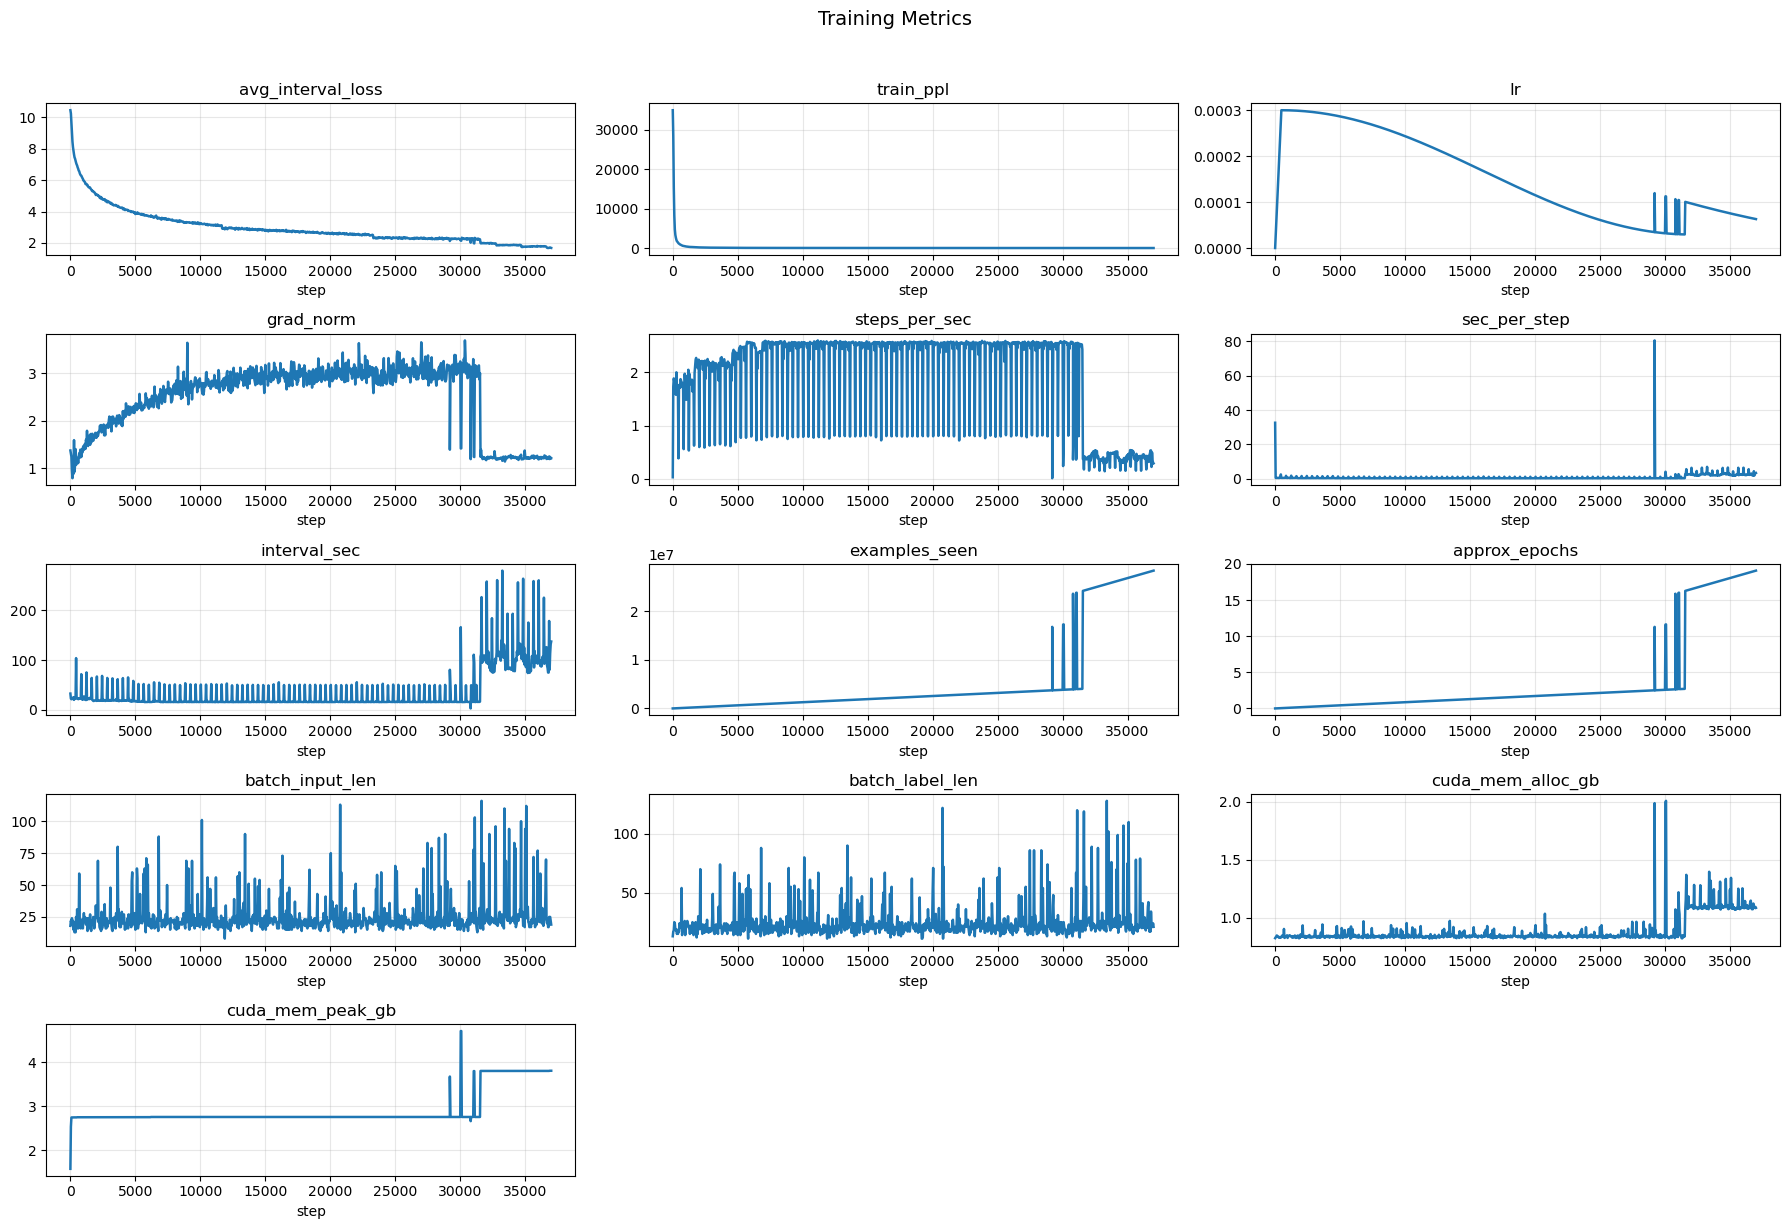

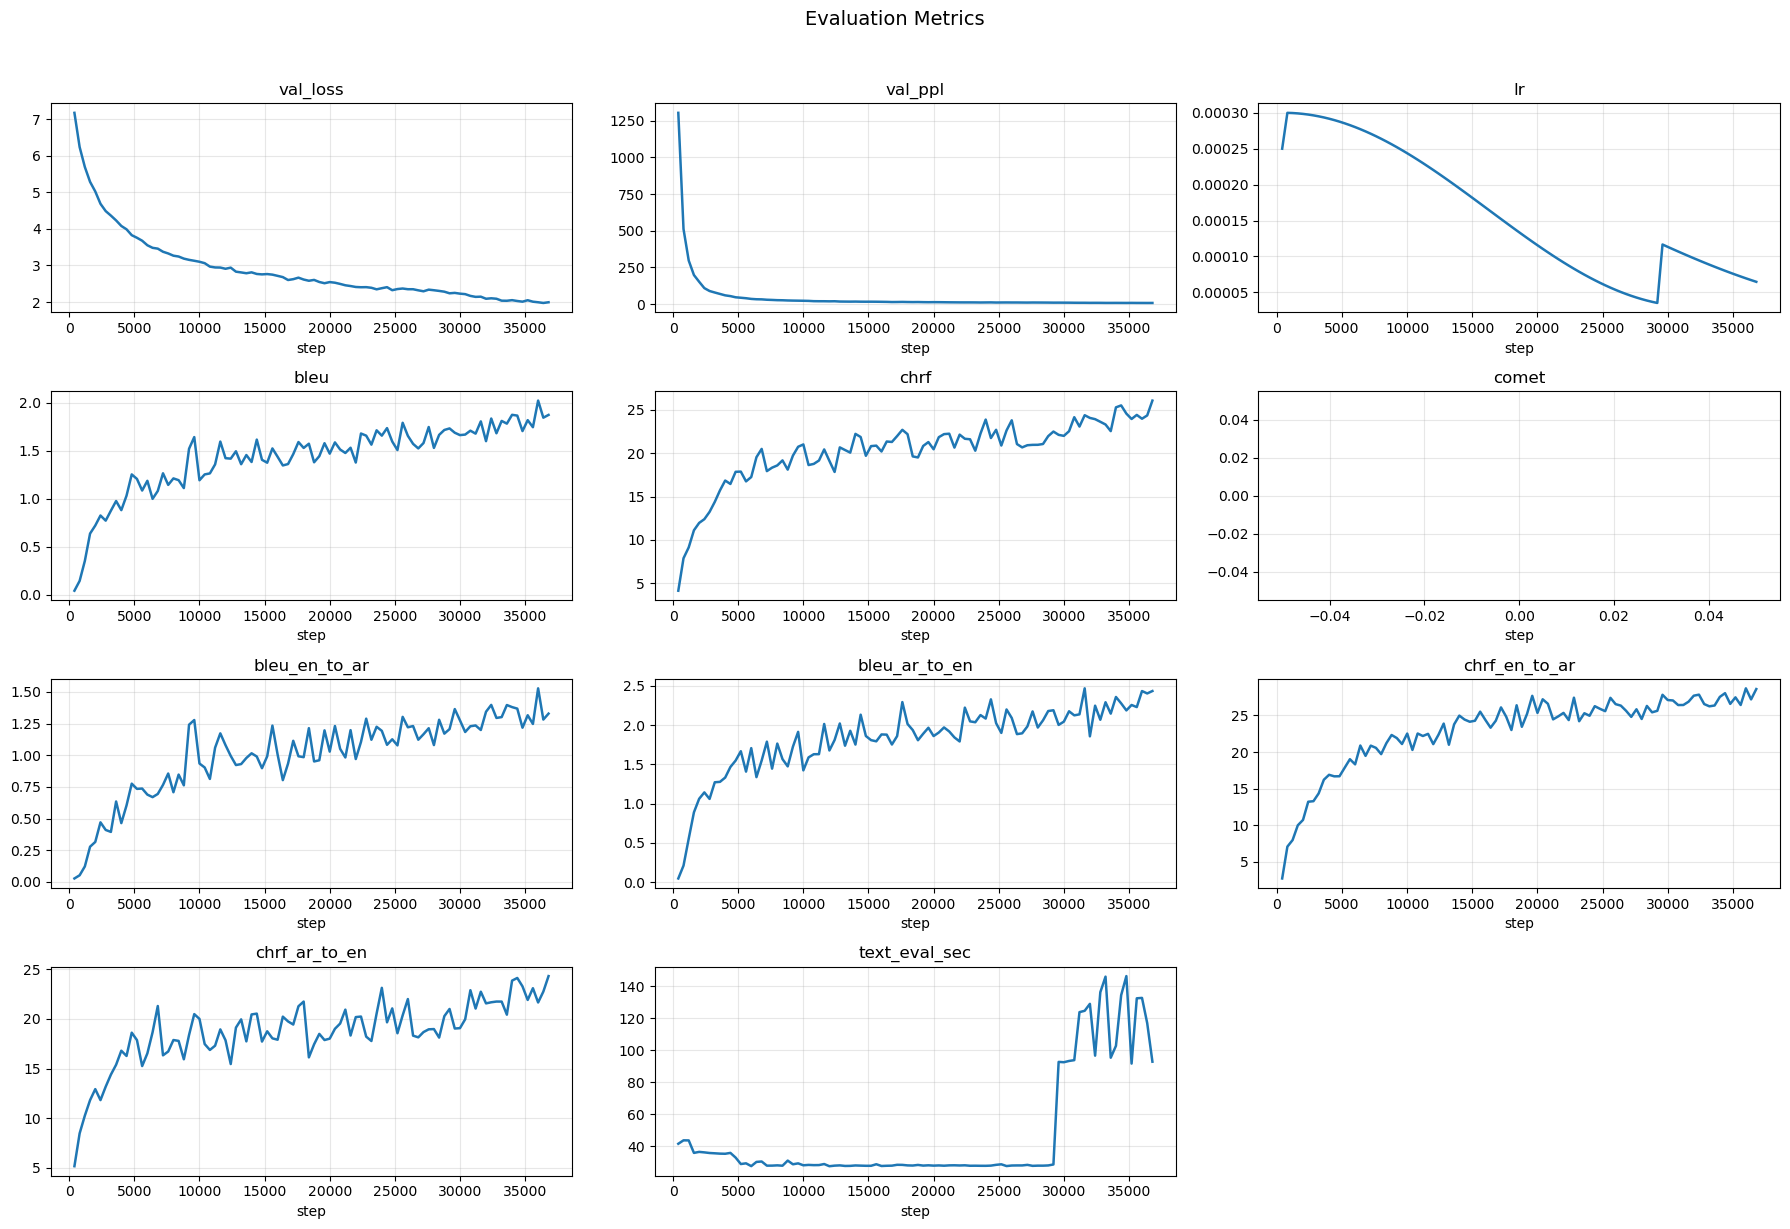

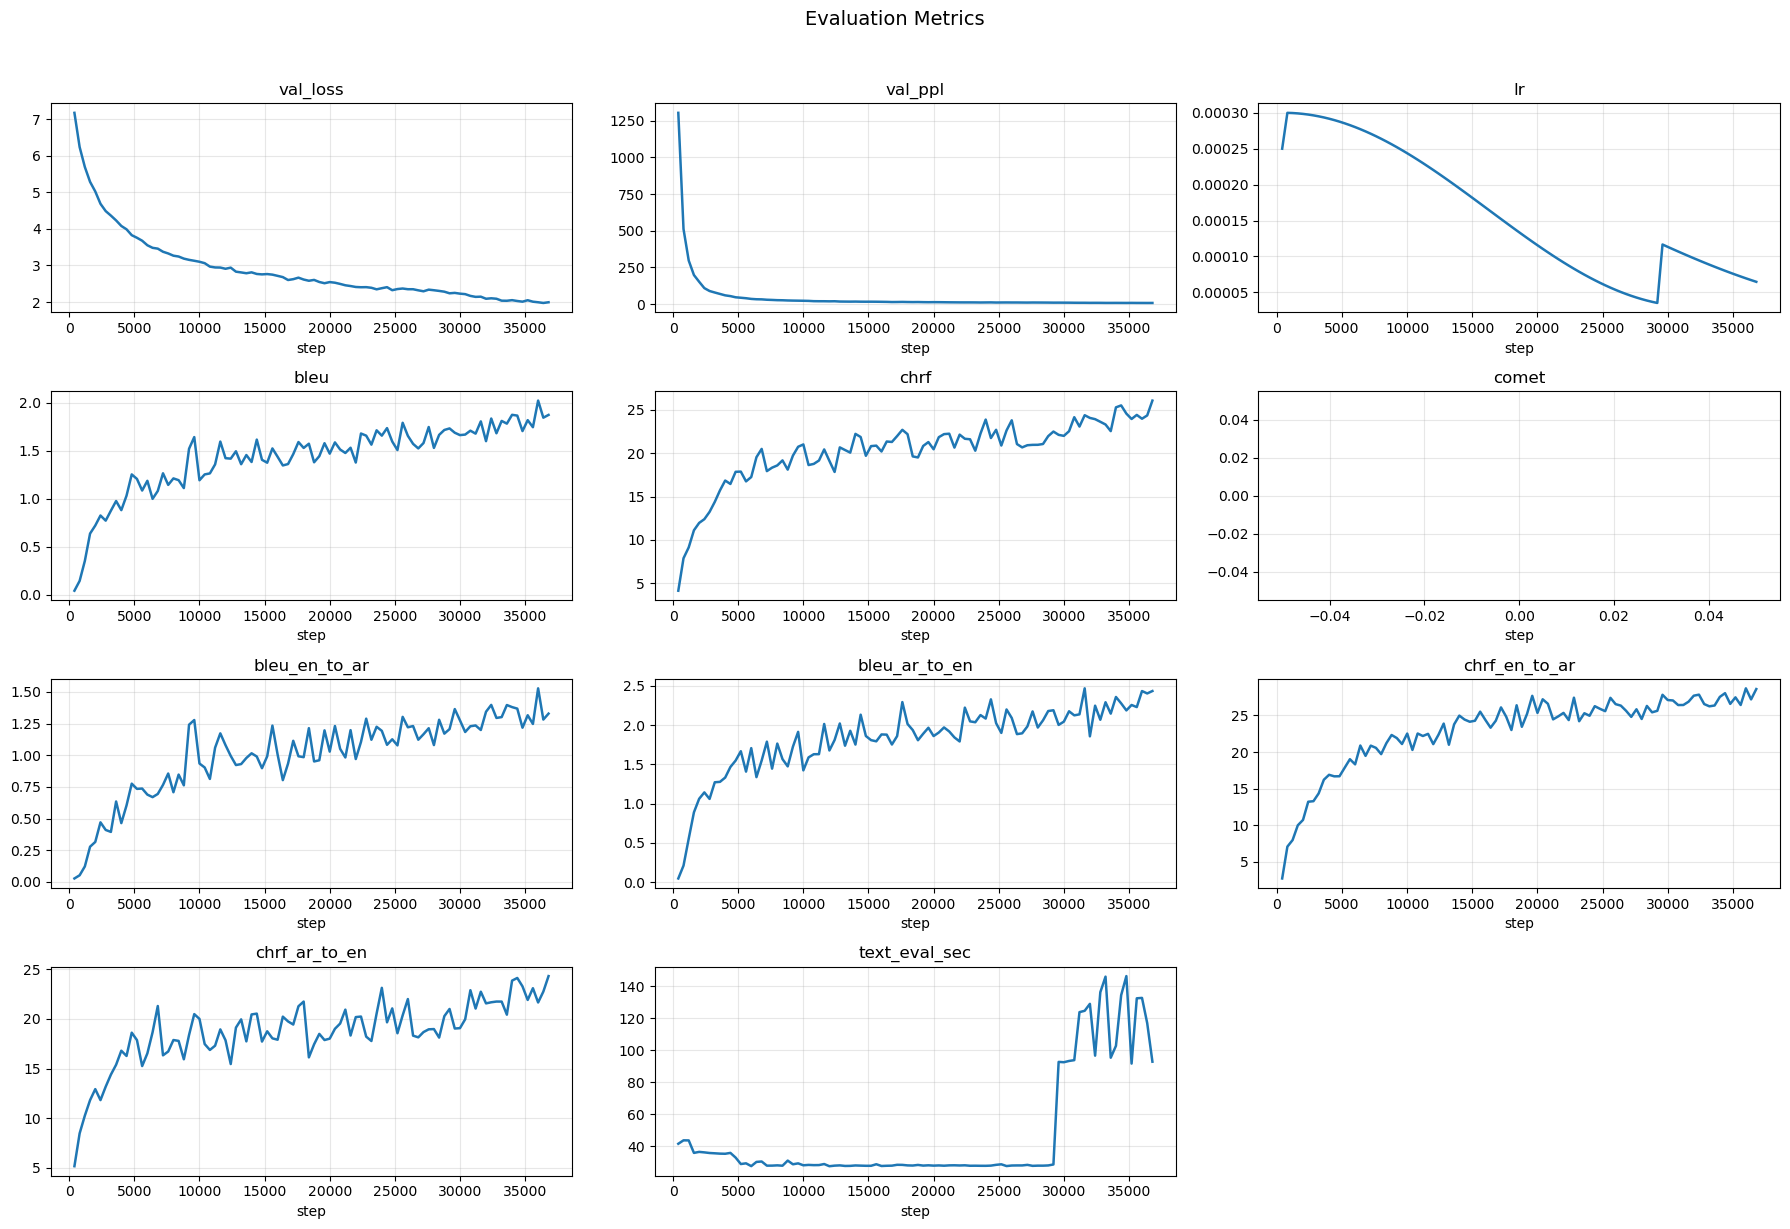

In [114]:
# Cell 2: helper plotters
def plot_cols(df, cols, ncols=3, figsize=(18, 10), suptitle=None):
    cols = [c for c in cols if c in df.columns]
    if not cols:
        print("No matching columns found.")
        return None, None

    nrows = int(np.ceil(len(cols) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    axes = axes.flatten()

    for i, col in enumerate(cols):
        ax = axes[i]
        y = pd.to_numeric(df[col], errors="coerce")
        x = pd.to_numeric(df["step"], errors="coerce") if "step" in df.columns else np.arange(len(df))
        mask = (~x.isna()) & (~y.isna())
        ax.plot(x[mask], y[mask], linewidth=1.8)
        ax.set_title(col)
        ax.grid(alpha=0.3)
        ax.set_xlabel("step")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    if suptitle:
        fig.suptitle(suptitle, y=1.02, fontsize=14)
    plt.tight_layout()
    return fig, axes

PLOTS_DIR = RUN_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# Cell 3: training curves (train_metrics.csv)
train_cols = [
    "avg_interval_loss", "train_ppl", "lr", "grad_norm",
    "steps_per_sec", "sec_per_step", "interval_sec",
    "examples_seen", "approx_epochs",
    "batch_input_len", "batch_label_len",
    "cuda_mem_alloc_gb", "cuda_mem_peak_gb"
]

fig, _ = plot_cols(train_df, train_cols, ncols=3, figsize=(18, 12), suptitle="Training Metrics")
if fig is not None:
    fig.savefig(PLOTS_DIR / "train_metrics_overview.png", dpi=150, bbox_inches="tight")
    plt.show()

# Cell 4: validation/eval curves (eval_metrics.csv)
eval_cols = [
    "val_loss", "val_ppl", "lr",
    "bleu", "chrf", "comet",
    "bleu_en_to_ar", "bleu_ar_to_en",
    "chrf_en_to_ar", "chrf_ar_to_en",
    "eval_sec", "text_eval_sec"
]

fig, _ = plot_cols(eval_df, eval_cols, ncols=3, figsize=(18, 12), suptitle="Evaluation Metrics")
if fig is not None:
    display(fig) 
    fig.savefig(PLOTS_DIR / "eval_metrics_overview.png", dpi=150, bbox_inches="tight")
    plt.show()


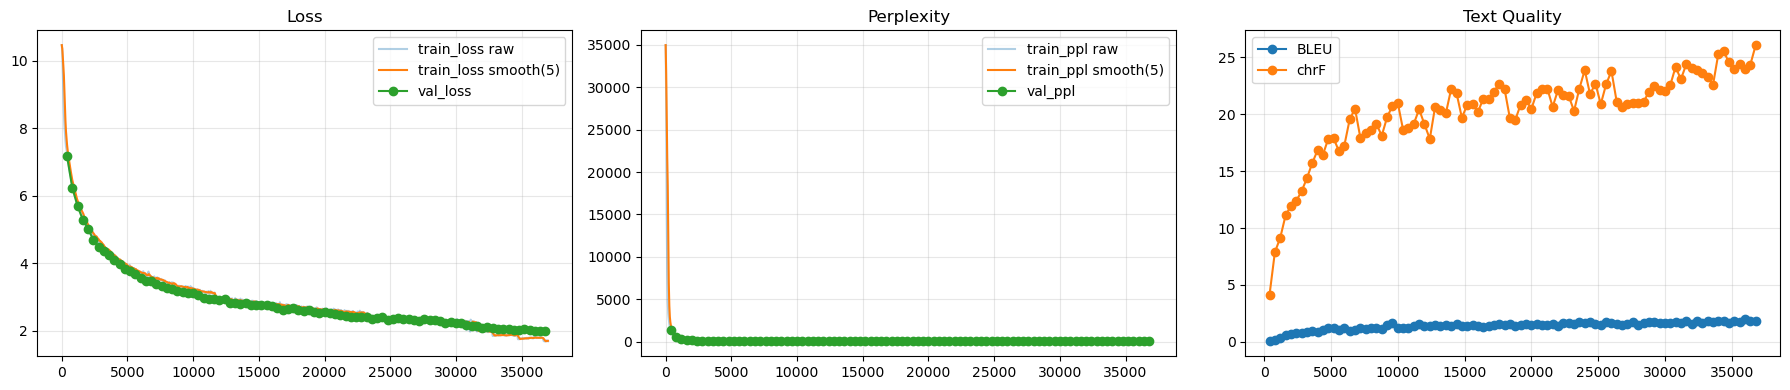

In [115]:
# Cell 5: overlay key curves + smoothing
SMOOTH = 5  # rolling window (steps in log points)

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Loss
if "avg_interval_loss" in train_df.columns:
    y = pd.to_numeric(train_df["avg_interval_loss"], errors="coerce")
    axes[0].plot(train_df["step"], y, alpha=0.35, label="train_loss raw")
    axes[0].plot(train_df["step"], y.rolling(SMOOTH, min_periods=1).mean(), label=f"train_loss smooth({SMOOTH})")
if "val_loss" in eval_df.columns:
    axes[0].plot(eval_df["step"], pd.to_numeric(eval_df["val_loss"], errors="coerce"), "o-", label="val_loss")
axes[0].set_title("Loss")
axes[0].grid(alpha=0.3)
axes[0].legend()

# PPL
if "train_ppl" in train_df.columns:
    y = pd.to_numeric(train_df["train_ppl"], errors="coerce")
    axes[1].plot(train_df["step"], y, alpha=0.35, label="train_ppl raw")
    axes[1].plot(train_df["step"], y.rolling(SMOOTH, min_periods=1).mean(), label=f"train_ppl smooth({SMOOTH})")
if "val_ppl" in eval_df.columns:
    axes[1].plot(eval_df["step"], pd.to_numeric(eval_df["val_ppl"], errors="coerce"), "o-", label="val_ppl")
axes[1].set_title("Perplexity")
axes[1].grid(alpha=0.3)
axes[1].legend()

# BLEU/chrF
if "bleu" in eval_df.columns:
    axes[2].plot(eval_df["step"], pd.to_numeric(eval_df["bleu"], errors="coerce"), "o-", label="BLEU")
if "chrf" in eval_df.columns:
    axes[2].plot(eval_df["step"], pd.to_numeric(eval_df["chrf"], errors="coerce"), "o-", label="chrF")
axes[2].set_title("Text Quality")
axes[2].grid(alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.savefig(PLOTS_DIR / "key_curves_overlay.png", dpi=150, bbox_inches="tight")
plt.show()


In [116]:
# Cell 6: best checkpoints summary + test metrics preview
def best_row(df, col, mode="min"):
    if col not in df.columns or df.empty:
        return None
    s = pd.to_numeric(df[col], errors="coerce")
    if s.dropna().empty:
        return None
    idx = s.idxmin() if mode == "min" else s.idxmax()
    return df.loc[idx]

print("=== Best validation points ===")
for col, mode in [
    ("val_loss", "min"),
    ("val_ppl", "min"),
    ("bleu", "max"),
    ("chrf", "max"),
    ("comet", "max"),
    ("bleu_en_to_ar", "max"),
    ("bleu_ar_to_en", "max"),
    ("chrf_en_to_ar", "max"),
    ("chrf_ar_to_en", "max"),
]:
    row = best_row(eval_df, col, mode)
    if row is not None:
        print(f"{col:15s} | step={int(row['step'])} | value={float(row[col]):.4f}")

print("\n=== Test metrics file ===")
if not test_df.empty:
    display(test_df)
else:
    print(f"Not found yet: {test_path}")


=== Best validation points ===
val_loss        | step=36400 | value=1.9739
val_ppl         | step=36400 | value=7.1987
bleu            | step=36000 | value=2.0214
chrf            | step=36800 | value=26.0659
bleu_en_to_ar   | step=36000 | value=1.5286
bleu_ar_to_en   | step=31600 | value=2.4680
chrf_en_to_ar   | step=36000 | value=28.6933
chrf_ar_to_en   | step=36800 | value=24.3222

=== Test metrics file ===


,run_id,checkpoint,split,num_beams,eval_seconds,num_samples,num_batches,bleu,chrf,comet,bleu_en_to_ar,bleu_ar_to_en,chrf_en_to_ar,chrf_ar_to_en
0,20260218_003516,best_model,test,3,3945.731761,9600.0,150.0,1.886188,25.011033,0.311565,1.402431,2.335941,27.946118,23.250716


C:\Users\mamou\AppData\Local\Temp\ipykernel_5864\224071063.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


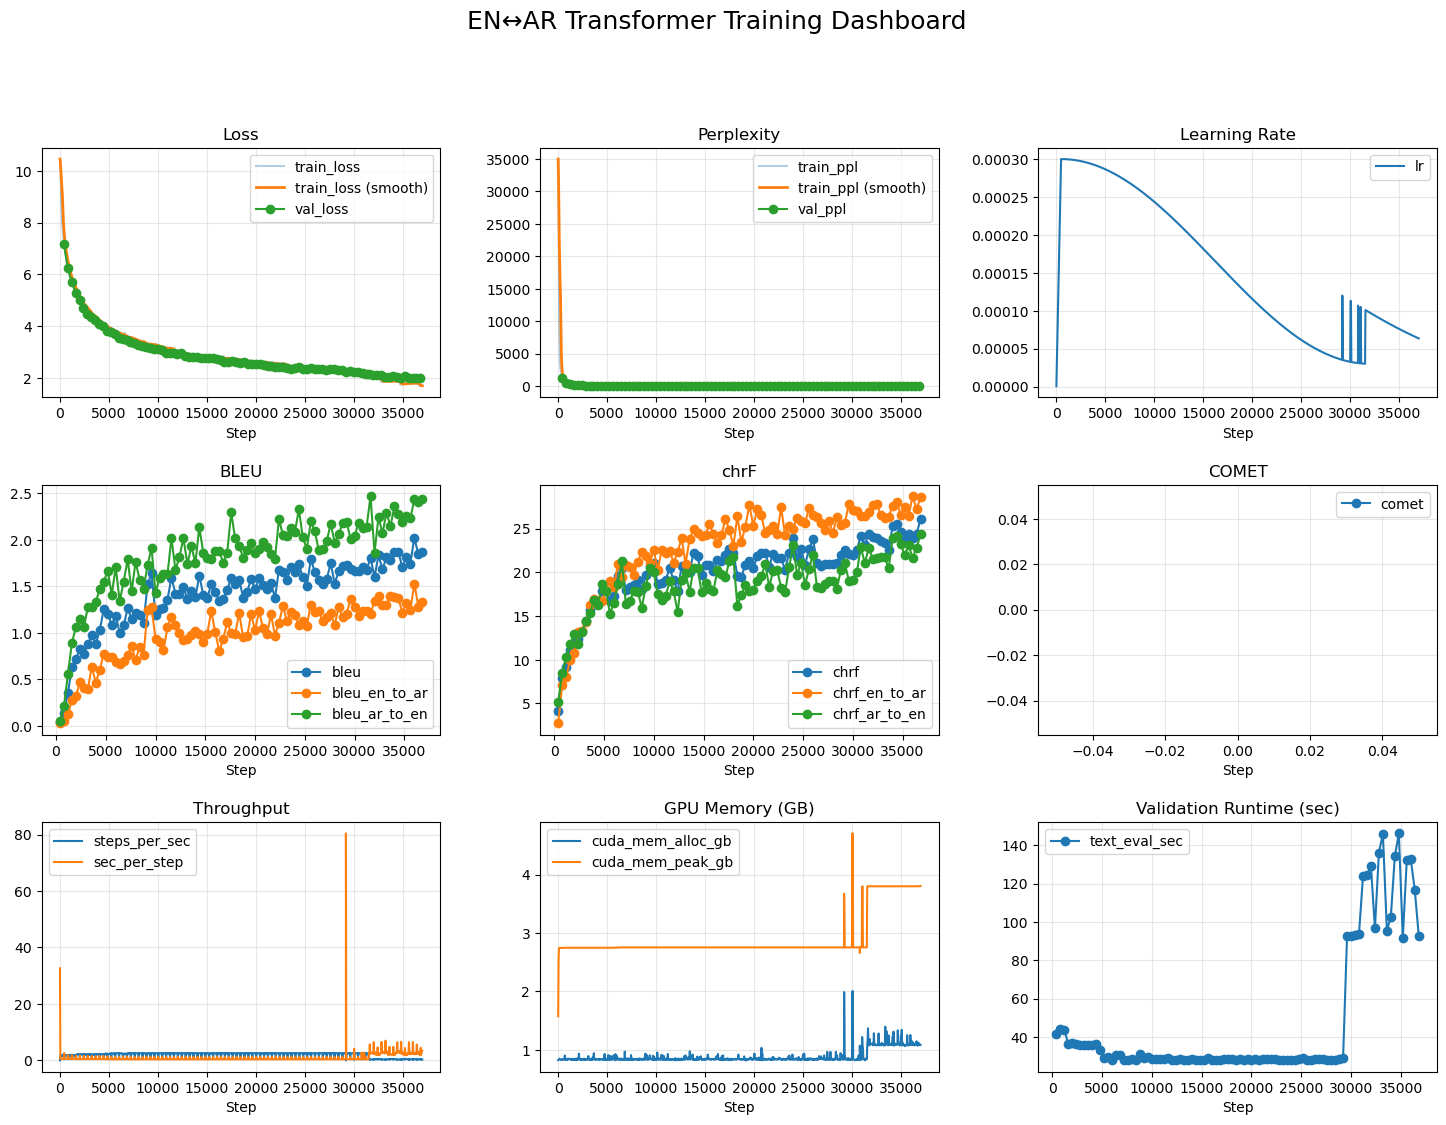

Saved: docs\images\training_dashboard.png
README markdown:
![Training Dashboard](docs/images/training_dashboard.png)


In [117]:
# Cell 7: polished dashboard figure for README (single image)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# Assumes RUN_DIR, train_df, eval_df already exist from previous cells
README_PLOTS_DIR = Path("docs/images")
README_PLOTS_DIR.mkdir(parents=True, exist_ok=True)
out_path = README_PLOTS_DIR / "training_dashboard.png"

def _s(df, col):
    return pd.to_numeric(df[col], errors="coerce") if col in df.columns else pd.Series(dtype=float)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.25)

# 1) Loss
ax = fig.add_subplot(gs[0, 0])
if "avg_interval_loss" in train_df.columns:
    y = _s(train_df, "avg_interval_loss")
    ax.plot(train_df["step"], y, alpha=0.35, label="train_loss")
    ax.plot(train_df["step"], y.rolling(7, min_periods=1).mean(), linewidth=2, label="train_loss (smooth)")
if "val_loss" in eval_df.columns:
    ax.plot(eval_df["step"], _s(eval_df, "val_loss"), "o-", label="val_loss")
ax.set_title("Loss")
ax.set_xlabel("Step")
ax.grid(alpha=0.3)
ax.legend()

# 2) Perplexity
ax = fig.add_subplot(gs[0, 1])
if "train_ppl" in train_df.columns:
    y = _s(train_df, "train_ppl")
    ax.plot(train_df["step"], y, alpha=0.35, label="train_ppl")
    ax.plot(train_df["step"], y.rolling(7, min_periods=1).mean(), linewidth=2, label="train_ppl (smooth)")
if "val_ppl" in eval_df.columns:
    ax.plot(eval_df["step"], _s(eval_df, "val_ppl"), "o-", label="val_ppl")
ax.set_title("Perplexity")
ax.set_xlabel("Step")
ax.grid(alpha=0.3)
ax.legend()

# 3) LR schedule
ax = fig.add_subplot(gs[0, 2])
if "lr" in train_df.columns:
    ax.plot(train_df["step"], _s(train_df, "lr"), label="lr")
elif "lr" in eval_df.columns:
    ax.plot(eval_df["step"], _s(eval_df, "lr"), label="lr")
ax.set_title("Learning Rate")
ax.set_xlabel("Step")
ax.grid(alpha=0.3)
ax.legend()

# 4) BLEU
ax = fig.add_subplot(gs[1, 0])
for c in ["bleu", "bleu_en_to_ar", "bleu_ar_to_en"]:
    if c in eval_df.columns:
        ax.plot(eval_df["step"], _s(eval_df, c), "o-", label=c)
ax.set_title("BLEU")
ax.set_xlabel("Step")
ax.grid(alpha=0.3)
ax.legend()

# 5) chrF
ax = fig.add_subplot(gs[1, 1])
for c in ["chrf", "chrf_en_to_ar", "chrf_ar_to_en"]:
    if c in eval_df.columns:
        ax.plot(eval_df["step"], _s(eval_df, c), "o-", label=c)
ax.set_title("chrF")
ax.set_xlabel("Step")
ax.grid(alpha=0.3)
ax.legend()

# 6) COMET
ax = fig.add_subplot(gs[1, 2])
if "comet" in eval_df.columns:
    ax.plot(eval_df["step"], _s(eval_df, "comet"), "o-", label="comet")
    ax.legend()
ax.set_title("COMET")
ax.set_xlabel("Step")
ax.grid(alpha=0.3)

# 7) Throughput
ax = fig.add_subplot(gs[2, 0])
if "steps_per_sec" in train_df.columns:
    ax.plot(train_df["step"], _s(train_df, "steps_per_sec"), label="steps_per_sec")
if "sec_per_step" in train_df.columns:
    ax.plot(train_df["step"], _s(train_df, "sec_per_step"), label="sec_per_step")
ax.set_title("Throughput")
ax.set_xlabel("Step")
ax.grid(alpha=0.3)
ax.legend()

# 8) GPU memory
ax = fig.add_subplot(gs[2, 1])
for c in ["cuda_mem_alloc_gb", "cuda_mem_peak_gb"]:
    if c in train_df.columns:
        ax.plot(train_df["step"], _s(train_df, c), label=c)
ax.set_title("GPU Memory (GB)")
ax.set_xlabel("Step")
ax.grid(alpha=0.3)
ax.legend()

# 9) Text metric runtime
ax = fig.add_subplot(gs[2, 2])
for c in ["eval_sec", "text_eval_sec"]:
    if c in eval_df.columns:
        ax.plot(eval_df["step"], _s(eval_df, c), "o-", label=c)
ax.set_title("Validation Runtime (sec)")
ax.set_xlabel("Step")
ax.grid(alpha=0.3)
ax.legend()

fig.suptitle("EN↔AR Transformer Training Dashboard", fontsize=18, y=0.995)
plt.tight_layout()
fig.savefig(out_path, dpi=180, bbox_inches="tight")
plt.show()

print(f"Saved: {out_path}")
print("README markdown:")
print(f'![Training Dashboard]({out_path.as_posix()})')


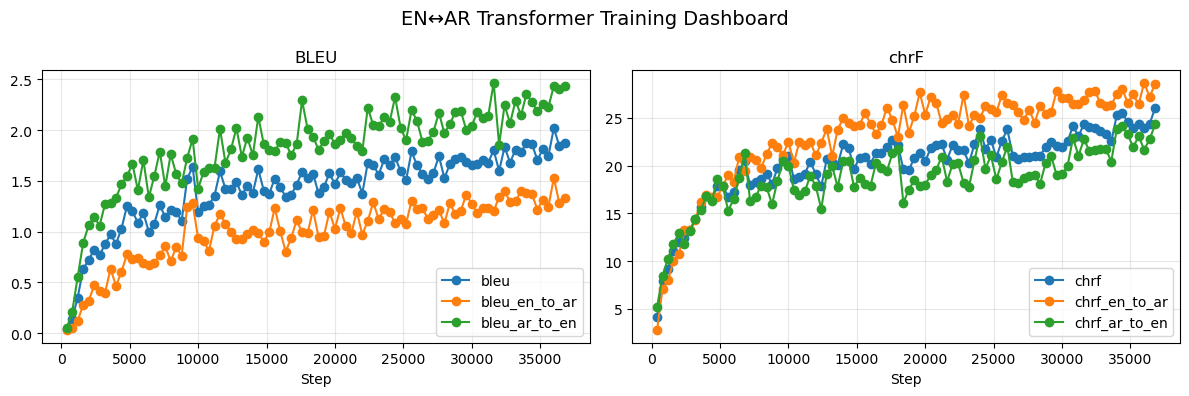

Saved: docs\images\bleu_chrf.png
README markdown:
![Training Dashboard](docs/images/bleu_chrf.png)


In [119]:
# Cell 7: polished dashboard figure for README (single image)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# Assumes RUN_DIR, train_df, eval_df already exist from previous cells
README_PLOTS_DIR = Path("docs/images")
README_PLOTS_DIR.mkdir(parents=True, exist_ok=True)
out_path = README_PLOTS_DIR / "bleu_chrf.png"

def _s(df, col):
    return pd.to_numeric(df[col], errors="coerce") if col in df.columns else pd.Series(dtype=float)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# BLEU
ax = axes[0]
for c in ["bleu", "bleu_en_to_ar", "bleu_ar_to_en"]:
    if c in eval_df.columns:
        ax.plot(eval_df["step"], _s(eval_df, c), "o-", label=c)
ax.set_title("BLEU")
ax.set_xlabel("Step")
ax.grid(alpha=0.3)
ax.legend()

# chrF
ax = axes[1]
for c in ["chrf", "chrf_en_to_ar", "chrf_ar_to_en"]:
    if c in eval_df.columns:
        ax.plot(eval_df["step"], _s(eval_df, c), "o-", label=c)
ax.set_title("chrF")
ax.set_xlabel("Step")
ax.grid(alpha=0.3)
ax.legend()

fig.suptitle("EN↔AR Transformer Training Dashboard", fontsize=14)
plt.tight_layout()
fig.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()

print(f"Saved: {out_path}")
print("README markdown:")
print(f'![Training Dashboard]({out_path.as_posix()})')
